In [1]:
import sys
!{sys.executable} -m pip install statsmodels --no-index

Ignoring pip: markers 'python_version < "3"' don't match your environment
Looking in links: /cvmfs/soft.computecanada.ca/custom/python/wheelhouse/gentoo/avx2, /cvmfs/soft.computecanada.ca/custom/python/wheelhouse/gentoo/generic, /cvmfs/soft.computecanada.ca/custom/python/wheelhouse/generic


In [2]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from matplotlib.patches import ConnectionStyle
from matplotlib.lines import Line2D
import matplotlib.ticker as mticker
import statsmodels.formula.api as smf
import re

## 1. Help functions

In [3]:
HAPPY_COLUMNS = ['Type', 'Filter', 'TRUTH.TP', 'QUERY.FP', 'TRUTH.FN', 'METRIC.Recall', 'METRIC.Precision', 'METRIC.F1_Score']

def annotate_pvalue(axes, x1, x2, y, value, fraction, va = 'bottom'):
    display_coord1 = axes.transData.transform((x1, y))
    display_coord2 = axes.transData.transform((x2, y))
    display_dist = (display_coord2[0] - display_coord1[0]) * fraction
    text_y = axes.transData.inverted().transform((display_coord2[0] , display_coord2[1]  + display_dist))[1]
    if value >= 0.010:
        text = '$\it{p}='+ f'{value:.3f}' + '$'
    else:
        f = mticker.ScalarFormatter(useOffset = False, useMathText = True)
        f.set_powerlimits((-1, 1))
        text = "${}$".format(f.format_data(float(f'{value:.1e}'))).replace(' ', '')
        text = '$\it{p}=$' + re.sub('0+\\\\', '\\\\', text)
    axes.text(x1 + (x2 - x1) / 2, text_y, text, fontsize = 8, va = va, ha = 'center')
    axes.annotate('',
                  xy = (x1, y), xycoords = 'data', 
                  xytext= (x2, y), textcoords = 'data',
                  arrowprops = dict(arrowstyle = '-', connectionstyle = ConnectionStyle.Bar(armA = 0.0, armB = 0.0, fraction = fraction, angle = None))
                 )

def annotate_sample_size(axes, x, data, offset_y_px, va = 'bottom'):
    max_y = max(data)
    n = len(data)
    display_coord = axes.transData.transform((x, max_y))
    text_y = axes.transData.inverted().transform((display_coord[0] , display_coord[1]  + offset_y_px))[1]
    axes.text(x, text_y, '$\it{n}$ = ' + f'{n}', fontsize = 8, va = va, ha = 'center')
    
def sign_symbol(pval):
    if pval <= 0.001:
        return '***'
    elif pval <= 0.01:
        return '**'
    elif pval <= 0.05:
        return '*'
    else:
        return ''

## 2. Input files

In [4]:
SAMPLE_ANNOTATIONS_FILE = 'sample_annotations.txt'
BENCHMARK_DIR = 'Variant_calling_analysis/WES'
WEGS_BENCHMARK_DIR = 'Variant_calling_analysis/WEGS'
UMI_GATK_BENCHMARK_DIR = 'Variant_calling_analysis/WES_UMI_GATK'
UMI_LOCATIT_BENCHMARK_DIR = 'Variant_calling_analysis/WES_UMI_LocatIt'
WEGS_FALSE_NEGATIVES_DIR = 'Variant_calling_analysis/FN_in_Multiplexing_TP_in_Noplexing'


## 3. Load data

In [5]:
# Load sample annotations
df_samples = pd.read_csv(SAMPLE_ANNOTATIONS_FILE, header = 0, sep = '\t')


### 3.1 Load WES no-plexing and WES plexing with default reads deduplication

In [6]:
df_variants = []
for row_index, row in df_samples.iterrows():
    filepath = f'{BENCHMARK_DIR}/{row.Plexing}plex/{row.Filename}.norm.hard_filter.happy_benchmark.summary.csv'
    df = pd.read_csv(filepath, usecols = HAPPY_COLUMNS).rename(columns = {
        'METRIC.Recall': 'Recall', 
        'METRIC.Precision': 'Precision',
        'METRIC.F1_Score': 'F1_Score',
        'TRUTH.TP': 'TP',
        'QUERY.FP': 'FP',
        'TRUTH.FN': 'FN'
    })
    df['Total_called'] = df['TP'] + df['FP']
    df['ID'] = row.Filename
    df['HGID'] = row.HGID
    df['Batch'] = row.Batch
    df['Plexing'] = row.Plexing
    df['WGS_depth'] = 0
    df_variants.append(df)
df_variants = pd.concat(df_variants).reset_index(drop = True)


### 3.2 Load WEGS data

In [7]:
df_wegs_variants = []
for row_index, row in df_samples.iterrows():
    if row.Plexing == 1:
        continue
    for wgs_depth in [2, 5]:
        filepath = f'{WEGS_BENCHMARK_DIR}/{row.Plexing}plex_{wgs_depth}X/{row.Filename}.norm.hard_filter.happy_benchmark.summary.csv'
        df = pd.read_csv(filepath, usecols = HAPPY_COLUMNS).rename(columns = {
            'METRIC.Recall': 'Recall', 
            'METRIC.Precision': 'Precision',
            'METRIC.F1_Score': 'F1_Score',
            'TRUTH.TP': 'TP',
            'QUERY.FP': 'FP',
            'TRUTH.FN': 'FN'
        })
        df['Total_called'] = df['TP'] + df['FP']
        df['ID'] = row.Filename
        df['HGID'] = row.HGID
        df['Batch'] = row.Batch
        df['Plexing'] = row.Plexing
        df['WGS_depth'] = wgs_depth
        df_wegs_variants.append(df)
df_wegs_variants = pd.concat(df_wegs_variants).reset_index(drop = True)

### 3.3 Load UMI-aware deduplication data

In [8]:
df_umi_gatk_variants = []
for row_index, row in df_samples.iterrows():
    filepath = f'{UMI_GATK_BENCHMARK_DIR}/{row.Plexing}plex/{row.Filename}.norm.hard_filter.happy_benchmark.summary.csv'
    df = pd.read_csv(filepath, usecols = HAPPY_COLUMNS).rename(columns = {
        'METRIC.Recall': 'Recall', 
        'METRIC.Precision': 'Precision',
        'METRIC.F1_Score': 'F1_Score',
        'TRUTH.TP': 'TP',
        'QUERY.FP': 'FP',
        'TRUTH.FN': 'FN'
    })
    df['Total_called'] = df['TP'] + df['FP']
    df['ID'] = row.Filename
    df['HGID'] = row.HGID
    df['Batch'] = row.Batch
    df['Plexing'] = row.Plexing
    df_umi_gatk_variants.append(df)
df_umi_gatk_variants = pd.concat(df_umi_gatk_variants).reset_index(drop = True)

df_umi_locatit_variants = []
for row_index, row in df_samples.iterrows():
    filepath = f'{UMI_LOCATIT_BENCHMARK_DIR}/{row.Plexing}plex/{row.Filename}.norm.hard_filter.happy_benchmark.summary.csv'
    df = pd.read_csv(filepath, usecols = HAPPY_COLUMNS).rename(columns = {
        'METRIC.Recall': 'Recall', 
        'METRIC.Precision': 'Precision',
        'METRIC.F1_Score': 'F1_Score',
        'TRUTH.TP': 'TP',
        'QUERY.FP': 'FP',
        'TRUTH.FN': 'FN'
    })
    df['Total_called'] = df['TP'] + df['FP']
    df['ID'] = row.Filename
    df['HGID'] = row.HGID
    df['Batch'] = row.Batch
    df['Plexing'] = row.Plexing
    df_umi_locatit_variants.append(df)
df_umi_locatit_variants = pd.concat(df_umi_locatit_variants).reset_index(drop = True)

### 3.4 Load False Negative WEGS variants

In [9]:
df_fn_recoved_all = []
for row_index, row in df_samples.iterrows():
    if row.Plexing == 1:
        continue
    filename = f'{WEGS_FALSE_NEGATIVES_DIR}/{row.Plexing}_{row.Filename}.tsv'
    df_fn_all = pd.read_csv(filename, sep = '\t', na_values = 'None')
    n_fn_all= len(df_fn_all)
    df_fn_recovered = df_fn_all[df_fn_all.N_2 == 3]
    df_fn_recovered_higher_dp = df_fn_recovered[df_fn_recovered.DP_1 < df_fn_recovered.DP_2]
    df_fn_recoved_all.append({ 
        'Plexing': row.Plexing, 
        'FN_ALL': n_fn_all,
        'FN_RECOVERED': len(df_fn_recovered),
        'FN_RECOVERED_HIGHER_DP': len(df_fn_recovered_higher_dp)
    })
df_fn_recoved_all = pd.DataFrame(df_fn_recoved_all) 

## 4. Figures and tables

### TABLE: Variant calling in whole exome sequencing experiments with and without multiplexing.

In [10]:
plexings = [1, 4, 8]
types = ['SNP', 'INDEL']

data = {
    'Number of samples sequenced together (multiplexed)': [],
    'SNP N (SE)': [],
    'SNP TP (SE)': [],
    'SNP FP (SE)': [],
    'SNP FN (SE)': [],
    'SNP Recall (SE)': [],
    'SNP Precision (SE)': [],
    'INDEL N (SE)': [],
    'INDEL TP (SE)': [],
    'INDEL FP (SE)': [],
    'INDEL FN (SE)': [],
    'INDEL Recall (SE)': [],
    'INDEL Precision (SE)': [],
}

for plexing in plexings:
    data['Number of samples sequenced together (multiplexed)'].append(plexing)
    for vtype in types:
        df_temp = df_variants[(df_variants.Plexing == plexing) & (df_variants.Type == vtype) & (df_variants.Filter == 'ALL')]
    
        avg = np.mean(df_temp['TP'] + df_temp['FP'])
        sem = stats.sem(df_temp['TP'] + df_temp['FP'])
        data[f'{vtype} N (SE)'].append(f'{avg:.0f} ({sem:.0f})')

        avg = np.mean(df_temp['TP'])
        sem = stats.sem(df_temp['TP'])
        data[f'{vtype} TP (SE)'].append(f'{avg:.0f} ({sem:.0f})')

        avg = np.mean(df_temp['FP'])
        sem = stats.sem(df_temp['FP'])
        data[f'{vtype} FP (SE)'].append(f'{avg:.0f} ({sem:.0f})')

        avg = np.mean(df_temp['FN'])
        sem = stats.sem(df_temp['FN'])
        data[f'{vtype} FN (SE)'].append(f'{avg:.0f} ({sem:.0f})')
        
        avg = np.mean(df_temp['Recall'])
        sem = stats.sem(df_temp['Recall'])
        data[f'{vtype} Recall (SE)'].append(f'{avg:.4f} ({sem:.4f})')
        
        avg = np.mean(df_temp['Precision'])
        sem = stats.sem(df_temp['Precision'])
        data[f'{vtype} Precision (SE)'].append(f'{avg:.4f} ({sem:.4f})')

pd.DataFrame(data)


,Number of samples sequenced together (multiplexed),SNP N (SE),SNP TP (SE),SNP FP (SE),SNP FN (SE),SNP Recall (SE),SNP Precision (SE),INDEL N (SE),INDEL TP (SE),INDEL FP (SE),INDEL FN (SE),INDEL Recall (SE),INDEL Precision (SE)
0,1,22648 (33),22241 (30),406 (7),384 (8),0.9830 (0.0004),0.9821 (0.0003),683 (7),631 (6),53 (2),41 (2),0.9390 (0.0029),0.9232 (0.0028)
1,4,22632 (28),22214 (24),418 (6),411 (11),0.9818 (0.0005),0.9815 (0.0002),682 (7),629 (5),54 (2),43 (2),0.9360 (0.0031),0.9220 (0.0021)
2,8,22592 (28),22177 (23),415 (6),446 (9),0.9803 (0.0004),0.9816 (0.0003),679 (6),623 (4),56 (2),50 (2),0.9261 (0.0028),0.9186 (0.0027)


### FIGURE: Recall and precision of the SNVs and InDels called in sequencing experiments without and with multiplexing.

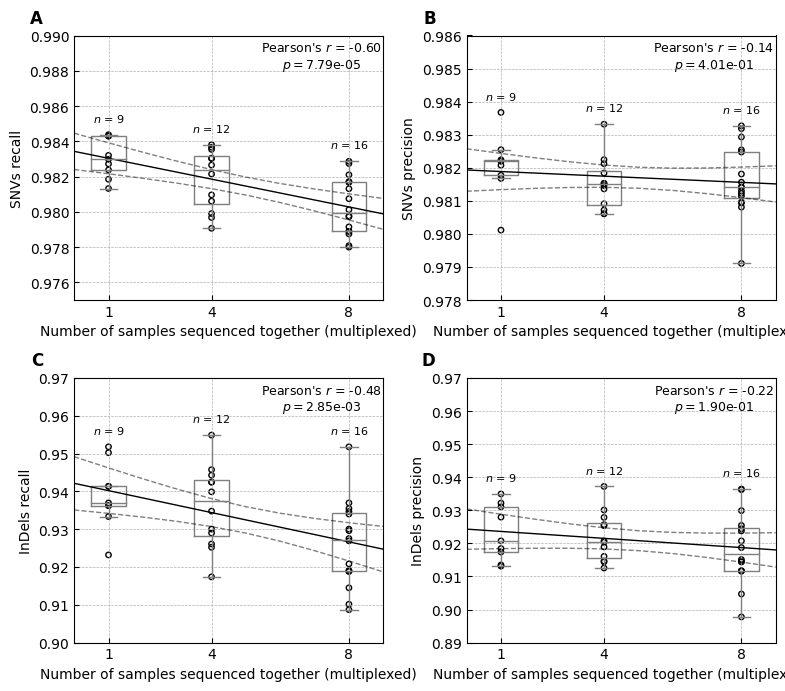

In [11]:
plt.style.use('default')
fig = plt.figure(figsize=(8, 7), dpi = 100)

df_snvs = df_variants[(df_variants.Type == 'SNP') & (df_variants.Filter == 'ALL')]
df_indels = df_variants[(df_variants.Type == 'INDEL') & (df_variants.Filter == 'ALL')]


# FIGURE A.
# ============== #
ax = fig.add_subplot(2, 2, 1)

# Run regression model
model = smf.ols('Recall ~ Plexing', df_snvs)
res = model.fit()
a = res.params['Intercept']
b = res.params['Plexing']
model_pvalue = res.pvalues['Plexing']

# Compute Pearson's correlation
corr, corr_pvalue = stats.pearsonr(df_snvs['Recall'], df_snvs.Plexing)

ax.scatter(df_snvs.Plexing, df_snvs['Recall'], facecolors='none', edgecolors='black', s = 15)

# boxplots
bp_data = []
bp_positions = []
for plexing in sorted(df_snvs.Plexing.unique()):
    bp_positions.append(plexing)
    bp_data.append(df_snvs[df_snvs.Plexing == plexing]['Recall'])
ax.boxplot(bp_data, positions = bp_positions, widths = 1, 
                showfliers = False, showmeans = False, 
                medianprops = {'color': 'tab:grey'},
                boxprops = {'color': 'tab:grey'},
                whiskerprops={'color': 'tab:grey'}, 
                capprops={'color': 'tab:grey'})

# Regression line and confidence intervals
xs = [ x for x in range(0, 10) ]
ax.plot(xs, [a + b * x for x in xs], color = 'black', linewidth = 1)
pred_summary = res.get_prediction(pd.DataFrame({'Plexing': xs})).summary_frame(alpha=0.05)
ax.plot(xs, pred_summary.mean_ci_lower, color = 'black', linestyle = '--', linewidth = 1, alpha = 0.5)
ax.plot(xs, pred_summary.mean_ci_upper, color = 'black', linestyle = '--', linewidth = 1, alpha = 0.5)

# Limits. Must be set before text annotations.
ax.set_xlim([0,  9])
ax.set_ylim([0.975,  0.99])

# Grid & ticks
ax.tick_params(axis = 'both', direction = 'in')
ax.grid(linestyle = '--', linewidth = 0.5)

# Text annotations
for x, data in zip(bp_positions, bp_data):
    annotate_sample_size(ax, x, data, 10)
    
ax.annotate(
    f'Pearson\'s ' + r'$\it{r}$ = ' + f'{corr:.2f}\n' + r'$\it{p}=$' + f'{corr_pvalue:.2e}', 
    (0.8, 0.86), xycoords=ax.transAxes, fontsize = 9, ha='center', va='bottom')

ax.set_ylabel('SNVs recall')
ax.set_xlabel('Number of samples sequenced together (multiplexed)')
ax.text(-0.1, 1.1, 'A', transform = ax.transAxes, fontsize = 12, fontweight = 'bold', va = 'top', ha = 'right')


# FIGURE B.
# ============== #
ax = fig.add_subplot(2, 2, 2)

# Run regression model
model = smf.ols('Precision ~ Plexing', df_snvs)
res = model.fit()
a = res.params['Intercept']
b = res.params['Plexing']
model_pvalue = res.pvalues['Plexing']

# Compute Pearson's correlation
corr, corr_pvalue = stats.pearsonr(df_snvs['Precision'], df_snvs.Plexing)

ax.scatter(df_snvs.Plexing, df_snvs['Precision'], facecolors='none', edgecolors='black', s = 15)

# boxplots
bp_data = []
bp_positions = []
for plexing in sorted(df_snvs.Plexing.unique()):
    bp_positions.append(plexing)
    bp_data.append(df_snvs[df_snvs.Plexing == plexing]['Precision'])
ax.boxplot(bp_data, positions = bp_positions, widths = 1, 
                showfliers = False, showmeans = False, 
                medianprops = {'color': 'tab:grey'},
                boxprops = {'color': 'tab:grey'},
                whiskerprops={'color': 'tab:grey'}, 
                capprops={'color': 'tab:grey'})

# Regression line and confidence intervals
xs = [ x for x in range(0, 10) ]
ax.plot(xs, [a + b * x for x in xs], color = 'black', linewidth = 1)
pred_summary = res.get_prediction(pd.DataFrame({'Plexing': xs})).summary_frame(alpha=0.05)
ax.plot(xs, pred_summary.mean_ci_lower, color = 'black', linestyle = '--', linewidth = 1, alpha = 0.5)
ax.plot(xs, pred_summary.mean_ci_upper, color = 'black', linestyle = '--', linewidth = 1, alpha = 0.5)

# Limits. Must be set before text annotations.
ax.set_xlim([0,  9])
ax.set_ylim([0.978,  0.986])

# Grid & ticks
ax.tick_params(axis = 'both', direction = 'in')
ax.grid(linestyle = '--', linewidth = 0.5)

# Text annotations
for x, data in zip(bp_positions, bp_data):
    annotate_sample_size(ax, x, data, 10)
    
ax.annotate(
    f'Pearson\'s ' + r'$\it{r}$ = ' + f'{corr:.2f}\n' + r'$\it{p}=$' + f'{corr_pvalue:.2e}', 
    (0.8, 0.86), xycoords=ax.transAxes, fontsize = 9, ha='center', va='bottom')

ax.set_ylabel('SNVs precision')
ax.set_xlabel('Number of samples sequenced together (multiplexed)')
ax.text(-0.1, 1.1, 'B', transform = ax.transAxes, fontsize = 12, fontweight = 'bold', va = 'top', ha = 'right')


# FIGURE C.
# ============== #
ax = fig.add_subplot(2, 2, 3)

# Run regression model
model = smf.ols('Recall ~ Plexing', df_indels)
res = model.fit()
a = res.params['Intercept']
b = res.params['Plexing']
model_pvalue = res.pvalues['Plexing']

# Compute Pearson's correlation
corr, corr_pvalue = stats.pearsonr(df_indels['Recall'], df_snvs.Plexing)

ax.scatter(df_indels.Plexing, df_indels['Recall'], facecolors='none', edgecolors='black', s = 15)

# boxplots
bp_data = []
bp_positions = []
for plexing in sorted(df_indels.Plexing.unique()):
    bp_positions.append(plexing)
    bp_data.append(df_indels[df_indels.Plexing == plexing]['Recall'])
ax.boxplot(bp_data, positions = bp_positions, widths = 1, 
                showfliers = False, showmeans = False, 
                medianprops = {'color': 'tab:grey'},
                boxprops = {'color': 'tab:grey'},
                whiskerprops={'color': 'tab:grey'}, 
                capprops={'color': 'tab:grey'})

# Regression line and confidence intervals
xs = [ x for x in range(0, 10) ]
ax.plot(xs, [a + b * x for x in xs], color = 'black', linewidth = 1)
pred_summary = res.get_prediction(pd.DataFrame({'Plexing': xs})).summary_frame(alpha=0.05)
ax.plot(xs, pred_summary.mean_ci_lower, color = 'black', linestyle = '--', linewidth = 1, alpha = 0.5)
ax.plot(xs, pred_summary.mean_ci_upper, color = 'black', linestyle = '--', linewidth = 1, alpha = 0.5)

# Limits. Must be set before text annotations.
ax.set_xlim([0,  9])
ax.set_ylim([0.90,  0.97])

# Grid & ticks
ax.tick_params(axis = 'both', direction = 'in')
ax.grid(linestyle = '--', linewidth = 0.5)

# Text annotations
for x, data in zip(bp_positions, bp_data):
    annotate_sample_size(ax, x, data, 10)
    
ax.annotate(
    f'Pearson\'s ' + r'$\it{r}$ = ' + f'{corr:.2f}\n' + r'$\it{p}=$' + f'{corr_pvalue:.2e}', 
    (0.8, 0.86), xycoords=ax.transAxes, fontsize = 9, ha='center', va='bottom')

ax.set_ylabel('InDels recall')
ax.set_xlabel('Number of samples sequenced together (multiplexed)')
ax.text(-0.1, 1.1, 'C', transform = ax.transAxes, fontsize = 12, fontweight = 'bold', va = 'top', ha = 'right')


# FIGURE D.
# ============== #
ax = fig.add_subplot(2, 2, 4)

# Run regression model
model = smf.ols('Precision ~ Plexing', df_indels)
res = model.fit()
a = res.params['Intercept']
b = res.params['Plexing']
model_pvalue = res.pvalues['Plexing']

# Compute Pearson's correlation
corr, corr_pvalue = stats.pearsonr(df_indels['Precision'], df_snvs.Plexing)

ax.scatter(df_indels.Plexing, df_indels['Precision'], facecolors='none', edgecolors='black', s = 15)

# boxplots
bp_data = []
bp_positions = []
for plexing in sorted(df_indels.Plexing.unique()):
    bp_positions.append(plexing)
    bp_data.append(df_indels[df_indels.Plexing == plexing]['Precision'])
ax.boxplot(bp_data, positions = bp_positions, widths = 1, 
                showfliers = False, showmeans = False, 
                medianprops = {'color': 'tab:grey'},
                boxprops = {'color': 'tab:grey'},
                whiskerprops={'color': 'tab:grey'}, 
                capprops={'color': 'tab:grey'})

# Regression line and confidence intervals
xs = [ x for x in range(0, 10) ]
ax.plot(xs, [a + b * x for x in xs], color = 'black', linewidth = 1)
pred_summary = res.get_prediction(pd.DataFrame({'Plexing': xs})).summary_frame(alpha=0.05)
ax.plot(xs, pred_summary.mean_ci_lower, color = 'black', linestyle = '--', linewidth = 1, alpha = 0.5)
ax.plot(xs, pred_summary.mean_ci_upper, color = 'black', linestyle = '--', linewidth = 1, alpha = 0.5)

# Limits. Must be set before text annotations.
ax.set_xlim([0,  9])
ax.set_ylim([0.89,  0.97])

# Grid & ticks
ax.tick_params(axis = 'both', direction = 'in')
ax.grid(linestyle = '--', linewidth = 0.5)

# Text annotations
for x, data in zip(bp_positions, bp_data):
    annotate_sample_size(ax, x, data, 10)
    
ax.annotate(
    f'Pearson\'s ' + r'$\it{r}$ = ' + f'{corr:.2f}\n' + r'$\it{p}=$' + f'{corr_pvalue:.2e}', 
    (0.8, 0.86), xycoords=ax.transAxes, fontsize = 9, ha='center', va='bottom')

ax.set_ylabel('InDels precision')
ax.set_xlabel('Number of samples sequenced together (multiplexed)')
ax.text(-0.1, 1.1, 'D', transform = ax.transAxes, fontsize = 12, fontweight = 'bold', va = 'top', ha = 'right')


plt.tight_layout()
plt.show()

### FIGURE: The recall of the SNVs and InDels called in sequencing experiments without and with multiplexing stratified by library preparation batch.

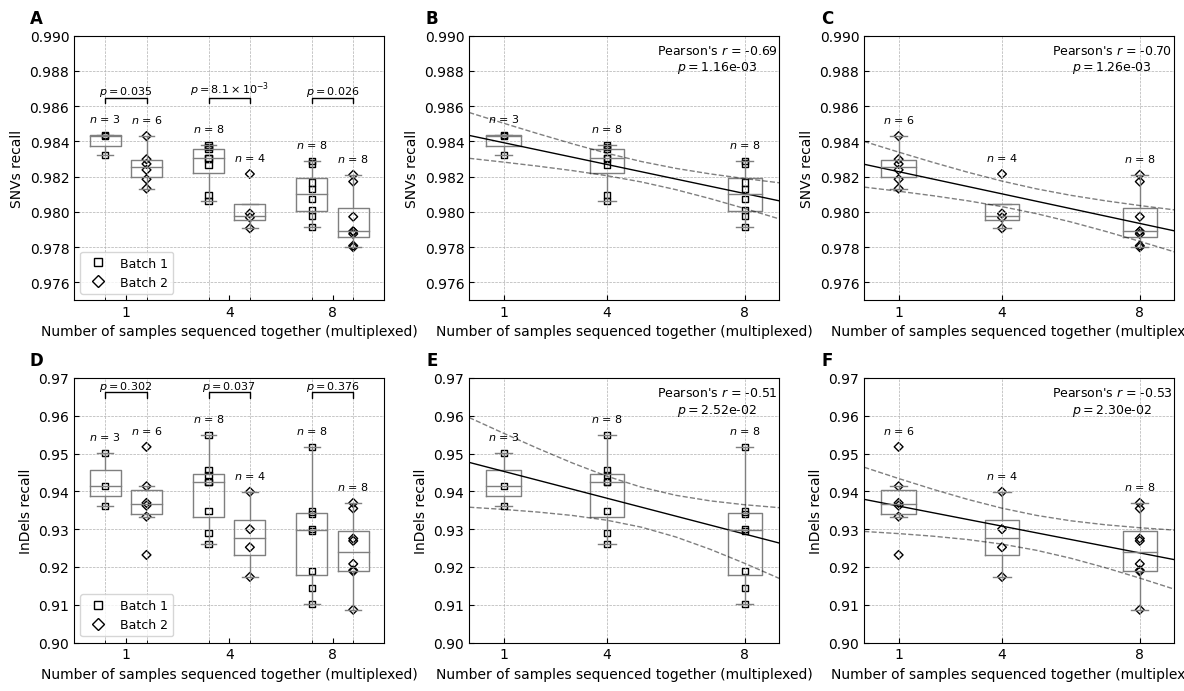

In [12]:
plt.style.use('default')
fig = plt.figure(figsize=(12, 7), dpi = 100)

df_snvs = df_variants[(df_variants.Type == 'SNP') & (df_variants.Filter == 'ALL')]
df_indels = df_variants[(df_variants.Type == 'INDEL') & (df_variants.Filter == 'ALL')]


# FIGURE A.
# ================== #
ax = fig.add_subplot(2, 3, 1)

batches = [1, 2]
batch_colors = { 1: 'tab:blue', 2: 'tab:orange' }
batch_markers = { 1: 's', 2: 'D' }
batch_offsets = { 1: -0.2, 2: 0.2 }
plexings = [1, 4, 8]
plexing_positions = [1, 2, 3]

# scatter plot
for batch in batches:
    for x, plexing in zip(plexing_positions, plexings):
        df_snvs_temp = df_snvs[(df_snvs.Batch == batch) & (df_snvs.Plexing == plexing)]
        ax.scatter([x + batch_offsets[batch]] * len(df_snvs_temp), df_snvs_temp.Recall, 
                marker = batch_markers[batch], edgecolor = 'black', facecolor = 'none', s = 20)

# boxplots
bp_data = {1: [], 2: []}
bp_positions = {1: [], 2: []}
bp_colors = {1: [0.122, 0.467, 0.706, 0.1], 2: [1.00, 0.498, 0.055, 0.1]}
for batch in batches:
    for x, plexing in zip(plexing_positions, plexings):
        df_snvs_temp = df_snvs[(df_snvs.Batch == batch) & (df_snvs.Plexing == plexing)]
        bp_positions[batch].append(x + batch_offsets[batch])
        bp_data[batch].append(df_snvs_temp.Recall)
    bx = ax.boxplot(bp_data[batch], positions = bp_positions[batch], widths = 0.3,
                showfliers = False, showmeans = False, 
                medianprops = {'color': 'tab:grey'},
                boxprops = {'color': 'tab:grey'},
                whiskerprops={'color': 'tab:grey'}, 
                capprops={'color': 'tab:grey'})
    
# Limits. Must be set before text annotations.
ax.set_xlim([0.5,  3.5])
ax.set_ylim([0.975,  0.99])

# Grid & ticks
ax.tick_params(axis = 'both', direction = 'in', which = 'both')
ax.set_xticks([x + batch_offsets[1] for x in plexing_positions] + [x + batch_offsets[2] for x in plexing_positions], minor = True)
ax.xaxis.grid(True, which = 'minor', linestyle = '--', linewidth = 0.5)
ax.yaxis.grid(True, which = 'major', linestyle = '--', linewidth = 0.5)
ax.set_xticks(plexing_positions)
ax.set_xticklabels(plexings)

# Text annotations
for batch in batches:
    for x, data in zip(bp_positions[batch], bp_data[batch]):
        annotate_sample_size(ax, x, data, 10)
        
legend_elements = [
    Line2D([0], [0], marker = batch_markers[1], markeredgecolor = 'black', markerfacecolor = 'none', color = 'none', label='Batch 1'), 
    Line2D([0], [0], marker = batch_markers[2], markeredgecolor = 'black', markerfacecolor = 'none', color = 'none', label='Batch 2')
]
ax.legend(handles = legend_elements, loc = 3, prop = {'size': 9})

ax.set_ylabel('SNVs recall')
ax.set_xlabel('Number of samples sequenced together (multiplexed)')

for i, x in enumerate(plexing_positions, 0):
    pvalue = stats.mannwhitneyu(bp_data[1][i], bp_data[2][i], alternative = "greater")[1]
    annotate_pvalue(ax, x - 0.2, x + 0.2, 0.986, pvalue, 0.20)
ax.text(-0.1, 1.1, 'A', transform = ax.transAxes, fontsize = 12, fontweight = 'bold', va = 'top', ha = 'right')


# FIGURE B.
# ================== #
ax = fig.add_subplot(2, 3, 2)

df_snvs1 = df_snvs[df_snvs.Batch == 1].copy()

# Run regression model
model = smf.ols('Recall ~ Plexing', df_snvs1)
res = model.fit()

a = res.params['Intercept']
b = res.params['Plexing']
model_pvalue = res.pvalues['Plexing']

# Compute Pearson's correlation
corr, corr_pvalue = stats.pearsonr(df_snvs1.Recall, df_snvs1.Plexing)

# scatter plot
ax.scatter(df_snvs1.Plexing, df_snvs1.Recall, marker = batch_markers[1], edgecolor = 'black', facecolor = 'none', s = 20)

# boxplots
bp_data = []
bp_positions = []
for plexing in sorted(df_snvs1.Plexing.unique()):
    bp_positions.append(plexing)
    bp_data.append(df_snvs1[df_snvs1.Plexing == plexing].Recall)
ax.boxplot(bp_data, positions = bp_positions, widths = 1, 
                showfliers = False, showmeans = False, 
                medianprops = {'color': 'tab:grey'},
                boxprops = {'color': 'tab:grey'},
                whiskerprops={'color': 'tab:grey'}, 
                capprops={'color': 'tab:grey'})

# Regression line and confidence intervals
xs = [ x for x in range(0, 10) ]
ax.plot(xs, [a + b * x for x in xs], color = 'black', linewidth = 1)
pred_summary = res.get_prediction(pd.DataFrame({'Plexing': xs})).summary_frame(alpha=0.05)
ax.plot(xs, pred_summary.mean_ci_lower, color = 'black', linestyle = '--', linewidth = 1, alpha = 0.5)
ax.plot(xs, pred_summary.mean_ci_upper, color = 'black', linestyle = '--', linewidth = 1, alpha = 0.5)

# Limits. Must be set before text annotations.
ax.set_xlim([0,  9])
ax.set_ylim([0.975,  0.99])

# Grid & ticks
ax.tick_params(axis = 'both', direction = 'in')
ax.grid(linestyle = '--', linewidth = 0.5)

# Text annotations
ax.set_ylabel('SNVs recall')
ax.set_xlabel('Number of samples sequenced together (multiplexed)')

for x, data in zip(bp_positions, bp_data):
    annotate_sample_size(ax, x, data, 10)
ax.annotate(
    f'Pearson\'s ' + r'$\it{r}$ = ' + f'{corr:.2f}\n' + r'$\it{p}=$' + f'{corr_pvalue:.2e}', 
    (0.8, 0.85), xycoords=ax.transAxes, fontsize = 9, ha='center', va='bottom')
ax.text(-0.1, 1.1, 'B', transform = ax.transAxes, fontsize = 12, fontweight = 'bold', va = 'top', ha = 'right')


# FIGURE C.
# ================== #
ax = fig.add_subplot(2, 3, 3)

df_snvs2 = df_snvs[df_snvs.Batch == 2].copy()

# Run regression model
model = smf.ols('Recall ~ Plexing', df_snvs2)
res = model.fit()
a = res.params['Intercept']
b = res.params['Plexing']
model_pvalue = res.pvalues['Plexing']

# Compute Pearson's correlation
corr, corr_pvalue = stats.pearsonr(df_snvs2.Recall, df_snvs2.Plexing)

# scatter plot
ax.scatter(df_snvs2.Plexing, df_snvs2.Recall, marker = batch_markers[2], edgecolor = 'black', facecolor = 'none', s = 20)

# boxplots
bp_data = []
bp_positions = []
for plexing in sorted(df_snvs2.Plexing.unique()):
    bp_positions.append(plexing)
    bp_data.append(df_snvs2[df_snvs2.Plexing == plexing].Recall)
ax.boxplot(bp_data, positions = bp_positions, widths = 1, 
                showfliers = False, showmeans = False, 
                medianprops = {'color': 'tab:grey'},
                boxprops = {'color': 'tab:grey'},
                whiskerprops={'color': 'tab:grey'}, 
                capprops={'color': 'tab:grey'})

# Regression line and confidence intervals
xs = [ x for x in range(0, 10) ]
ax.plot(xs, [a + b * x for x in xs], color = 'black', linewidth = 1)
pred_summary = res.get_prediction(pd.DataFrame({'Plexing': xs})).summary_frame(alpha=0.05)
ax.plot(xs, pred_summary.mean_ci_lower, color = 'black', linestyle = '--', linewidth = 1, alpha = 0.5)
ax.plot(xs, pred_summary.mean_ci_upper, color = 'black', linestyle = '--', linewidth = 1, alpha = 0.5)

# Limits. Must be set before text annotations.
ax.set_xlim([0,  9])
ax.set_ylim([0.975,  0.99])

# Grid & ticks
ax.tick_params(axis = 'both', direction = 'in')
ax.grid(linestyle = '--', linewidth = 0.5)

# Text annotations
ax.set_ylabel('SNVs recall')
ax.set_xlabel('Number of samples sequenced together (multiplexed)')

for x, data in zip(bp_positions, bp_data):
    annotate_sample_size(ax, x, data, 10)
ax.annotate(
    f'Pearson\'s ' + r'$\it{r}$ = ' + f'{corr:.2f}\n' + r'$\it{p}=$' + f'{corr_pvalue:.2e}', 
    (0.8, 0.85), xycoords=ax.transAxes, fontsize = 9, ha='center', va='bottom')
ax.text(-0.1, 1.1, 'C', transform = ax.transAxes, fontsize = 12, fontweight = 'bold', va = 'top', ha = 'right')


# FIGURE D.
# ================== #
ax = fig.add_subplot(2, 3, 4)

batches = [1, 2]
batch_colors = { 1: 'tab:blue', 2: 'tab:orange' }
batch_markers = { 1: 's', 2: 'D' }
batch_offsets = { 1: -0.2, 2: 0.2 }
plexings = [1, 4, 8]
plexing_positions = [1, 2, 3]

# scatter plot
for batch in batches:
    for x, plexing in zip(plexing_positions, plexings):
        df_indels_temp = df_indels[(df_indels.Batch == batch) & (df_indels.Plexing == plexing)]
        ax.scatter([x + batch_offsets[batch]] * len(df_indels_temp), df_indels_temp.Recall, 
                marker = batch_markers[batch], edgecolor = 'black', facecolor = 'none', s = 20)

# boxplots
bp_data = {1: [], 2: []}
bp_positions = {1: [], 2: []}
bp_colors = {1: [0.122, 0.467, 0.706, 0.1], 2: [1.00, 0.498, 0.055, 0.1]}
for batch in batches:
    for x, plexing in zip(plexing_positions, plexings):
        df_indels_temp = df_indels[(df_indels.Batch == batch) & (df_indels.Plexing == plexing)]
        bp_positions[batch].append(x + batch_offsets[batch])
        bp_data[batch].append(df_indels_temp.Recall)
    bx = ax.boxplot(bp_data[batch], positions = bp_positions[batch], widths = 0.3,
                showfliers = False, showmeans = False, 
                medianprops = {'color': 'tab:grey'},
                boxprops = {'color': 'tab:grey'},
                whiskerprops={'color': 'tab:grey'}, 
                capprops={'color': 'tab:grey'})
    
# Limits. Must be set before text annotations.
ax.set_xlim([0.5,  3.5])
ax.set_ylim([0.90,  0.97])

# Grid & ticks
ax.tick_params(axis = 'both', direction = 'in', which = 'both')
ax.set_xticks([x + batch_offsets[1] for x in plexing_positions] + [x + batch_offsets[2] for x in plexing_positions], minor = True)
ax.xaxis.grid(True, which = 'minor', linestyle = '--', linewidth = 0.5)
ax.yaxis.grid(True, which = 'major', linestyle = '--', linewidth = 0.5)
ax.set_xticks(plexing_positions)
ax.set_xticklabels(plexings)

# Text annotations
for batch in batches:
    for x, data in zip(bp_positions[batch], bp_data[batch]):
        annotate_sample_size(ax, x, data, 10)
        
legend_elements = [
    Line2D([0], [0], marker = batch_markers[1], markeredgecolor = 'black', markerfacecolor = 'none', color = 'none', label='Batch 1'), 
    Line2D([0], [0], marker = batch_markers[2], markeredgecolor = 'black', markerfacecolor = 'none', color = 'none', label='Batch 2')
]
ax.legend(handles = legend_elements, loc = 3, prop = {'size': 9})

ax.set_ylabel('InDels recall')
ax.set_xlabel('Number of samples sequenced together (multiplexed)')

for i, x in enumerate(plexing_positions, 0):
    pvalue = stats.mannwhitneyu(bp_data[1][i], bp_data[2][i], alternative = "greater")[1]
    annotate_pvalue(ax, x - 0.2, x + 0.2, 0.964, pvalue, 0.20)
ax.text(-0.1, 1.1, 'D', transform = ax.transAxes, fontsize = 12, fontweight = 'bold', va = 'top', ha = 'right')


# FIGURE E.
# ================== #
ax = fig.add_subplot(2, 3, 5)

df_indels1 = df_indels[df_indels.Batch == 1].copy()

# Run regression model
model = smf.ols('Recall ~ Plexing', df_indels1)
res = model.fit()

a = res.params['Intercept']
b = res.params['Plexing']
model_pvalue = res.pvalues['Plexing']

# Compute Pearson's correlation
corr, corr_pvalue = stats.pearsonr(df_indels1.Recall, df_indels1.Plexing)

# scatter plot
ax.scatter(df_indels1.Plexing, df_indels1.Recall, marker = batch_markers[1], edgecolor = 'black', facecolor = 'none', s = 20)

# boxplots
bp_data = []
bp_positions = []
for plexing in sorted(df_indels1.Plexing.unique()):
    bp_positions.append(plexing)
    bp_data.append(df_indels1[df_indels1.Plexing == plexing].Recall)
ax.boxplot(bp_data, positions = bp_positions, widths = 1, 
                showfliers = False, showmeans = False, 
                medianprops = {'color': 'tab:grey'},
                boxprops = {'color': 'tab:grey'},
                whiskerprops={'color': 'tab:grey'}, 
                capprops={'color': 'tab:grey'})

# Regression line and confidence intervals
xs = [ x for x in range(0, 10) ]
ax.plot(xs, [a + b * x for x in xs], color = 'black', linewidth = 1)
pred_summary = res.get_prediction(pd.DataFrame({'Plexing': xs})).summary_frame(alpha=0.05)
ax.plot(xs, pred_summary.mean_ci_lower, color = 'black', linestyle = '--', linewidth = 1, alpha = 0.5)
ax.plot(xs, pred_summary.mean_ci_upper, color = 'black', linestyle = '--', linewidth = 1, alpha = 0.5)

# Limits. Must be set before text annotations.
ax.set_xlim([0,  9])
ax.set_ylim([0.90,  0.97])

# Grid & ticks
ax.tick_params(axis = 'both', direction = 'in')
ax.grid(linestyle = '--', linewidth = 0.5)

# Text annotations
ax.set_ylabel('InDels recall')
ax.set_xlabel('Number of samples sequenced together (multiplexed)')

for x, data in zip(bp_positions, bp_data):
    annotate_sample_size(ax, x, data, 10)
ax.annotate(
    f'Pearson\'s ' + r'$\it{r}$ = ' + f'{corr:.2f}\n' + r'$\it{p}=$' + f'{corr_pvalue:.2e}', 
    (0.8, 0.85), xycoords=ax.transAxes, fontsize = 9, ha='center', va='bottom')
ax.text(-0.1, 1.1, 'E', transform = ax.transAxes, fontsize = 12, fontweight = 'bold', va = 'top', ha = 'right')


# FIGURE F.
# ================== #
ax = fig.add_subplot(2, 3, 6)

df_indels2 = df_indels[df_indels.Batch == 2].copy()

# Run regression model
model = smf.ols('Recall ~ Plexing', df_indels2)
res = model.fit()
a = res.params['Intercept']
b = res.params['Plexing']
model_pvalue = res.pvalues['Plexing']

# Compute Pearson's correlation
corr, corr_pvalue = stats.pearsonr(df_indels2.Recall, df_indels2.Plexing)

# scatter plot
ax.scatter(df_indels2.Plexing, df_indels2.Recall, marker = batch_markers[2], edgecolor = 'black', facecolor = 'none', s = 20)

# boxplots
bp_data = []
bp_positions = []
for plexing in sorted(df_indels2.Plexing.unique()):
    bp_positions.append(plexing)
    bp_data.append(df_indels2[df_indels2.Plexing == plexing].Recall)
ax.boxplot(bp_data, positions = bp_positions, widths = 1, 
                showfliers = False, showmeans = False, 
                medianprops = {'color': 'tab:grey'},
                boxprops = {'color': 'tab:grey'},
                whiskerprops={'color': 'tab:grey'}, 
                capprops={'color': 'tab:grey'})

# Regression line and confidence intervals
xs = [ x for x in range(0, 10) ]
ax.plot(xs, [a + b * x for x in xs], color = 'black', linewidth = 1)
pred_summary = res.get_prediction(pd.DataFrame({'Plexing': xs})).summary_frame(alpha=0.05)
ax.plot(xs, pred_summary.mean_ci_lower, color = 'black', linestyle = '--', linewidth = 1, alpha = 0.5)
ax.plot(xs, pred_summary.mean_ci_upper, color = 'black', linestyle = '--', linewidth = 1, alpha = 0.5)

# Limits. Must be set before text annotations.
ax.set_xlim([0,  9])
ax.set_ylim([0.90,  0.97])

# Grid & ticks
ax.tick_params(axis = 'both', direction = 'in')
ax.grid(linestyle = '--', linewidth = 0.5)

# Text annotations
ax.set_ylabel('InDels recall')
ax.set_xlabel('Number of samples sequenced together (multiplexed)')

for x, data in zip(bp_positions, bp_data):
    annotate_sample_size(ax, x, data, 10)
ax.annotate(
    f'Pearson\'s ' + r'$\it{r}$ = ' + f'{corr:.2f}\n' + r'$\it{p}=$' + f'{corr_pvalue:.2e}', 
    (0.8, 0.85), xycoords=ax.transAxes, fontsize = 9, ha='center', va='bottom')
ax.text(-0.1, 1.1, 'F', transform = ax.transAxes, fontsize = 12, fontweight = 'bold', va = 'top', ha = 'right')

plt.tight_layout()
plt.show()



### FIGURE: The precision of the SNVs and InDels called in sequencing experiments without and with multiplexing stratified by library preparation batch.

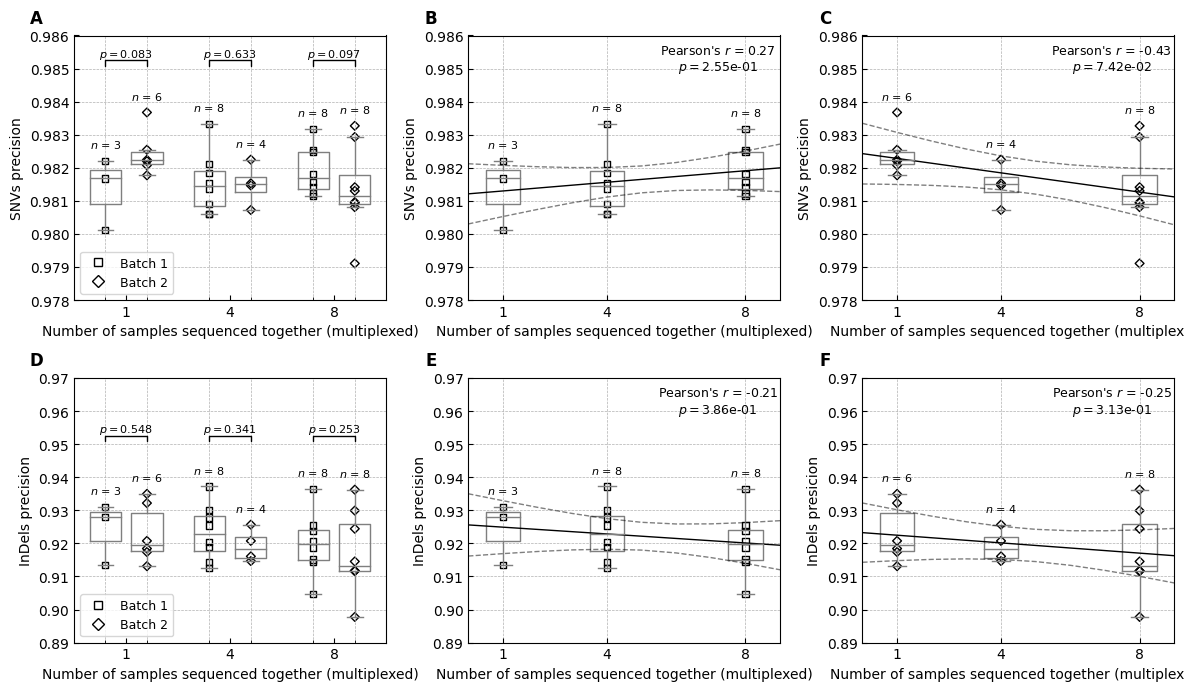

In [13]:
plt.style.use('default')
fig = plt.figure(figsize=(12, 7), dpi = 100)

df_snvs = df_variants[(df_variants.Type == 'SNP') & (df_variants.Filter == 'ALL')]
df_indels = df_variants[(df_variants.Type == 'INDEL') & (df_variants.Filter == 'ALL')]

# FIGURE A.
# ================= #
ax = fig.add_subplot(2, 3, 1)

batches = [1, 2]
batch_colors = { 1: 'tab:blue', 2: 'tab:orange' }
batch_markers = { 1: 's', 2: 'D' }
batch_offsets = { 1: -0.2, 2: 0.2 }
plexings = [1, 4, 8]
plexing_positions = [1, 2, 3]

# scatter plot
for batch in batches:
    for x, plexing in zip(plexing_positions, plexings):
        df_snvs_temp = df_snvs[(df_snvs.Batch == batch) & (df_snvs.Plexing == plexing)]
        ax.scatter([x + batch_offsets[batch]] * len(df_snvs_temp), df_snvs_temp.Precision, 
                marker = batch_markers[batch], edgecolor = 'black', facecolor = 'none', s = 20)

# boxplots
bp_data = {1: [], 2: []}
bp_positions = {1: [], 2: []}
bp_colors = {1: [0.122, 0.467, 0.706, 0.1], 2: [1.00, 0.498, 0.055, 0.1]}
for batch in batches:
    for x, plexing in zip(plexing_positions, plexings):
        df_snvs_temp = df_snvs[(df_snvs.Batch == batch) & (df_snvs.Plexing == plexing)]
        bp_positions[batch].append(x + batch_offsets[batch])
        bp_data[batch].append(df_snvs_temp.Precision)
    bx = ax.boxplot(bp_data[batch], positions = bp_positions[batch], widths = 0.3,
                showfliers = False, showmeans = False, 
                medianprops = {'color': 'tab:grey'},
                boxprops = {'color': 'tab:grey'},
                whiskerprops={'color': 'tab:grey'}, 
                capprops={'color': 'tab:grey'})
    
# Limits. Must be set before text annotations.
ax.set_xlim([0.5,  3.5])
ax.set_ylim([0.978,  0.986])

# Grid & ticks
ax.tick_params(axis = 'both', direction = 'in', which = 'both')
ax.set_xticks([x + batch_offsets[1] for x in plexing_positions] + [x + batch_offsets[2] for x in plexing_positions], minor = True)
ax.xaxis.grid(True, which = 'minor', linestyle = '--', linewidth = 0.5)
ax.yaxis.grid(True, which = 'major', linestyle = '--', linewidth = 0.5)
ax.set_xticks(plexing_positions)
ax.set_xticklabels(plexings)

# Text annotations
for batch in batches:
    for x, data in zip(bp_positions[batch], bp_data[batch]):
        annotate_sample_size(ax, x, data, 10)
        
legend_elements = [
    Line2D([0], [0], marker = batch_markers[1], markeredgecolor = 'black', markerfacecolor = 'none', color = 'none', label='Batch 1'), 
    Line2D([0], [0], marker = batch_markers[2], markeredgecolor = 'black', markerfacecolor = 'none', color = 'none', label='Batch 2')
]
ax.legend(handles = legend_elements, loc = 3, prop = {'size': 9})

ax.set_ylabel('SNVs precision')
ax.set_xlabel('Number of samples sequenced together (multiplexed)')

for i, x in enumerate(plexing_positions, 0):
    if np.mean(bp_data[1][i]) >= np.mean(bp_data[2][i]):
        pvalue = stats.mannwhitneyu(bp_data[1][i], bp_data[2][i], alternative = "greater")[1]
    else:
        pvalue = stats.mannwhitneyu(bp_data[2][i], bp_data[1][i], alternative = "greater")[1]
    annotate_pvalue(ax, x - 0.2, x + 0.2, 0.985, pvalue, 0.20)
ax.text(-0.1, 1.1, 'A', transform = ax.transAxes, fontsize = 12, fontweight = 'bold', va = 'top', ha = 'right')


# FIGURE B.
# ================= #
ax = fig.add_subplot(2, 3, 2)

df_snvs1 = df_snvs[df_snvs.Batch == 1].copy()

# Run regression model
model = smf.ols('Precision ~ Plexing', df_snvs1)
res = model.fit()

a = res.params['Intercept']
b = res.params['Plexing']
model_pvalue = res.pvalues['Plexing']

# Compute Pearson's correlation
corr, corr_pvalue = stats.pearsonr(df_snvs1.Precision, df_snvs1.Plexing)

# scatter plot
ax.scatter(df_snvs1.Plexing, df_snvs1.Precision, marker = batch_markers[1], edgecolor = 'black', facecolor = 'none', s = 20)

# boxplots
bp_data = []
bp_positions = []
for plexing in sorted(df_snvs1.Plexing.unique()):
    bp_positions.append(plexing)
    bp_data.append(df_snvs1[df_snvs1.Plexing == plexing].Precision)
ax.boxplot(bp_data, positions = bp_positions, widths = 1, 
                showfliers = False, showmeans = False, 
                medianprops = {'color': 'tab:grey'},
                boxprops = {'color': 'tab:grey'},
                whiskerprops={'color': 'tab:grey'}, 
                capprops={'color': 'tab:grey'})

# Regression line and confidence intervals
xs = [ x for x in range(0, 10) ]
ax.plot(xs, [a + b * x for x in xs], color = 'black', linewidth = 1)
pred_summary = res.get_prediction(pd.DataFrame({'Plexing': xs})).summary_frame(alpha=0.05)
ax.plot(xs, pred_summary.mean_ci_lower, color = 'black', linestyle = '--', linewidth = 1, alpha = 0.5)
ax.plot(xs, pred_summary.mean_ci_upper, color = 'black', linestyle = '--', linewidth = 1, alpha = 0.5)

# Limits. Must be set before text annotations.
ax.set_xlim([0,  9])
ax.set_ylim([0.978,  0.986])

# Grid & ticks
ax.tick_params(axis = 'both', direction = 'in')
ax.grid(linestyle = '--', linewidth = 0.5)

# Text annotations
ax.set_ylabel('SNVs precision')
ax.set_xlabel('Number of samples sequenced together (multiplexed)')

for x, data in zip(bp_positions, bp_data):
    annotate_sample_size(ax, x, data, 10)
ax.annotate(
    f'Pearson\'s ' + r'$\it{r}$ = ' + f'{corr:.2f}\n' + r'$\it{p}=$' + f'{corr_pvalue:.2e}', 
    (0.8, 0.85), xycoords=ax.transAxes, fontsize = 9, ha='center', va='bottom')
ax.text(-0.1, 1.1, 'B', transform = ax.transAxes, fontsize = 12, fontweight = 'bold', va = 'top', ha = 'right')


# FIGURE C.
# ================= #
ax = fig.add_subplot(2, 3, 3)

df_snvs2 = df_snvs[df_snvs.Batch == 2].copy()

# Run regression model
model = smf.ols('Precision ~ Plexing', df_snvs2)
res = model.fit()
a = res.params['Intercept']
b = res.params['Plexing']
model_pvalue = res.pvalues['Plexing']

# Compute Pearson's correlation
corr, corr_pvalue = stats.pearsonr(df_snvs2.Precision, df_snvs2.Plexing)

# scatter plot
ax.scatter(df_snvs2.Plexing, df_snvs2.Precision, marker = batch_markers[2], edgecolor = 'black', facecolor = 'none', s = 20)

# boxplots
bp_data = []
bp_positions = []
for plexing in sorted(df_snvs2.Plexing.unique()):
    bp_positions.append(plexing)
    bp_data.append(df_snvs2[df_snvs2.Plexing == plexing].Precision)
ax.boxplot(bp_data, positions = bp_positions, widths = 1, 
                showfliers = False, showmeans = False, 
                medianprops = {'color': 'tab:grey'},
                boxprops = {'color': 'tab:grey'},
                whiskerprops={'color': 'tab:grey'}, 
                capprops={'color': 'tab:grey'})

# Regression line and confidence intervals
xs = [ x for x in range(0, 10) ]
ax.plot(xs, [a + b * x for x in xs], color = 'black', linewidth = 1)
pred_summary = res.get_prediction(pd.DataFrame({'Plexing': xs})).summary_frame(alpha=0.05)
ax.plot(xs, pred_summary.mean_ci_lower, color = 'black', linestyle = '--', linewidth = 1, alpha = 0.5)
ax.plot(xs, pred_summary.mean_ci_upper, color = 'black', linestyle = '--', linewidth = 1, alpha = 0.5)

# Limits. Must be set before text annotations.
ax.set_xlim([0,  9])
ax.set_ylim([0.978,  0.986])

# Grid & ticks
ax.tick_params(axis = 'both', direction = 'in')
ax.grid(linestyle = '--', linewidth = 0.5)

# Text annotations
ax.set_ylabel('SNVs precision')
ax.set_xlabel('Number of samples sequenced together (multiplexed)')

for x, data in zip(bp_positions, bp_data):
    annotate_sample_size(ax, x, data, 10)
ax.annotate(
    f'Pearson\'s ' + r'$\it{r}$ = ' + f'{corr:.2f}\n' + r'$\it{p}=$' + f'{corr_pvalue:.2e}', 
    (0.8, 0.85), xycoords=ax.transAxes, fontsize = 9, ha='center', va='bottom')
ax.text(-0.1, 1.1, 'C', transform = ax.transAxes, fontsize = 12, fontweight = 'bold', va = 'top', ha = 'right')



# FIGURE D.
# ================= #
ax = fig.add_subplot(2, 3, 4)

batches = [1, 2]
batch_colors = { 1: 'tab:blue', 2: 'tab:orange' }
batch_markers = { 1: 's', 2: 'D' }
batch_offsets = { 1: -0.2, 2: 0.2 }
plexings = [1, 4, 8]
plexing_positions = [1, 2, 3]

# scatter plot
for batch in batches:
    for x, plexing in zip(plexing_positions, plexings):
        df_indels_temp = df_indels[(df_indels.Batch == batch) & (df_indels.Plexing == plexing)]
        ax.scatter([x + batch_offsets[batch]] * len(df_indels_temp), df_indels_temp.Precision, 
                marker = batch_markers[batch], edgecolor = 'black', facecolor = 'none', s = 20)

# boxplots
bp_data = {1: [], 2: []}
bp_positions = {1: [], 2: []}
bp_colors = {1: [0.122, 0.467, 0.706, 0.1], 2: [1.00, 0.498, 0.055, 0.1]}
for batch in batches:
    for x, plexing in zip(plexing_positions, plexings):
        df_indels_temp = df_indels[(df_indels.Batch == batch) & (df_indels.Plexing == plexing)]
        bp_positions[batch].append(x + batch_offsets[batch])
        bp_data[batch].append(df_indels_temp.Precision)
    bx = ax.boxplot(bp_data[batch], positions = bp_positions[batch], widths = 0.3,
                showfliers = False, showmeans = False, 
                medianprops = {'color': 'tab:grey'},
                boxprops = {'color': 'tab:grey'},
                whiskerprops={'color': 'tab:grey'}, 
                capprops={'color': 'tab:grey'})
    
# Limits. Must be set before text annotations.
ax.set_xlim([0.5,  3.5])
ax.set_ylim([0.89,  0.97])

# Grid & ticks
ax.tick_params(axis = 'both', direction = 'in', which = 'both')
ax.set_xticks([x + batch_offsets[1] for x in plexing_positions] + [x + batch_offsets[2] for x in plexing_positions], minor = True)
ax.xaxis.grid(True, which = 'minor', linestyle = '--', linewidth = 0.5)
ax.yaxis.grid(True, which = 'major', linestyle = '--', linewidth = 0.5)
ax.set_xticks(plexing_positions)
ax.set_xticklabels(plexings)

# Text annotations
for batch in batches:
    for x, data in zip(bp_positions[batch], bp_data[batch]):
        annotate_sample_size(ax, x, data, 10)
        
legend_elements = [
    Line2D([0], [0], marker = batch_markers[1], markeredgecolor = 'black', markerfacecolor = 'none', color = 'none', label='Batch 1'), 
    Line2D([0], [0], marker = batch_markers[2], markeredgecolor = 'black', markerfacecolor = 'none', color = 'none', label='Batch 2')
]
ax.legend(handles = legend_elements, loc = 3, prop = {'size': 9})

ax.set_ylabel('InDels precision')
ax.set_xlabel('Number of samples sequenced together (multiplexed)')

for i, x in enumerate(plexing_positions, 0):
    if np.mean(bp_data[1][i]) >= np.mean(bp_data[2][i]):
        pvalue = stats.mannwhitneyu(bp_data[1][i], bp_data[2][i], alternative = "greater")[1]
    else:
        pvalue = stats.mannwhitneyu(bp_data[2][i], bp_data[1][i], alternative = "greater")[1]
    annotate_pvalue(ax, x - 0.2, x + 0.2, 0.95, pvalue, 0.20)
ax.text(-0.1, 1.1, 'D', transform = ax.transAxes, fontsize = 12, fontweight = 'bold', va = 'top', ha = 'right')


# FIGURE E.
# ================= #
ax = fig.add_subplot(2, 3, 5)

df_indels1 = df_indels[df_indels.Batch == 1].copy()

# Run regression model
model = smf.ols('Precision ~ Plexing', df_indels1)
res = model.fit()

a = res.params['Intercept']
b = res.params['Plexing']
model_pvalue = res.pvalues['Plexing']

# Compute Pearson's correlation
corr, corr_pvalue = stats.pearsonr(df_indels1.Precision, df_indels1.Plexing)

# scatter plot
ax.scatter(df_indels1.Plexing, df_indels1.Precision, marker = batch_markers[1], edgecolor = 'black', facecolor = 'none', s = 20)

# boxplots
bp_data = []
bp_positions = []
for plexing in sorted(df_indels1.Plexing.unique()):
    bp_positions.append(plexing)
    bp_data.append(df_indels1[df_indels1.Plexing == plexing].Precision)
ax.boxplot(bp_data, positions = bp_positions, widths = 1, 
                showfliers = False, showmeans = False, 
                medianprops = {'color': 'tab:grey'},
                boxprops = {'color': 'tab:grey'},
                whiskerprops={'color': 'tab:grey'}, 
                capprops={'color': 'tab:grey'})

# Regression line and confidence intervals
xs = [ x for x in range(0, 10) ]
ax.plot(xs, [a + b * x for x in xs], color = 'black', linewidth = 1)
pred_summary = res.get_prediction(pd.DataFrame({'Plexing': xs})).summary_frame(alpha=0.05)
ax.plot(xs, pred_summary.mean_ci_lower, color = 'black', linestyle = '--', linewidth = 1, alpha = 0.5)
ax.plot(xs, pred_summary.mean_ci_upper, color = 'black', linestyle = '--', linewidth = 1, alpha = 0.5)

# Limits. Must be set before text annotations.
ax.set_xlim([0,  9])
ax.set_ylim([0.89,  0.97])

# Grid & ticks
ax.tick_params(axis = 'both', direction = 'in')
ax.grid(linestyle = '--', linewidth = 0.5)

# Text annotations
ax.set_ylabel('InDels precision')
ax.set_xlabel('Number of samples sequenced together (multiplexed)')

for x, data in zip(bp_positions, bp_data):
    annotate_sample_size(ax, x, data, 10)
ax.annotate(
    f'Pearson\'s ' + r'$\it{r}$ = ' + f'{corr:.2f}\n' + r'$\it{p}=$' + f'{corr_pvalue:.2e}', 
    (0.8, 0.85), xycoords=ax.transAxes, fontsize = 9, ha='center', va='bottom')
ax.text(-0.1, 1.1, 'E', transform = ax.transAxes, fontsize = 12, fontweight = 'bold', va = 'top', ha = 'right')


# FIGURE F.
# ================= #
ax = fig.add_subplot(2, 3, 6)

df_indels2 = df_indels[df_indels.Batch == 2].copy()

# Run regression model
model = smf.ols('Precision ~ Plexing', df_indels2)
res = model.fit()
a = res.params['Intercept']
b = res.params['Plexing']
model_pvalue = res.pvalues['Plexing']

# Compute Pearson's correlation
corr, corr_pvalue = stats.pearsonr(df_indels2.Precision, df_indels2.Plexing)

# scatter plot
ax.scatter(df_indels2.Plexing, df_indels2.Precision, marker = batch_markers[2], edgecolor = 'black', facecolor = 'none', s = 20)

# boxplots
bp_data = []
bp_positions = []
for plexing in sorted(df_indels2.Plexing.unique()):
    bp_positions.append(plexing)
    bp_data.append(df_indels2[df_indels2.Plexing == plexing].Precision)
ax.boxplot(bp_data, positions = bp_positions, widths = 1, 
                showfliers = False, showmeans = False, 
                medianprops = {'color': 'tab:grey'},
                boxprops = {'color': 'tab:grey'},
                whiskerprops={'color': 'tab:grey'}, 
                capprops={'color': 'tab:grey'})

# Regression line and confidence intervals
xs = [ x for x in range(0, 10) ]
ax.plot(xs, [a + b * x for x in xs], color = 'black', linewidth = 1)
pred_summary = res.get_prediction(pd.DataFrame({'Plexing': xs})).summary_frame(alpha=0.05)
ax.plot(xs, pred_summary.mean_ci_lower, color = 'black', linestyle = '--', linewidth = 1, alpha = 0.5)
ax.plot(xs, pred_summary.mean_ci_upper, color = 'black', linestyle = '--', linewidth = 1, alpha = 0.5)

# Limits. Must be set before text annotations.
ax.set_xlim([0,  9])
ax.set_ylim([0.89,  0.97])

# Grid & ticks
ax.tick_params(axis = 'both', direction = 'in')
ax.grid(linestyle = '--', linewidth = 0.5)

# Text annotations
ax.set_ylabel('InDels presicion')
ax.set_xlabel('Number of samples sequenced together (multiplexed)')

for x, data in zip(bp_positions, bp_data):
    annotate_sample_size(ax, x, data, 10)
ax.annotate(
    f'Pearson\'s ' + r'$\it{r}$ = ' + f'{corr:.2f}\n' + r'$\it{p}=$' + f'{corr_pvalue:.2e}', 
    (0.8, 0.85), xycoords=ax.transAxes, fontsize = 9, ha='center', va='bottom')
ax.text(-0.1, 1.1, 'F', transform = ax.transAxes, fontsize = 12, fontweight = 'bold', va = 'top', ha = 'right')

plt.tight_layout()
plt.show()

### FIGURE: Number of SNV and InDel calls in sequencing experiments without and with multiplexing.

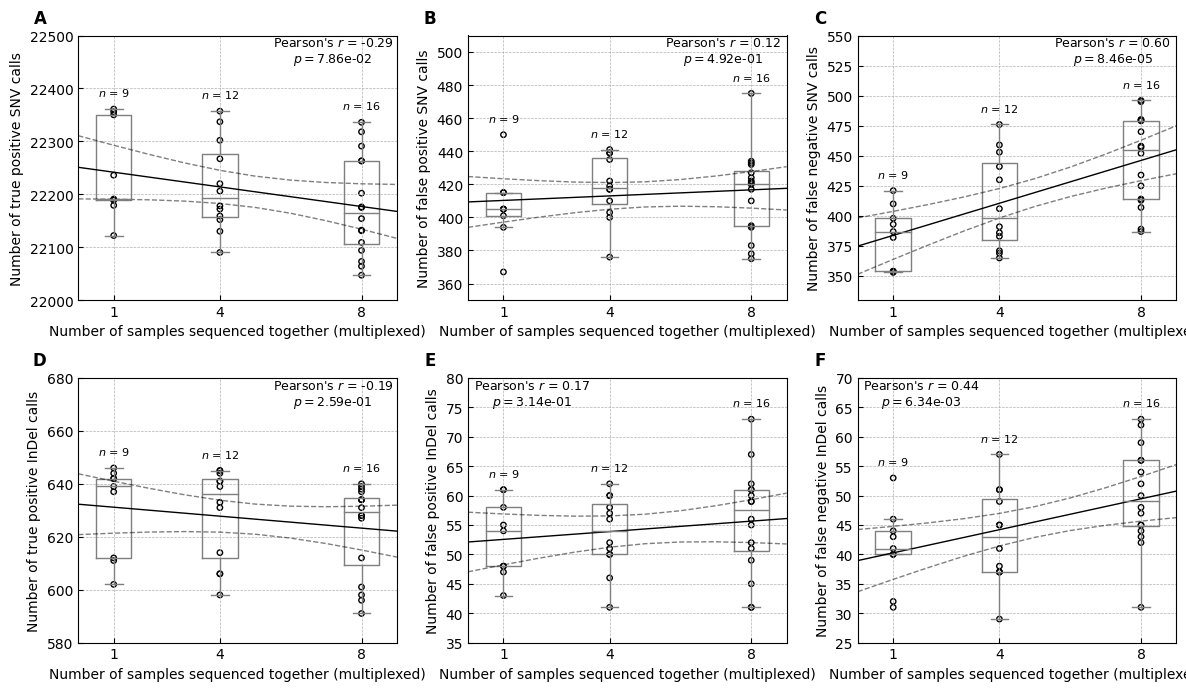

In [14]:
plt.style.use('default')
fig = plt.figure(figsize=(12, 7), dpi = 100)

df_snvs = df_variants[(df_variants.Type == 'SNP') & (df_variants.Filter == 'ALL')]
df_indels = df_variants[(df_variants.Type == 'INDEL') & (df_variants.Filter == 'ALL')]


# FIGURE A.
# ============== #
ax = fig.add_subplot(2, 3, 1)

# Run regression model
model = smf.ols('TP ~ Plexing', df_snvs)
res = model.fit()
a = res.params['Intercept']
b = res.params['Plexing']
model_pvalue = res.pvalues['Plexing']

# Compute Pearson's correlation
corr, corr_pvalue = stats.pearsonr(df_snvs['TP'], df_snvs.Plexing)

ax.scatter(df_snvs.Plexing, df_snvs['TP'], facecolors='none', edgecolors='black', s = 15)

# boxplots
bp_data = []
bp_positions = []
for plexing in sorted(df_snvs.Plexing.unique()):
    bp_positions.append(plexing)
    bp_data.append(df_snvs[df_snvs.Plexing == plexing]['TP'])
ax.boxplot(bp_data, positions = bp_positions, widths = 1, 
                showfliers = False, showmeans = False, 
                medianprops = {'color': 'tab:grey'},
                boxprops = {'color': 'tab:grey'},
                whiskerprops={'color': 'tab:grey'}, 
                capprops={'color': 'tab:grey'})

# Regression line and confidence intervals
xs = [ x for x in range(0, 10) ]
ax.plot(xs, [a + b * x for x in xs], color = 'black', linewidth = 1)
pred_summary = res.get_prediction(pd.DataFrame({'Plexing': xs})).summary_frame(alpha=0.05)
ax.plot(xs, pred_summary.mean_ci_lower, color = 'black', linestyle = '--', linewidth = 1, alpha = 0.5)
ax.plot(xs, pred_summary.mean_ci_upper, color = 'black', linestyle = '--', linewidth = 1, alpha = 0.5)

# Limits. Must be set before text annotations.
ax.set_xlim([0,  9])
ax.set_ylim([22000,  22500])

# Grid & ticks
ax.tick_params(axis = 'both', direction = 'in')
ax.grid(linestyle = '--', linewidth = 0.5)

# Text annotations
for x, data in zip(bp_positions, bp_data):
    annotate_sample_size(ax, x, data, 10)
    
ax.annotate(
    f'Pearson\'s ' + r'$\it{r}$ = ' + f'{corr:.2f}\n' + r'$\it{p}=$' + f'{corr_pvalue:.2e}', 
    (0.8, 0.88), xycoords=ax.transAxes, fontsize = 9, ha='center', va='bottom')

ax.set_ylabel('Number of true positive SNV calls')
ax.set_xlabel('Number of samples sequenced together (multiplexed)')
ax.text(-0.1, 1.1, 'A', transform = ax.transAxes, fontsize = 12, fontweight = 'bold', va = 'top', ha = 'right')


# FIGURE B.
# ============== #
ax = fig.add_subplot(2, 3, 2)

# Run regression model
model = smf.ols('FP ~ Plexing', df_snvs)
res = model.fit()
a = res.params['Intercept']
b = res.params['Plexing']
model_pvalue = res.pvalues['Plexing']

# Compute Pearson's correlation
corr, corr_pvalue = stats.pearsonr(df_snvs['FP'], df_snvs.Plexing)

ax.scatter(df_snvs.Plexing, df_snvs['FP'], facecolors='none', edgecolors='black', s = 15)

# boxplots
bp_data = []
bp_positions = []
for plexing in sorted(df_snvs.Plexing.unique()):
    bp_positions.append(plexing)
    bp_data.append(df_snvs[df_snvs.Plexing == plexing]['FP'])
ax.boxplot(bp_data, positions = bp_positions, widths = 1, 
                showfliers = False, showmeans = False, 
                medianprops = {'color': 'tab:grey'},
                boxprops = {'color': 'tab:grey'},
                whiskerprops={'color': 'tab:grey'}, 
                capprops={'color': 'tab:grey'})

# Regression line and confidence intervals
xs = [ x for x in range(0, 10) ]
ax.plot(xs, [a + b * x for x in xs], color = 'black', linewidth = 1)
pred_summary = res.get_prediction(pd.DataFrame({'Plexing': xs})).summary_frame(alpha=0.05)
ax.plot(xs, pred_summary.mean_ci_lower, color = 'black', linestyle = '--', linewidth = 1, alpha = 0.5)
ax.plot(xs, pred_summary.mean_ci_upper, color = 'black', linestyle = '--', linewidth = 1, alpha = 0.5)

# Limits. Must be set before text annotations.
ax.set_xlim([0,  9])
ax.set_ylim([350,  510])

# Grid & ticks
ax.tick_params(axis = 'both', direction = 'in')
ax.grid(linestyle = '--', linewidth = 0.5)

# Text annotations
for x, data in zip(bp_positions, bp_data):
    annotate_sample_size(ax, x, data, 10)
    
ax.annotate(
    f'Pearson\'s ' + r'$\it{r}$ = ' + f'{corr:.2f}\n' + r'$\it{p}=$' + f'{corr_pvalue:.2e}', 
    (0.8, 0.88), xycoords=ax.transAxes, fontsize = 9, ha='center', va='bottom')

ax.set_ylabel('Number of false positive SNV calls')
ax.set_xlabel('Number of samples sequenced together (multiplexed)')
ax.text(-0.1, 1.1, 'B', transform = ax.transAxes, fontsize = 12, fontweight = 'bold', va = 'top', ha = 'right')

# FIGURE C.
ax = fig.add_subplot(2, 3, 3)

# Run regression model
model = smf.ols('FN ~ Plexing', df_snvs)
res = model.fit()
a = res.params['Intercept']
b = res.params['Plexing']
model_pvalue = res.pvalues['Plexing']

# Compute Pearson's correlation
corr, corr_pvalue = stats.pearsonr(df_snvs['FN'], df_snvs.Plexing)

ax.scatter(df_snvs.Plexing, df_snvs['FN'], facecolors='none', edgecolors='black', s = 15)

# boxplots
bp_data = []
bp_positions = []
for plexing in sorted(df_snvs.Plexing.unique()):
    bp_positions.append(plexing)
    bp_data.append(df_snvs[df_snvs.Plexing == plexing]['FN'])
ax.boxplot(bp_data, positions = bp_positions, widths = 1, 
                showfliers = False, showmeans = False, 
                medianprops = {'color': 'tab:grey'},
                boxprops = {'color': 'tab:grey'},
                whiskerprops={'color': 'tab:grey'}, 
                capprops={'color': 'tab:grey'})

# Regression line and confidence intervals
xs = [ x for x in range(0, 10) ]
ax.plot(xs, [a + b * x for x in xs], color = 'black', linewidth = 1)
pred_summary = res.get_prediction(pd.DataFrame({'Plexing': xs})).summary_frame(alpha=0.05)
ax.plot(xs, pred_summary.mean_ci_lower, color = 'black', linestyle = '--', linewidth = 1, alpha = 0.5)
ax.plot(xs, pred_summary.mean_ci_upper, color = 'black', linestyle = '--', linewidth = 1, alpha = 0.5)

# Limits. Must be set before text annotations.
ax.set_xlim([0,  9])
ax.set_ylim([330,  550])

# Grid & ticks
ax.tick_params(axis = 'both', direction = 'in')
ax.grid(linestyle = '--', linewidth = 0.5)

# Text annotations
for x, data in zip(bp_positions, bp_data):
    annotate_sample_size(ax, x, data, 10)
    
ax.annotate(
    f'Pearson\'s ' + r'$\it{r}$ = ' + f'{corr:.2f}\n' + r'$\it{p}=$' + f'{corr_pvalue:.2e}', 
    (0.8, 0.88), xycoords=ax.transAxes, fontsize = 9, ha='center', va='bottom')

ax.set_ylabel('Number of false negative SNV calls')
ax.set_xlabel('Number of samples sequenced together (multiplexed)')
ax.text(-0.1, 1.1, 'C', transform = ax.transAxes, fontsize = 12, fontweight = 'bold', va = 'top', ha = 'right')

# FIGURE D.
# ============== #
ax = fig.add_subplot(2, 3, 4)

# Run regression model
model = smf.ols('TP ~ Plexing', df_indels)
res = model.fit()
a = res.params['Intercept']
b = res.params['Plexing']
model_pvalue = res.pvalues['Plexing']

# Compute Pearson's correlation
corr, corr_pvalue = stats.pearsonr(df_indels['TP'], df_indels.Plexing)

ax.scatter(df_indels.Plexing, df_indels['TP'], facecolors='none', edgecolors='black', s = 15)

# boxplots
bp_data = []
bp_positions = []
for plexing in sorted(df_indels.Plexing.unique()):
    bp_positions.append(plexing)
    bp_data.append(df_indels[df_indels.Plexing == plexing]['TP'])
ax.boxplot(bp_data, positions = bp_positions, widths = 1, 
                showfliers = False, showmeans = False, 
                medianprops = {'color': 'tab:grey'},
                boxprops = {'color': 'tab:grey'},
                whiskerprops={'color': 'tab:grey'}, 
                capprops={'color': 'tab:grey'})

# Regression line and confidence intervals
xs = [ x for x in range(0, 10) ]
ax.plot(xs, [a + b * x for x in xs], color = 'black', linewidth = 1)
pred_summary = res.get_prediction(pd.DataFrame({'Plexing': xs})).summary_frame(alpha=0.05)
ax.plot(xs, pred_summary.mean_ci_lower, color = 'black', linestyle = '--', linewidth = 1, alpha = 0.5)
ax.plot(xs, pred_summary.mean_ci_upper, color = 'black', linestyle = '--', linewidth = 1, alpha = 0.5)

# Limits. Must be set before text annotations.
ax.set_xlim([0,  9])
ax.set_ylim([580,  680])

# Grid & ticks
ax.tick_params(axis = 'both', direction = 'in')
ax.grid(linestyle = '--', linewidth = 0.5)

# Text annotations
for x, data in zip(bp_positions, bp_data):
    annotate_sample_size(ax, x, data, 10)
    
ax.annotate(
    f'Pearson\'s ' + r'$\it{r}$ = ' + f'{corr:.2f}\n' + r'$\it{p}=$' + f'{corr_pvalue:.2e}', 
    (0.8, 0.88), xycoords=ax.transAxes, fontsize = 9, ha='center', va='bottom')

ax.set_ylabel('Number of true positive InDel calls')
ax.set_xlabel('Number of samples sequenced together (multiplexed)')
ax.text(-0.1, 1.1, 'D', transform = ax.transAxes, fontsize = 12, fontweight = 'bold', va = 'top', ha = 'right')


# FIGURE E.
# ============== #
ax = fig.add_subplot(2, 3, 5)

# Run regression model
model = smf.ols('FP ~ Plexing', df_indels)
res = model.fit()
a = res.params['Intercept']
b = res.params['Plexing']
model_pvalue = res.pvalues['Plexing']

# Compute Pearson's correlation
corr, corr_pvalue = stats.pearsonr(df_indels['FP'], df_indels.Plexing)

ax.scatter(df_indels.Plexing, df_indels['FP'], facecolors='none', edgecolors='black', s = 15)

# boxplots
bp_data = []
bp_positions = []
for plexing in sorted(df_indels.Plexing.unique()):
    bp_positions.append(plexing)
    bp_data.append(df_indels[df_indels.Plexing == plexing]['FP'])
ax.boxplot(bp_data, positions = bp_positions, widths = 1, 
                showfliers = False, showmeans = False, 
                medianprops = {'color': 'tab:grey'},
                boxprops = {'color': 'tab:grey'},
                whiskerprops={'color': 'tab:grey'}, 
                capprops={'color': 'tab:grey'})

# Regression line and confidence intervals
xs = [ x for x in range(0, 10) ]
ax.plot(xs, [a + b * x for x in xs], color = 'black', linewidth = 1)
pred_summary = res.get_prediction(pd.DataFrame({'Plexing': xs})).summary_frame(alpha=0.05)
ax.plot(xs, pred_summary.mean_ci_lower, color = 'black', linestyle = '--', linewidth = 1, alpha = 0.5)
ax.plot(xs, pred_summary.mean_ci_upper, color = 'black', linestyle = '--', linewidth = 1, alpha = 0.5)

# Limits. Must be set before text annotations.
ax.set_xlim([0,  9])
ax.set_ylim([35,  80])

# Grid & ticks
ax.tick_params(axis = 'both', direction = 'in')
ax.grid(linestyle = '--', linewidth = 0.5)

# Text annotations
for x, data in zip(bp_positions, bp_data):
    annotate_sample_size(ax, x, data, 10)
    
ax.annotate(
    f'Pearson\'s ' + r'$\it{r}$ = ' + f'{corr:.2f}\n' + r'$\it{p}=$' + f'{corr_pvalue:.2e}', 
    (0.2, 0.88), xycoords=ax.transAxes, fontsize = 9, ha='center', va='bottom')

ax.set_ylabel('Number of false positive InDel calls')
ax.set_xlabel('Number of samples sequenced together (multiplexed)')
ax.text(-0.1, 1.1, 'E', transform = ax.transAxes, fontsize = 12, fontweight = 'bold', va = 'top', ha = 'right')


# FIGURE F.
# ============== #
ax = fig.add_subplot(2, 3, 6)

# Run regression model
model = smf.ols('FN ~ Plexing', df_indels)
res = model.fit()
a = res.params['Intercept']
b = res.params['Plexing']
model_pvalue = res.pvalues['Plexing']

# Compute Pearson's correlation
corr, corr_pvalue = stats.pearsonr(df_indels['FN'], df_indels.Plexing)

ax.scatter(df_indels.Plexing, df_indels['FN'], facecolors='none', edgecolors='black', s = 15)

# boxplots
bp_data = []
bp_positions = []
for plexing in sorted(df_indels.Plexing.unique()):
    bp_positions.append(plexing)
    bp_data.append(df_indels[df_indels.Plexing == plexing]['FN'])
ax.boxplot(bp_data, positions = bp_positions, widths = 1, 
                showfliers = False, showmeans = False, 
                medianprops = {'color': 'tab:grey'},
                boxprops = {'color': 'tab:grey'},
                whiskerprops={'color': 'tab:grey'}, 
                capprops={'color': 'tab:grey'})

# Regression line and confidence intervals
xs = [ x for x in range(0, 10) ]
ax.plot(xs, [a + b * x for x in xs], color = 'black', linewidth = 1)
pred_summary = res.get_prediction(pd.DataFrame({'Plexing': xs})).summary_frame(alpha=0.05)
ax.plot(xs, pred_summary.mean_ci_lower, color = 'black', linestyle = '--', linewidth = 1, alpha = 0.5)
ax.plot(xs, pred_summary.mean_ci_upper, color = 'black', linestyle = '--', linewidth = 1, alpha = 0.5)

# Limits. Must be set before text annotations.
ax.set_xlim([0,  9])
ax.set_ylim([25,  70])

# Grid & ticks
ax.tick_params(axis = 'both', direction = 'in')
ax.grid(linestyle = '--', linewidth = 0.5)

# Text annotations
for x, data in zip(bp_positions, bp_data):
    annotate_sample_size(ax, x, data, 10)
    
ax.annotate(
    f'Pearson\'s ' + r'$\it{r}$ = ' + f'{corr:.2f}\n' + r'$\it{p}=$' + f'{corr_pvalue:.2e}', 
    (0.2, 0.88), xycoords=ax.transAxes, fontsize = 9, ha='center', va='bottom')

ax.set_ylabel('Number of false negative InDel calls')
ax.set_xlabel('Number of samples sequenced together (multiplexed)')
ax.text(-0.1, 1.1, 'F', transform = ax.transAxes, fontsize = 12, fontweight = 'bold', va = 'top', ha = 'right')


plt.tight_layout()
plt.show()

### TABLE: The average changes in SNV calling in whole exome sequencing experiments with UMI-aware read deduplication relative to the UMI agnostic approach.

In [15]:
dedup_types = [
    ('UMI', 'LocatIt', df_umi_locatit_variants[(df_umi_locatit_variants.Filter == 'ALL') & (df_umi_locatit_variants.Type == 'SNP')]), 
    ('UMI_GATK', 'GATK', df_umi_gatk_variants[(df_umi_gatk_variants.Filter == 'ALL') & (df_umi_gatk_variants.Type == 'SNP')]),
]
plexings = [1, 4, 8]

data = {
    'Number of samples sequenced together (multiplexed)': [],
    'UMI-aware deduplication tool': [],
    'N (SE)': [],
    'TP (SE)': [],
    'FP (SE)': [],
    'FN (SE)': [],
    'Recall (SE)': [],
    'Precision (SE)': []
}

def sign_symbol(pval):
    if pval <= 0.001:
        return '***'
    elif pval <= 0.01:
        return '**'
    elif pval <= 0.05:
        return '*'
    else:
        return ''

for plexing in plexings:
    df_temp = df_variants[(df_variants.Filter == 'ALL') & (df_variants.Type == 'SNP') & (df_variants.Plexing == plexing)]
    for dedup_type, dedup_label, dedup_df in dedup_types:
        data['Number of samples sequenced together (multiplexed)'].append(plexing)
        data['UMI-aware deduplication tool'].append(dedup_label)
        assert len(df_temp) == len(dedup_df[dedup_df.Plexing == plexing])
        
        df_merged = df_temp.merge(dedup_df[dedup_df.Plexing == plexing], on = ['ID', 'HGID', 'Batch', 'Plexing'], suffixes = ['_NOUMI', '_UMI'])
        assert len(df_temp) == len(df_merged)
        
        avg = np.mean(df_merged['TP_UMI'] + df_merged['FP_UMI'] - df_merged['TP_NOUMI'] - df_merged['FP_NOUMI'])
        sem = stats.sem(df_merged['TP_UMI'] + df_merged['FP_UMI'] - df_merged['TP_NOUMI'] - df_merged['FP_NOUMI'])
        if (avg < 0):
            pvalue = stats.wilcoxon(df_merged['TP_NOUMI'] + df_merged['FP_NOUMI'], df_merged['TP_UMI'] + df_merged['FP_UMI'], alternative = "greater")[1]
        else:
            pvalue = stats.wilcoxon(df_merged['TP_NOUMI'] + df_merged['FP_NOUMI'], df_merged['TP_UMI'] + df_merged['FP_UMI'], alternative = "less")[1]        
        data['N (SE)'].append(f'{avg:.0f} ({sem:.0f}) {sign_symbol(pvalue)}')
        
        avg = np.mean(df_merged['TP_UMI'] - df_merged['TP_NOUMI'])
        sem = stats.sem(df_merged['TP_UMI'] - df_merged['TP_NOUMI'])
        if (avg < 0):
            pvalue = stats.wilcoxon(df_merged['TP_NOUMI'], df_merged['TP_UMI'], alternative = "greater")[1]
        else:
            pvalue = stats.wilcoxon(df_merged['TP_NOUMI'], df_merged['TP_UMI'], alternative = "less")[1]
        data['TP (SE)'].append(f'{avg:.0f} ({sem:.0f}) {sign_symbol(pvalue)}')

        avg = np.mean(df_merged['FP_UMI'] - df_merged['FP_NOUMI'])
        sem = stats.sem(df_merged['FP_UMI'] - df_merged['FP_NOUMI'])
        if (avg < 0):
            pvalue = stats.wilcoxon(df_merged['FP_NOUMI'], df_merged['FP_UMI'], alternative = "greater")[1]
        else:
            pvalue = stats.wilcoxon(df_merged['FP_NOUMI'], df_merged['FP_UMI'], alternative = "less")[1]
        data['FP (SE)'].append(f'{avg:.0f} ({sem:.0f}) {sign_symbol(pvalue)}')
        
        avg = np.mean(df_merged['FN_UMI'] - df_merged['FN_NOUMI'])
        sem = stats.sem(df_merged['FN_UMI'] - df_merged['FN_NOUMI'])
        if (avg < 0):
            pvalue = stats.wilcoxon(df_merged['FN_NOUMI'], df_merged['FN_UMI'], alternative = "greater")[1]
        else:
            pvalue = stats.wilcoxon(df_merged['FN_NOUMI'], df_merged['FN_UMI'], alternative = "less")[1]
        data['FN (SE)'].append(f'{avg:.0f} ({sem:.0f}) {sign_symbol(pvalue)}')

        avg = np.mean(df_merged['Recall_UMI'] - df_merged['Recall_NOUMI'])
        sem = stats.sem(df_merged['Recall_UMI'] - df_merged['Recall_NOUMI'])
        if (avg < 0):
            pvalue = stats.wilcoxon(df_merged['Recall_NOUMI'], df_merged['Recall_UMI'], alternative = "greater")[1]
        else:
            pvalue = stats.wilcoxon(df_merged['Recall_NOUMI'], df_merged['Recall_UMI'], alternative = "less")[1]
        data['Recall (SE)'].append(f'{avg:.4f} ({sem:.4f}){sign_symbol(pvalue):>3}')

        avg = np.mean(df_merged['Precision_UMI'] - df_merged['Precision_NOUMI'])
        sem = stats.sem(df_merged['Precision_UMI'] - df_merged['Precision_NOUMI'])
        if (avg < 0):
            pvalue = stats.wilcoxon(df_merged['Precision_NOUMI'], df_merged['Precision_UMI'], alternative = "greater")[1]
        else:
            pvalue = stats.wilcoxon(df_merged['Precision_NOUMI'], df_merged['Precision_UMI'], alternative = "less")[1]
        data['Precision (SE)'].append(f'{avg:.4f} ({sem:.4f}){sign_symbol(pvalue)}')

pd.DataFrame(data)

/localscratch/dtaliun.15230538.0/lib/python3.9/site-packages/scipy/stats/_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/localscratch/dtaliun.15230538.0/lib/python3.9/site-packages/scipy/stats/_morestats.py:3428: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/localscratch/dtaliun.15230538.0/lib/python3.9/site-packages/scipy/stats/_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/localscratch/dtaliun.15230538.0/lib/python3.9/site-packages/scipy/stats/_morestats.py:3428: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/localscratc

,Number of samples sequenced together (multiplexed),UMI-aware deduplication tool,N (SE),TP (SE),FP (SE),FN (SE),Recall (SE),Precision (SE)
0,1,LocatIt,-17 (3) **,-14 (1) **,-4 (4),14 (1) **,-0.0006 (0.0001) **,0.0002 (0.0002)
1,1,GATK,9 (3) **,0 (0),8 (2) **,-0 (0),0.0000 (0.0000),-0.0004 (0.0001)**
2,4,LocatIt,-16 (3) ***,-13 (2) ***,-3 (3),13 (2) ***,-0.0006 (0.0001)***,0.0001 (0.0001)
3,4,GATK,24 (3) ***,4 (1) **,20 (3) ***,-4 (1) **,0.0002 (0.0000) **,-0.0009 (0.0001)***
4,8,LocatIt,-20 (4) ***,-17 (2) ***,-2 (3),17 (2) ***,-0.0008 (0.0001)***,0.0001 (0.0001)
5,8,GATK,39 (2) ***,6 (1) ***,33 (2) ***,-6 (1) ***,0.0003 (0.0000)***,-0.0014 (0.0001)***


### FIGURE: Recall and precision of the single nucleotide variations (SNVs) in sequencing experiments without and with UMI-aware read deduplication.

/localscratch/dtaliun.15230538.0/lib/python3.9/site-packages/scipy/stats/_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/localscratch/dtaliun.15230538.0/lib/python3.9/site-packages/scipy/stats/_morestats.py:3428: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


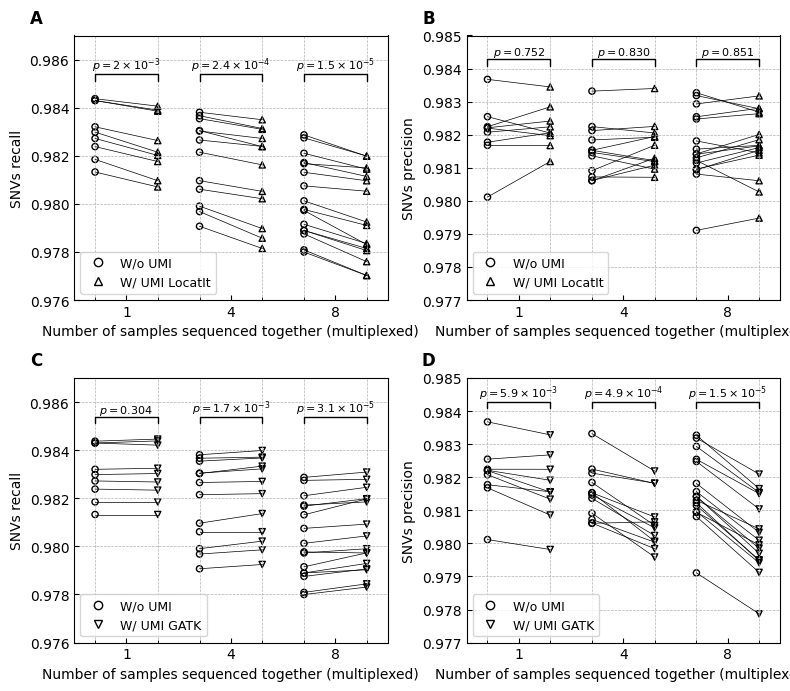

In [16]:
plt.style.use('default')
fig = plt.figure(figsize=(8, 7), dpi = 100)

plexings = [1, 4, 8]
plexing_positions = [1, 2, 3]

df_temp_noumi = df_variants[(df_variants.Filter == 'ALL') & (df_variants.Type == 'SNP')]
df_temp_umi_locatit = df_umi_locatit_variants[(df_umi_locatit_variants.Filter == 'ALL') & (df_umi_locatit_variants.Type == 'SNP')]
df_temp_umi_gatk = df_umi_gatk_variants[(df_umi_gatk_variants.Filter == 'ALL') & (df_umi_gatk_variants.Type == 'SNP')]
assert len(df_temp_noumi) == len(df_temp_umi_locatit)
assert len(df_temp_noumi) == len(df_temp_umi_gatk)

df_temp_merged_locatit = df_temp_noumi.merge(df_temp_umi_locatit, on = ['ID', 'HGID', 'Batch', 'Plexing'], suffixes = ['_NOUMI', '_UMI'])
assert len(df_temp_merged_locatit) == len(df_temp_noumi)

df_temp_merged_gatk = df_temp_noumi.merge(df_temp_umi_gatk, on = ['ID', 'HGID', 'Batch', 'Plexing'], suffixes = ['_NOUMI', '_UMI'])
assert len(df_temp_merged_gatk) == len(df_temp_noumi)


# FIGURE A.
# ============== #
ax = fig.add_subplot(2, 2, 1)
data = dict()
for x, plexing in zip(plexing_positions, plexings):
    df_temp = df_temp_merged_locatit[df_temp_merged_locatit.Plexing == plexing]
    for idx, row in df_temp[['Recall_NOUMI', 'Recall_UMI']].iterrows():
        ax.plot([x - 0.3, x + 0.3], [row['Recall_NOUMI'], row['Recall_UMI']], color = 'black', linewidth = 0.5)
    data[plexing] = { 'NOUMI': df_temp['Recall_NOUMI'], 'UMI': df_temp['Recall_UMI'] }
    ax.scatter([x - 0.3] * len(df_temp), data[plexing]['NOUMI'], marker = 'o', edgecolor = 'black', facecolor = 'none', s = 20)
    ax.scatter([x + 0.3] * len(df_temp), data[plexing]['UMI'], marker = '^', edgecolor = 'black', facecolor = 'none', s = 20)
ax.tick_params(axis = 'both', direction = 'in', which = 'both')
ax.set_xticks([x - 0.3 for x in plexing_positions] + [x + 0.3 for x in plexing_positions], minor = True)
ax.xaxis.grid(True, which = 'minor', linestyle = '--', linewidth = 0.5)
ax.yaxis.grid(True, which = 'major', linestyle = '--', linewidth = 0.5)
ax.set_xticks(plexing_positions)
ax.set_xticklabels(plexings)
# Limits. Must be set before text annotations.
ax.set_xlim([0.5,  3.5])
ax.set_ylim([0.976,  0.987])
for x, plexing in zip(plexing_positions, plexings):
    pvalue = stats.wilcoxon(data[plexing]['NOUMI'], data[plexing]['UMI'], alternative = "greater")[1] # Wilcoxon signed-ranks test
    annotate_pvalue(ax, x - 0.3, x + 0.3, 0.985, pvalue, 0.15)
ax.set_ylabel('SNVs recall')
ax.set_xlabel('Number of samples sequenced together (multiplexed)')
legend_elements = [
    Line2D([0], [0], marker = 'o', markeredgecolor = 'black', markerfacecolor = 'none', color = 'none', label='W/o UMI'), 
    Line2D([0], [0], marker = '^', markeredgecolor = 'black', markerfacecolor = 'none', color = 'none', label='W/ UMI LocatIt'),
]
ax.legend(handles = legend_elements, loc = 3, prop = {'size': 9})
ax.text(-0.1, 1.1, 'A', transform = ax.transAxes, fontsize = 12, fontweight = 'bold', va = 'top', ha = 'right')

# FIGURE B.
# ============== #
ax = fig.add_subplot(2, 2, 2)
data = dict()
for x, plexing in zip(plexing_positions, plexings):
    df_temp = df_temp_merged_locatit[df_temp_merged_locatit.Plexing == plexing]
    for idx, row in df_temp[['Precision_NOUMI', 'Precision_UMI']].iterrows():
        ax.plot([x - 0.3, x + 0.3], [row['Precision_NOUMI'], row['Precision_UMI']], color = 'black', linewidth = 0.5)
    data[plexing] = { 'NOUMI': df_temp['Precision_NOUMI'], 'UMI': df_temp['Precision_UMI'] }
    ax.scatter([x - 0.3] * len(df_temp), data[plexing]['NOUMI'], marker = 'o', edgecolor = 'black', facecolor = 'none', s = 20)
    ax.scatter([x + 0.3] * len(df_temp), data[plexing]['UMI'], marker = '^', edgecolor = 'black', facecolor = 'none', s = 20)
ax.tick_params(axis = 'both', direction = 'in', which = 'both')
ax.set_xticks([x - 0.3 for x in plexing_positions] + [x + 0.3 for x in plexing_positions], minor = True)
ax.xaxis.grid(True, which = 'minor', linestyle = '--', linewidth = 0.5)
ax.yaxis.grid(True, which = 'major', linestyle = '--', linewidth = 0.5)
ax.set_xticks(plexing_positions)
ax.set_xticklabels(plexings)
# Limits. Must be set before text annotations.
ax.set_xlim([0.5,  3.5])
ax.set_ylim([0.977,  0.985])
for x, plexing in zip(plexing_positions, plexings):
    pvalue = stats.wilcoxon(data[plexing]['NOUMI'], data[plexing]['UMI'], alternative = "greater")[1] # Wilcoxon signed-ranks test
    annotate_pvalue(ax, x - 0.3, x + 0.3, 0.984, pvalue, 0.15)
ax.set_ylabel('SNVs precision')
ax.set_xlabel('Number of samples sequenced together (multiplexed)')
legend_elements = [
    Line2D([0], [0], marker = 'o', markeredgecolor = 'black', markerfacecolor = 'none', color = 'none', label='W/o UMI'), 
    Line2D([0], [0], marker = '^', markeredgecolor = 'black', markerfacecolor = 'none', color = 'none', label='W/ UMI LocatIt'),
]
ax.legend(handles = legend_elements, loc = 3, prop = {'size': 9})
ax.text(-0.1, 1.1, 'B', transform = ax.transAxes, fontsize = 12, fontweight = 'bold', va = 'top', ha = 'right')


# FIGURE C.
# ============== #
ax = fig.add_subplot(2, 2, 3)
data = dict()
for x, plexing in zip(plexing_positions, plexings):
    df_temp = df_temp_merged_gatk[df_temp_merged_gatk.Plexing == plexing]
    for idx, row in df_temp[['Recall_NOUMI', 'Recall_UMI']].iterrows():
        ax.plot([x - 0.3, x + 0.3], [row['Recall_NOUMI'], row['Recall_UMI']], color = 'black', linewidth = 0.5)
    data[plexing] = { 'NOUMI': df_temp['Recall_NOUMI'], 'UMI': df_temp['Recall_UMI'] }
    ax.scatter([x - 0.3] * len(df_temp), data[plexing]['NOUMI'], marker = 'o', edgecolor = 'black', facecolor = 'none', s = 20)
    ax.scatter([x + 0.3] * len(df_temp), data[plexing]['UMI'], marker = 'v', edgecolor = 'black', facecolor = 'none', s = 20)
ax.tick_params(axis = 'both', direction = 'in', which = 'both')
ax.set_xticks([x - 0.3 for x in plexing_positions] + [x + 0.3 for x in plexing_positions], minor = True)
ax.xaxis.grid(True, which = 'minor', linestyle = '--', linewidth = 0.5)
ax.yaxis.grid(True, which = 'major', linestyle = '--', linewidth = 0.5)
ax.set_xticks(plexing_positions)
ax.set_xticklabels(plexings)
# Limits. Must be set before text annotations.
ax.set_xlim([0.5,  3.5])
ax.set_ylim([0.976,  0.987])
for x, plexing in zip(plexing_positions, plexings):
    pvalue = stats.wilcoxon(data[plexing]['NOUMI'], data[plexing]['UMI'], alternative = "less")[1] # Wilcoxon signed-ranks test
    annotate_pvalue(ax, x - 0.3, x + 0.3, 0.985, pvalue, 0.15)
ax.set_ylabel('SNVs recall')
ax.set_xlabel('Number of samples sequenced together (multiplexed)')
legend_elements = [
    Line2D([0], [0], marker = 'o', markeredgecolor = 'black', markerfacecolor = 'none', color = 'none', label='W/o UMI'), 
    Line2D([0], [0], marker = 'v', markeredgecolor = 'black', markerfacecolor = 'none', color = 'none', label='W/ UMI GATK'),
]
ax.legend(handles = legend_elements, loc = 3, prop = {'size': 9})
ax.text(-0.1, 1.1, 'C', transform = ax.transAxes, fontsize = 12, fontweight = 'bold', va = 'top', ha = 'right')


# FIGURE D.
# ============== #
ax = fig.add_subplot(2, 2, 4)
data = dict()
for x, plexing in zip(plexing_positions, plexings):
    df_temp = df_temp_merged_gatk[df_temp_merged_gatk.Plexing == plexing]
    for idx, row in df_temp[['Precision_NOUMI', 'Precision_UMI']].iterrows():
        ax.plot([x - 0.3, x + 0.3], [row['Precision_NOUMI'], row['Precision_UMI']], color = 'black', linewidth = 0.5)
    data[plexing] = { 'NOUMI': df_temp['Precision_NOUMI'], 'UMI': df_temp['Precision_UMI'] }
    ax.scatter([x - 0.3] * len(df_temp), data[plexing]['NOUMI'], marker = 'o', edgecolor = 'black', facecolor = 'none', s = 20)
    ax.scatter([x + 0.3] * len(df_temp), data[plexing]['UMI'], marker = 'v', edgecolor = 'black', facecolor = 'none', s = 20)
ax.tick_params(axis = 'both', direction = 'in', which = 'both')
ax.set_xticks([x - 0.3 for x in plexing_positions] + [x + 0.3 for x in plexing_positions], minor = True)
ax.xaxis.grid(True, which = 'minor', linestyle = '--', linewidth = 0.5)
ax.yaxis.grid(True, which = 'major', linestyle = '--', linewidth = 0.5)
ax.set_xticks(plexing_positions)
ax.set_xticklabels(plexings)
# Limits. Must be set before text annotations.
ax.set_xlim([0.5,  3.5])
ax.set_ylim([0.977,  0.985])
for x, plexing in zip(plexing_positions, plexings):
    pvalue = stats.wilcoxon(data[plexing]['NOUMI'], data[plexing]['UMI'], alternative = "greater")[1] # Wilcoxon signed-ranks test
    annotate_pvalue(ax, x - 0.3, x + 0.3, 0.984, pvalue, 0.15)
ax.set_ylabel('SNVs precision')
ax.set_xlabel('Number of samples sequenced together (multiplexed)')
legend_elements = [
    Line2D([0], [0], marker = 'o', markeredgecolor = 'black', markerfacecolor = 'none', color = 'none', label='W/o UMI'), 
    Line2D([0], [0], marker = 'v', markeredgecolor = 'black', markerfacecolor = 'none', color = 'none', label='W/ UMI GATK'),
]
ax.legend(handles = legend_elements, loc = 3, prop = {'size': 9})
ax.text(-0.1, 1.1, 'D', transform = ax.transAxes, fontsize = 12, fontweight = 'bold', va = 'top', ha = 'right')

plt.tight_layout()
plt.show()

### EXTRA FIGURE: Recall and precision of the single nucleotide variations (SNVs) in sequencing experiments without and with UMI-aware read deduplication in Batch 1.

/localscratch/dtaliun.15230538.0/lib/python3.9/site-packages/scipy/stats/_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/localscratch/dtaliun.15230538.0/lib/python3.9/site-packages/scipy/stats/_morestats.py:3428: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


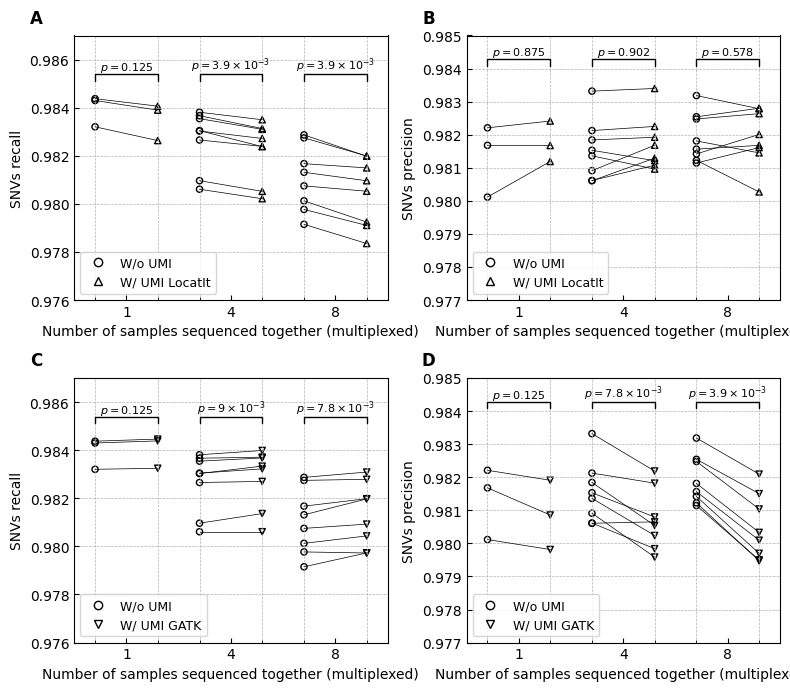

In [17]:
plt.style.use('default')
fig = plt.figure(figsize=(8, 7), dpi = 100)

plexings = [1, 4, 8]
plexing_positions = [1, 2, 3]

df_temp_noumi = df_variants[(df_variants.Filter == 'ALL') & (df_variants.Type == 'SNP') & (df_variants.Batch == 1)]
df_temp_umi_locatit = df_umi_locatit_variants[(df_umi_locatit_variants.Filter == 'ALL') & (df_umi_locatit_variants.Type == 'SNP') & (df_umi_locatit_variants.Batch == 1)]
df_temp_umi_gatk = df_umi_gatk_variants[(df_umi_gatk_variants.Filter == 'ALL') & (df_umi_gatk_variants.Type == 'SNP') & (df_umi_gatk_variants.Batch == 1)]
assert len(df_temp_noumi) == len(df_temp_umi_locatit)
assert len(df_temp_noumi) == len(df_temp_umi_gatk)

df_temp_merged_locatit = df_temp_noumi.merge(df_temp_umi_locatit, on = ['ID', 'HGID', 'Batch', 'Plexing'], suffixes = ['_NOUMI', '_UMI'])
assert len(df_temp_merged_locatit) == len(df_temp_noumi)

df_temp_merged_gatk = df_temp_noumi.merge(df_temp_umi_gatk, on = ['ID', 'HGID', 'Batch', 'Plexing'], suffixes = ['_NOUMI', '_UMI'])
assert len(df_temp_merged_gatk) == len(df_temp_noumi)


# FIGURE A.
# ============== #
ax = fig.add_subplot(2, 2, 1)
data = dict()
for x, plexing in zip(plexing_positions, plexings):
    df_temp = df_temp_merged_locatit[df_temp_merged_locatit.Plexing == plexing]
    for idx, row in df_temp[['Recall_NOUMI', 'Recall_UMI']].iterrows():
        ax.plot([x - 0.3, x + 0.3], [row['Recall_NOUMI'], row['Recall_UMI']], color = 'black', linewidth = 0.5)
    data[plexing] = { 'NOUMI': df_temp['Recall_NOUMI'], 'UMI': df_temp['Recall_UMI'] }
    ax.scatter([x - 0.3] * len(df_temp), data[plexing]['NOUMI'], marker = 'o', edgecolor = 'black', facecolor = 'none', s = 20)
    ax.scatter([x + 0.3] * len(df_temp), data[plexing]['UMI'], marker = '^', edgecolor = 'black', facecolor = 'none', s = 20)
ax.tick_params(axis = 'both', direction = 'in', which = 'both')
ax.set_xticks([x - 0.3 for x in plexing_positions] + [x + 0.3 for x in plexing_positions], minor = True)
ax.xaxis.grid(True, which = 'minor', linestyle = '--', linewidth = 0.5)
ax.yaxis.grid(True, which = 'major', linestyle = '--', linewidth = 0.5)
ax.set_xticks(plexing_positions)
ax.set_xticklabels(plexings)
# Limits. Must be set before text annotations.
ax.set_xlim([0.5,  3.5])
ax.set_ylim([0.976,  0.987])
for x, plexing in zip(plexing_positions, plexings):
    pvalue = stats.wilcoxon(data[plexing]['NOUMI'], data[plexing]['UMI'], alternative = "greater")[1] # Wilcoxon signed-ranks test
    annotate_pvalue(ax, x - 0.3, x + 0.3, 0.985, pvalue, 0.15)
ax.set_ylabel('SNVs recall')
ax.set_xlabel('Number of samples sequenced together (multiplexed)')
legend_elements = [
    Line2D([0], [0], marker = 'o', markeredgecolor = 'black', markerfacecolor = 'none', color = 'none', label='W/o UMI'), 
    Line2D([0], [0], marker = '^', markeredgecolor = 'black', markerfacecolor = 'none', color = 'none', label='W/ UMI LocatIt'),
]
ax.legend(handles = legend_elements, loc = 3, prop = {'size': 9})
ax.text(-0.1, 1.1, 'A', transform = ax.transAxes, fontsize = 12, fontweight = 'bold', va = 'top', ha = 'right')
    

# FIGURE B.
# ============== #
ax = fig.add_subplot(2, 2, 2)
data = dict()
for x, plexing in zip(plexing_positions, plexings):
    df_temp = df_temp_merged_locatit[df_temp_merged_locatit.Plexing == plexing]
    for idx, row in df_temp[['Precision_NOUMI', 'Precision_UMI']].iterrows():
        ax.plot([x - 0.3, x + 0.3], [row['Precision_NOUMI'], row['Precision_UMI']], color = 'black', linewidth = 0.5)
    data[plexing] = { 'NOUMI': df_temp['Precision_NOUMI'], 'UMI': df_temp['Precision_UMI'] }
    ax.scatter([x - 0.3] * len(df_temp), data[plexing]['NOUMI'], marker = 'o', edgecolor = 'black', facecolor = 'none', s = 20)
    ax.scatter([x + 0.3] * len(df_temp), data[plexing]['UMI'], marker = '^', edgecolor = 'black', facecolor = 'none', s = 20)
ax.tick_params(axis = 'both', direction = 'in', which = 'both')
ax.set_xticks([x - 0.3 for x in plexing_positions] + [x + 0.3 for x in plexing_positions], minor = True)
ax.xaxis.grid(True, which = 'minor', linestyle = '--', linewidth = 0.5)
ax.yaxis.grid(True, which = 'major', linestyle = '--', linewidth = 0.5)
ax.set_xticks(plexing_positions)
ax.set_xticklabels(plexings)
# Limits. Must be set before text annotations.
ax.set_xlim([0.5,  3.5])
ax.set_ylim([0.977,  0.985])
for x, plexing in zip(plexing_positions, plexings):
    pvalue = stats.wilcoxon(data[plexing]['NOUMI'], data[plexing]['UMI'], alternative = "greater")[1] # Wilcoxon signed-ranks test
    annotate_pvalue(ax, x - 0.3, x + 0.3, 0.984, pvalue, 0.15)
ax.set_ylabel('SNVs precision')
ax.set_xlabel('Number of samples sequenced together (multiplexed)')
legend_elements = [
    Line2D([0], [0], marker = 'o', markeredgecolor = 'black', markerfacecolor = 'none', color = 'none', label='W/o UMI'), 
    Line2D([0], [0], marker = '^', markeredgecolor = 'black', markerfacecolor = 'none', color = 'none', label='W/ UMI LocatIt'),
]
ax.legend(handles = legend_elements, loc = 3, prop = {'size': 9})
ax.text(-0.1, 1.1, 'B', transform = ax.transAxes, fontsize = 12, fontweight = 'bold', va = 'top', ha = 'right')


# FIGURE C.
# ============== #
ax = fig.add_subplot(2, 2, 3)
data = dict()
for x, plexing in zip(plexing_positions, plexings):
    df_temp = df_temp_merged_gatk[df_temp_merged_gatk.Plexing == plexing]
    for idx, row in df_temp[['Recall_NOUMI', 'Recall_UMI']].iterrows():
        ax.plot([x - 0.3, x + 0.3], [row['Recall_NOUMI'], row['Recall_UMI']], color = 'black', linewidth = 0.5)
    data[plexing] = { 'NOUMI': df_temp['Recall_NOUMI'], 'UMI': df_temp['Recall_UMI'] }
    ax.scatter([x - 0.3] * len(df_temp), data[plexing]['NOUMI'], marker = 'o', edgecolor = 'black', facecolor = 'none', s = 20)
    ax.scatter([x + 0.3] * len(df_temp), data[plexing]['UMI'], marker = 'v', edgecolor = 'black', facecolor = 'none', s = 20)
ax.tick_params(axis = 'both', direction = 'in', which = 'both')
ax.set_xticks([x - 0.3 for x in plexing_positions] + [x + 0.3 for x in plexing_positions], minor = True)
ax.xaxis.grid(True, which = 'minor', linestyle = '--', linewidth = 0.5)
ax.yaxis.grid(True, which = 'major', linestyle = '--', linewidth = 0.5)
ax.set_xticks(plexing_positions)
ax.set_xticklabels(plexings)
# Limits. Must be set before text annotations.
ax.set_xlim([0.5,  3.5])
ax.set_ylim([0.976,  0.987])
for x, plexing in zip(plexing_positions, plexings):
    pvalue = stats.wilcoxon(data[plexing]['NOUMI'], data[plexing]['UMI'], alternative = "less")[1] # Wilcoxon signed-ranks test
    annotate_pvalue(ax, x - 0.3, x + 0.3, 0.985, pvalue, 0.15)
ax.set_ylabel('SNVs recall')
ax.set_xlabel('Number of samples sequenced together (multiplexed)')
legend_elements = [
    Line2D([0], [0], marker = 'o', markeredgecolor = 'black', markerfacecolor = 'none', color = 'none', label='W/o UMI'), 
    Line2D([0], [0], marker = 'v', markeredgecolor = 'black', markerfacecolor = 'none', color = 'none', label='W/ UMI GATK'),
]
ax.legend(handles = legend_elements, loc = 3, prop = {'size': 9})
ax.text(-0.1, 1.1, 'C', transform = ax.transAxes, fontsize = 12, fontweight = 'bold', va = 'top', ha = 'right')


# FIGURE D.
# ============== #
ax = fig.add_subplot(2, 2, 4)
data = dict()
for x, plexing in zip(plexing_positions, plexings):
    df_temp = df_temp_merged_gatk[df_temp_merged_gatk.Plexing == plexing]
    for idx, row in df_temp[['Precision_NOUMI', 'Precision_UMI']].iterrows():
        ax.plot([x - 0.3, x + 0.3], [row['Precision_NOUMI'], row['Precision_UMI']], color = 'black', linewidth = 0.5)
    data[plexing] = { 'NOUMI': df_temp['Precision_NOUMI'], 'UMI': df_temp['Precision_UMI'] }
    ax.scatter([x - 0.3] * len(df_temp), data[plexing]['NOUMI'], marker = 'o', edgecolor = 'black', facecolor = 'none', s = 20)
    ax.scatter([x + 0.3] * len(df_temp), data[plexing]['UMI'], marker = 'v', edgecolor = 'black', facecolor = 'none', s = 20)
ax.tick_params(axis = 'both', direction = 'in', which = 'both')
ax.set_xticks([x - 0.3 for x in plexing_positions] + [x + 0.3 for x in plexing_positions], minor = True)
ax.xaxis.grid(True, which = 'minor', linestyle = '--', linewidth = 0.5)
ax.yaxis.grid(True, which = 'major', linestyle = '--', linewidth = 0.5)
ax.set_xticks(plexing_positions)
ax.set_xticklabels(plexings)
# Limits. Must be set before text annotations.
ax.set_xlim([0.5,  3.5])
ax.set_ylim([0.977,  0.985])
for x, plexing in zip(plexing_positions, plexings):
    pvalue = stats.wilcoxon(data[plexing]['NOUMI'], data[plexing]['UMI'], alternative = "greater")[1] # Wilcoxon signed-ranks test
    annotate_pvalue(ax, x - 0.3, x + 0.3, 0.984, pvalue, 0.15)
ax.set_ylabel('SNVs precision')
ax.set_xlabel('Number of samples sequenced together (multiplexed)')
legend_elements = [
    Line2D([0], [0], marker = 'o', markeredgecolor = 'black', markerfacecolor = 'none', color = 'none', label='W/o UMI'), 
    Line2D([0], [0], marker = 'v', markeredgecolor = 'black', markerfacecolor = 'none', color = 'none', label='W/ UMI GATK'),
]
ax.legend(handles = legend_elements, loc = 3, prop = {'size': 9})
ax.text(-0.1, 1.1, 'D', transform = ax.transAxes, fontsize = 12, fontweight = 'bold', va = 'top', ha = 'right')

plt.tight_layout()
plt.show()

### EXTRA FIGURE: Recall and precision of the single nucleotide variations (SNVs) in sequencing experiments without and with UMI-aware read deduplication in Batch 2.

/localscratch/dtaliun.15230538.0/lib/python3.9/site-packages/scipy/stats/_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/localscratch/dtaliun.15230538.0/lib/python3.9/site-packages/scipy/stats/_morestats.py:3428: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


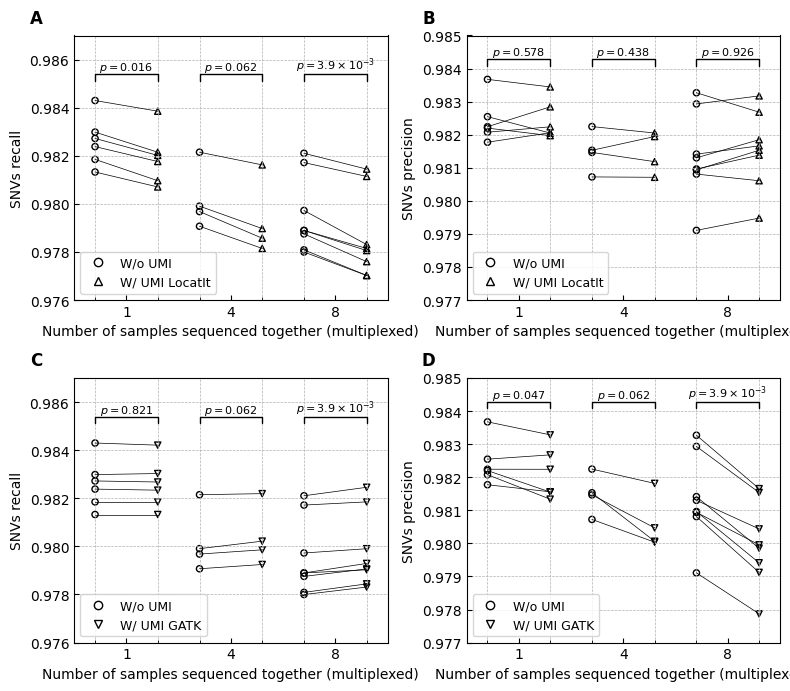

In [18]:
plt.style.use('default')
fig = plt.figure(figsize=(8, 7), dpi = 100)

plexings = [1, 4, 8]
plexing_positions = [1, 2, 3]

df_temp_noumi = df_variants[(df_variants.Filter == 'ALL') & (df_variants.Type == 'SNP') & (df_variants.Batch == 2)]
df_temp_umi_locatit = df_umi_locatit_variants[(df_umi_locatit_variants.Filter == 'ALL') & (df_umi_locatit_variants.Type == 'SNP') & (df_umi_locatit_variants.Batch == 2)]
df_temp_umi_gatk = df_umi_gatk_variants[(df_umi_gatk_variants.Filter == 'ALL') & (df_umi_gatk_variants.Type == 'SNP') & (df_umi_gatk_variants.Batch == 2)]
assert len(df_temp_noumi) == len(df_temp_umi_locatit)
assert len(df_temp_noumi) == len(df_temp_umi_gatk)

df_temp_merged_locatit = df_temp_noumi.merge(df_temp_umi_locatit, on = ['ID', 'HGID', 'Batch', 'Plexing'], suffixes = ['_NOUMI', '_UMI'])
assert len(df_temp_merged_locatit) == len(df_temp_noumi)

df_temp_merged_gatk = df_temp_noumi.merge(df_temp_umi_gatk, on = ['ID', 'HGID', 'Batch', 'Plexing'], suffixes = ['_NOUMI', '_UMI'])
assert len(df_temp_merged_gatk) == len(df_temp_noumi)


# FIGURE A.
# ============== #
ax = fig.add_subplot(2, 2, 1)
data = dict()
for x, plexing in zip(plexing_positions, plexings):
    df_temp = df_temp_merged_locatit[df_temp_merged_locatit.Plexing == plexing]
    for idx, row in df_temp[['Recall_NOUMI', 'Recall_UMI']].iterrows():
        ax.plot([x - 0.3, x + 0.3], [row['Recall_NOUMI'], row['Recall_UMI']], color = 'black', linewidth = 0.5)
    data[plexing] = { 'NOUMI': df_temp['Recall_NOUMI'], 'UMI': df_temp['Recall_UMI'] }
    ax.scatter([x - 0.3] * len(df_temp), data[plexing]['NOUMI'], marker = 'o', edgecolor = 'black', facecolor = 'none', s = 20)
    ax.scatter([x + 0.3] * len(df_temp), data[plexing]['UMI'], marker = '^', edgecolor = 'black', facecolor = 'none', s = 20)
ax.tick_params(axis = 'both', direction = 'in', which = 'both')
ax.set_xticks([x - 0.3 for x in plexing_positions] + [x + 0.3 for x in plexing_positions], minor = True)
ax.xaxis.grid(True, which = 'minor', linestyle = '--', linewidth = 0.5)
ax.yaxis.grid(True, which = 'major', linestyle = '--', linewidth = 0.5)
ax.set_xticks(plexing_positions)
ax.set_xticklabels(plexings)
# Limits. Must be set before text annotations.
ax.set_xlim([0.5,  3.5])
ax.set_ylim([0.976,  0.987])
for x, plexing in zip(plexing_positions, plexings):
    pvalue = stats.wilcoxon(data[plexing]['NOUMI'], data[plexing]['UMI'], alternative = "greater")[1] # Wilcoxon signed-ranks test
    annotate_pvalue(ax, x - 0.3, x + 0.3, 0.985, pvalue, 0.15)
ax.set_ylabel('SNVs recall')
ax.set_xlabel('Number of samples sequenced together (multiplexed)')
legend_elements = [
    Line2D([0], [0], marker = 'o', markeredgecolor = 'black', markerfacecolor = 'none', color = 'none', label='W/o UMI'), 
    Line2D([0], [0], marker = '^', markeredgecolor = 'black', markerfacecolor = 'none', color = 'none', label='W/ UMI LocatIt'),
]
ax.legend(handles = legend_elements, loc = 3, prop = {'size': 9})
ax.text(-0.1, 1.1, 'A', transform = ax.transAxes, fontsize = 12, fontweight = 'bold', va = 'top', ha = 'right')


# FIGURE B.
# ============== #
ax = fig.add_subplot(2, 2, 2)
data = dict()
for x, plexing in zip(plexing_positions, plexings):
    df_temp = df_temp_merged_locatit[df_temp_merged_locatit.Plexing == plexing]
    for idx, row in df_temp[['Precision_NOUMI', 'Precision_UMI']].iterrows():
        ax.plot([x - 0.3, x + 0.3], [row['Precision_NOUMI'], row['Precision_UMI']], color = 'black', linewidth = 0.5)
    data[plexing] = { 'NOUMI': df_temp['Precision_NOUMI'], 'UMI': df_temp['Precision_UMI'] }
    ax.scatter([x - 0.3] * len(df_temp), data[plexing]['NOUMI'], marker = 'o', edgecolor = 'black', facecolor = 'none', s = 20)
    ax.scatter([x + 0.3] * len(df_temp), data[plexing]['UMI'], marker = '^', edgecolor = 'black', facecolor = 'none', s = 20)
ax.tick_params(axis = 'both', direction = 'in', which = 'both')
ax.set_xticks([x - 0.3 for x in plexing_positions] + [x + 0.3 for x in plexing_positions], minor = True)
ax.xaxis.grid(True, which = 'minor', linestyle = '--', linewidth = 0.5)
ax.yaxis.grid(True, which = 'major', linestyle = '--', linewidth = 0.5)
ax.set_xticks(plexing_positions)
ax.set_xticklabels(plexings)
# Limits. Must be set before text annotations.
ax.set_xlim([0.5,  3.5])
ax.set_ylim([0.977,  0.985])
for x, plexing in zip(plexing_positions, plexings):
    pvalue = stats.wilcoxon(data[plexing]['NOUMI'], data[plexing]['UMI'], alternative = "greater")[1] # Wilcoxon signed-ranks test
    annotate_pvalue(ax, x - 0.3, x + 0.3, 0.984, pvalue, 0.15)
ax.set_ylabel('SNVs precision')
ax.set_xlabel('Number of samples sequenced together (multiplexed)')
legend_elements = [
    Line2D([0], [0], marker = 'o', markeredgecolor = 'black', markerfacecolor = 'none', color = 'none', label='W/o UMI'), 
    Line2D([0], [0], marker = '^', markeredgecolor = 'black', markerfacecolor = 'none', color = 'none', label='W/ UMI LocatIt'),
]
ax.legend(handles = legend_elements, loc = 3, prop = {'size': 9})
ax.text(-0.1, 1.1, 'B', transform = ax.transAxes, fontsize = 12, fontweight = 'bold', va = 'top', ha = 'right')


# FIGURE C.
# ============== #
ax = fig.add_subplot(2, 2, 3)
data = dict()
for x, plexing in zip(plexing_positions, plexings):
    df_temp = df_temp_merged_gatk[df_temp_merged_gatk.Plexing == plexing]
    for idx, row in df_temp[['Recall_NOUMI', 'Recall_UMI']].iterrows():
        ax.plot([x - 0.3, x + 0.3], [row['Recall_NOUMI'], row['Recall_UMI']], color = 'black', linewidth = 0.5)
    data[plexing] = { 'NOUMI': df_temp['Recall_NOUMI'], 'UMI': df_temp['Recall_UMI'] }
    ax.scatter([x - 0.3] * len(df_temp), data[plexing]['NOUMI'], marker = 'o', edgecolor = 'black', facecolor = 'none', s = 20)
    ax.scatter([x + 0.3] * len(df_temp), data[plexing]['UMI'], marker = 'v', edgecolor = 'black', facecolor = 'none', s = 20)
ax.tick_params(axis = 'both', direction = 'in', which = 'both')
ax.set_xticks([x - 0.3 for x in plexing_positions] + [x + 0.3 for x in plexing_positions], minor = True)
ax.xaxis.grid(True, which = 'minor', linestyle = '--', linewidth = 0.5)
ax.yaxis.grid(True, which = 'major', linestyle = '--', linewidth = 0.5)
ax.set_xticks(plexing_positions)
ax.set_xticklabels(plexings)
# Limits. Must be set before text annotations.
ax.set_xlim([0.5,  3.5])
ax.set_ylim([0.976,  0.987])
for x, plexing in zip(plexing_positions, plexings):
    pvalue = stats.wilcoxon(data[plexing]['NOUMI'], data[plexing]['UMI'], alternative = "less")[1] # Wilcoxon signed-ranks test
    annotate_pvalue(ax, x - 0.3, x + 0.3, 0.985, pvalue, 0.15)
ax.set_ylabel('SNVs recall')
ax.set_xlabel('Number of samples sequenced together (multiplexed)')
legend_elements = [
    Line2D([0], [0], marker = 'o', markeredgecolor = 'black', markerfacecolor = 'none', color = 'none', label='W/o UMI'), 
    Line2D([0], [0], marker = 'v', markeredgecolor = 'black', markerfacecolor = 'none', color = 'none', label='W/ UMI GATK'),
]
ax.legend(handles = legend_elements, loc = 3, prop = {'size': 9})
ax.text(-0.1, 1.1, 'C', transform = ax.transAxes, fontsize = 12, fontweight = 'bold', va = 'top', ha = 'right')


# FIGURE D.
# ============== #
ax = fig.add_subplot(2, 2, 4)
data = dict()
for x, plexing in zip(plexing_positions, plexings):
    df_temp = df_temp_merged_gatk[df_temp_merged_gatk.Plexing == plexing]
    for idx, row in df_temp[['Precision_NOUMI', 'Precision_UMI']].iterrows():
        ax.plot([x - 0.3, x + 0.3], [row['Precision_NOUMI'], row['Precision_UMI']], color = 'black', linewidth = 0.5)
    data[plexing] = { 'NOUMI': df_temp['Precision_NOUMI'], 'UMI': df_temp['Precision_UMI'] }
    ax.scatter([x - 0.3] * len(df_temp), data[plexing]['NOUMI'], marker = 'o', edgecolor = 'black', facecolor = 'none', s = 20)
    ax.scatter([x + 0.3] * len(df_temp), data[plexing]['UMI'], marker = 'v', edgecolor = 'black', facecolor = 'none', s = 20)
ax.tick_params(axis = 'both', direction = 'in', which = 'both')
ax.set_xticks([x - 0.3 for x in plexing_positions] + [x + 0.3 for x in plexing_positions], minor = True)
ax.xaxis.grid(True, which = 'minor', linestyle = '--', linewidth = 0.5)
ax.yaxis.grid(True, which = 'major', linestyle = '--', linewidth = 0.5)
ax.set_xticks(plexing_positions)
ax.set_xticklabels(plexings)
# Limits. Must be set before text annotations.
ax.set_xlim([0.5,  3.5])
ax.set_ylim([0.977,  0.985])
for x, plexing in zip(plexing_positions, plexings):
    pvalue = stats.wilcoxon(data[plexing]['NOUMI'], data[plexing]['UMI'], alternative = "greater")[1] # Wilcoxon signed-ranks test
    annotate_pvalue(ax, x - 0.3, x + 0.3, 0.984, pvalue, 0.15)
ax.set_ylabel('SNVs precision')
ax.set_xlabel('Number of samples sequenced together (multiplexed)')
legend_elements = [
    Line2D([0], [0], marker = 'o', markeredgecolor = 'black', markerfacecolor = 'none', color = 'none', label='W/o UMI'), 
    Line2D([0], [0], marker = 'v', markeredgecolor = 'black', markerfacecolor = 'none', color = 'none', label='W/ UMI GATK'),
]
ax.legend(handles = legend_elements, loc = 3, prop = {'size': 9})
ax.text(-0.1, 1.1, 'D', transform = ax.transAxes, fontsize = 12, fontweight = 'bold', va = 'top', ha = 'right')

plt.tight_layout()
plt.show()

### FIGURE: Variant recall and precision rates in WES experiments with multiplexing before and after adding 2X WGS data.

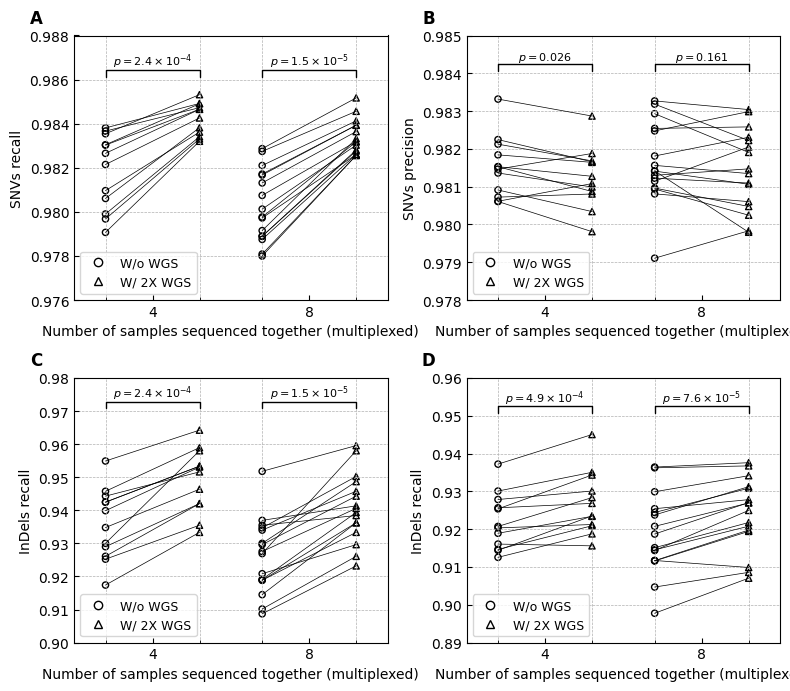

In [19]:
plt.style.use('default')
fig = plt.figure(figsize=(8, 7), dpi = 100)

plexings = [4, 8]
plexing_positions = [1, 2]

df_wes_snvs = df_variants[(df_variants.Filter == 'ALL') & (df_variants.Type == 'SNP') & (df_variants.Plexing != 1)]
df_wegs2x_snvs = df_wegs_variants[(df_wegs_variants.Filter == 'ALL') & (df_wegs_variants.Type == 'SNP') & (df_wegs_variants.WGS_depth == 2)]
assert len(df_wes_snvs) == len(df_wegs2x_snvs)

df_wes_indels = df_variants[(df_variants.Filter == 'ALL') & (df_variants.Type == 'INDEL') & (df_variants.Plexing != 1)]
df_wegs2x_indels = df_wegs_variants[(df_wegs_variants.Filter == 'ALL') & (df_wegs_variants.Type == 'INDEL') & (df_wegs_variants.WGS_depth == 2)]
assert len(df_wes_indels) == len(df_wegs2x_indels)

df_wes_vs_wegs2x_snvs = df_wes_snvs.merge(df_wegs2x_snvs, on = ['ID', 'HGID', 'Batch', 'Plexing'], suffixes = ['_NOWGS', '_2XWGS'])
assert len(df_wes_vs_wegs2x_snvs) == len(df_wes_snvs)

df_wes_vs_wegs2x_indels = df_wes_indels.merge(df_wegs2x_indels, on = ['ID', 'HGID', 'Batch', 'Plexing'], suffixes = ['_NOWGS', '_2XWGS'])
assert len(df_wes_vs_wegs2x_indels) == len(df_wes_indels)


# FIGURE A.
# ============== #
ax = fig.add_subplot(2, 2, 1)
data = dict()
for x, plexing in zip(plexing_positions, plexings):
    df_temp = df_wes_vs_wegs2x_snvs[df_wes_vs_wegs2x_snvs.Plexing == plexing]
    for idx, row in df_temp[['Recall_NOWGS', 'Recall_2XWGS']].iterrows():
        ax.plot([x - 0.3, x + 0.3], [row['Recall_NOWGS'], row['Recall_2XWGS']], color = 'black', linewidth = 0.5)
    data[plexing] = { 'NOWGS': df_temp['Recall_NOWGS'], '2XWGS': df_temp['Recall_2XWGS'] }
    ax.scatter([x - 0.3] * len(df_temp), data[plexing]['NOWGS'], marker = 'o', edgecolor = 'black', facecolor = 'none', s = 20)
    ax.scatter([x + 0.3] * len(df_temp), data[plexing]['2XWGS'], marker = '^', edgecolor = 'black', facecolor = 'none', s = 20)
ax.tick_params(axis = 'both', direction = 'in', which = 'both')
ax.set_xticks([x - 0.3 for x in plexing_positions] + [x + 0.3 for x in plexing_positions], minor = True)
ax.xaxis.grid(True, which = 'minor', linestyle = '--', linewidth = 0.5)
ax.yaxis.grid(True, which = 'major', linestyle = '--', linewidth = 0.5)
ax.set_xticks(plexing_positions)
ax.set_xticklabels(plexings)
# Limits. Must be set before text annotations.
ax.set_xlim([0.5,  2.5])
ax.set_ylim([0.976,  0.988])
for x, plexing in zip(plexing_positions, plexings):
    pvalue = stats.wilcoxon(data[plexing]['NOWGS'], data[plexing]['2XWGS'], alternative = "less")[1] # Wilcoxon signed-ranks test
    annotate_pvalue(ax, x - 0.3, x + 0.3, 0.986, pvalue, 0.10)
ax.set_ylabel('SNVs recall')
ax.set_xlabel('Number of samples sequenced together (multiplexed)')
legend_elements = [
    Line2D([0], [0], marker = 'o', markeredgecolor = 'black', markerfacecolor = 'none', color = 'none', label='W/o WGS'), 
    Line2D([0], [0], marker = '^', markeredgecolor = 'black', markerfacecolor = 'none', color = 'none', label='W/ 2X WGS'),
]
ax.legend(handles = legend_elements, loc = 3, prop = {'size': 9})
ax.text(-0.1, 1.1, 'A', transform = ax.transAxes, fontsize = 12, fontweight = 'bold', va = 'top', ha = 'right')


# FIGURE B.
# ============== #
ax = fig.add_subplot(2, 2, 2)
data = dict()
for x, plexing in zip(plexing_positions, plexings):
    df_temp = df_wes_vs_wegs2x_snvs[df_wes_vs_wegs2x_snvs.Plexing == plexing]
    for idx, row in df_temp[['Precision_NOWGS', 'Precision_2XWGS']].iterrows():
        ax.plot([x - 0.3, x + 0.3], [row['Precision_NOWGS'], row['Precision_2XWGS']], color = 'black', linewidth = 0.5)
    data[plexing] = { 'NOWGS': df_temp['Precision_NOWGS'], '2XWGS': df_temp['Precision_2XWGS'] }
    ax.scatter([x - 0.3] * len(df_temp), data[plexing]['NOWGS'], marker = 'o', edgecolor = 'black', facecolor = 'none', s = 20)
    ax.scatter([x + 0.3] * len(df_temp), data[plexing]['2XWGS'], marker = '^', edgecolor = 'black', facecolor = 'none', s = 20)
ax.tick_params(axis = 'both', direction = 'in', which = 'both')
ax.set_xticks([x - 0.3 for x in plexing_positions] + [x + 0.3 for x in plexing_positions], minor = True)
ax.xaxis.grid(True, which = 'minor', linestyle = '--', linewidth = 0.5)
ax.yaxis.grid(True, which = 'major', linestyle = '--', linewidth = 0.5)
ax.set_xticks(plexing_positions)
ax.set_xticklabels(plexings)
# Limits. Must be set before text annotations.
ax.set_xlim([0.5,  2.5])
ax.set_ylim([0.978,  0.985])
for x, plexing in zip(plexing_positions, plexings):
    # print(np.mean(data[plexing]['NOWGS'] - data[plexing]['2XWGS']))
    pvalue = stats.wilcoxon(data[plexing]['NOWGS'], data[plexing]['2XWGS'], alternative = "greater")[1] # Wilcoxon signed-ranks test
    annotate_pvalue(ax, x - 0.3, x + 0.3, 0.984, pvalue, 0.10)

ax.set_ylabel('SNVs precision')
ax.set_xlabel('Number of samples sequenced together (multiplexed)')
legend_elements = [
    Line2D([0], [0], marker = 'o', markeredgecolor = 'black', markerfacecolor = 'none', color = 'none', label='W/o WGS'), 
    Line2D([0], [0], marker = '^', markeredgecolor = 'black', markerfacecolor = 'none', color = 'none', label='W/ 2X WGS'),
]
ax.legend(handles = legend_elements, loc = 3, prop = {'size': 9})
ax.text(-0.1, 1.1, 'B', transform = ax.transAxes, fontsize = 12, fontweight = 'bold', va = 'top', ha = 'right')


# FIGURE C.
# ============== #
ax = fig.add_subplot(2, 2, 3)
data = dict()
for x, plexing in zip(plexing_positions, plexings):
    df_temp = df_wes_vs_wegs2x_indels[df_wes_vs_wegs2x_indels.Plexing == plexing]
    for idx, row in df_temp[['Recall_NOWGS', 'Recall_2XWGS']].iterrows():
        ax.plot([x - 0.3, x + 0.3], [row['Recall_NOWGS'], row['Recall_2XWGS']], color = 'black', linewidth = 0.5)
    data[plexing] = { 'NOWGS': df_temp['Recall_NOWGS'], '2XWGS': df_temp['Recall_2XWGS'] }
    ax.scatter([x - 0.3] * len(df_temp), data[plexing]['NOWGS'], marker = 'o', edgecolor = 'black', facecolor = 'none', s = 20)
    ax.scatter([x + 0.3] * len(df_temp), data[plexing]['2XWGS'], marker = '^', edgecolor = 'black', facecolor = 'none', s = 20)
ax.tick_params(axis = 'both', direction = 'in', which = 'both')
ax.set_xticks([x - 0.3 for x in plexing_positions] + [x + 0.3 for x in plexing_positions], minor = True)
ax.xaxis.grid(True, which = 'minor', linestyle = '--', linewidth = 0.5)
ax.yaxis.grid(True, which = 'major', linestyle = '--', linewidth = 0.5)
ax.set_xticks(plexing_positions)
ax.set_xticklabels(plexings)
# Limits. Must be set before text annotations.
ax.set_xlim([0.5,  2.5])
ax.set_ylim([0.90,  0.98])
for x, plexing in zip(plexing_positions, plexings):
    pvalue = stats.wilcoxon(data[plexing]['NOWGS'], data[plexing]['2XWGS'], alternative = "less")[1] # Wilcoxon signed-ranks test
    annotate_pvalue(ax, x - 0.3, x + 0.3, 0.970, pvalue, 0.10)
ax.set_ylabel('InDels recall')
ax.set_xlabel('Number of samples sequenced together (multiplexed)')
legend_elements = [
    Line2D([0], [0], marker = 'o', markeredgecolor = 'black', markerfacecolor = 'none', color = 'none', label='W/o WGS'), 
    Line2D([0], [0], marker = '^', markeredgecolor = 'black', markerfacecolor = 'none', color = 'none', label='W/ 2X WGS'),
]
ax.legend(handles = legend_elements, loc = 3, prop = {'size': 9})
ax.text(-0.1, 1.1, 'C', transform = ax.transAxes, fontsize = 12, fontweight = 'bold', va = 'top', ha = 'right')


# FIGURE D.
# ============== #
ax = fig.add_subplot(2, 2, 4)
data = dict()
for x, plexing in zip(plexing_positions, plexings):
    df_temp = df_wes_vs_wegs2x_indels[df_wes_vs_wegs2x_indels.Plexing == plexing]
    for idx, row in df_temp[['Precision_NOWGS', 'Precision_2XWGS']].iterrows():
        ax.plot([x - 0.3, x + 0.3], [row['Precision_NOWGS'], row['Precision_2XWGS']], color = 'black', linewidth = 0.5)
    data[plexing] = { 'NOWGS': df_temp['Precision_NOWGS'], '2XWGS': df_temp['Precision_2XWGS'] }
    ax.scatter([x - 0.3] * len(df_temp), data[plexing]['NOWGS'], marker = 'o', edgecolor = 'black', facecolor = 'none', s = 20)
    ax.scatter([x + 0.3] * len(df_temp), data[plexing]['2XWGS'], marker = '^', edgecolor = 'black', facecolor = 'none', s = 20)
ax.tick_params(axis = 'both', direction = 'in', which = 'both')
ax.set_xticks([x - 0.3 for x in plexing_positions] + [x + 0.3 for x in plexing_positions], minor = True)
ax.xaxis.grid(True, which = 'minor', linestyle = '--', linewidth = 0.5)
ax.yaxis.grid(True, which = 'major', linestyle = '--', linewidth = 0.5)
ax.set_xticks(plexing_positions)
ax.set_xticklabels(plexings)
# Limits. Must be set before text annotations.
ax.set_xlim([0.5,  2.5])
ax.set_ylim([0.89,  0.96])
for x, plexing in zip(plexing_positions, plexings):
    pvalue = stats.wilcoxon(data[plexing]['NOWGS'], data[plexing]['2XWGS'], alternative = "less")[1] # Wilcoxon signed-ranks test
    annotate_pvalue(ax, x - 0.3, x + 0.3, 0.95, pvalue, 0.10)
ax.set_ylabel('InDels recall')
ax.set_xlabel('Number of samples sequenced together (multiplexed)')
legend_elements = [
    Line2D([0], [0], marker = 'o', markeredgecolor = 'black', markerfacecolor = 'none', color = 'none', label='W/o WGS'), 
    Line2D([0], [0], marker = '^', markeredgecolor = 'black', markerfacecolor = 'none', color = 'none', label='W/ 2X WGS'),
]
ax.legend(handles = legend_elements, loc = 3, prop = {'size': 9})
ax.text(-0.1, 1.1, 'D', transform = ax.transAxes, fontsize = 12, fontweight = 'bold', va = 'top', ha = 'right')


plt.tight_layout()
plt.show()

### FIGURE: Variant recall and precision rates in WES experiments with multiplexing before and after adding 5X WGS data.

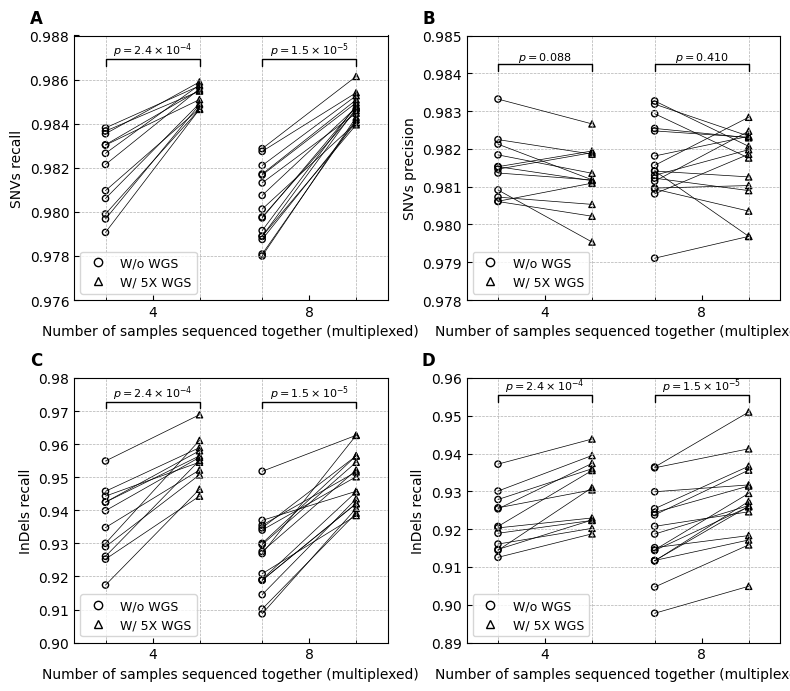

In [20]:
plt.style.use('default')
fig = plt.figure(figsize=(8, 7), dpi = 100)

plexings = [4, 8]
plexing_positions = [1, 2]

df_wes_snvs = df_variants[(df_variants.Filter == 'ALL') & (df_variants.Type == 'SNP') & (df_variants.Plexing != 1)]
df_wegs5x_snvs = df_wegs_variants[(df_wegs_variants.Filter == 'ALL') & (df_wegs_variants.Type == 'SNP') & (df_wegs_variants.WGS_depth == 5)]
assert len(df_wes_snvs) == len(df_wegs5x_snvs)

df_wes_indels = df_variants[(df_variants.Filter == 'ALL') & (df_variants.Type == 'INDEL') & (df_variants.Plexing != 1)]
df_wegs5x_indels = df_wegs_variants[(df_wegs_variants.Filter == 'ALL') & (df_wegs_variants.Type == 'INDEL') & (df_wegs_variants.WGS_depth == 5)]
assert len(df_wes_indels) == len(df_wegs5x_indels)

df_wes_vs_wegs5x_snvs = df_wes_snvs.merge(df_wegs5x_snvs, on = ['ID', 'HGID', 'Batch', 'Plexing'], suffixes = ['_NOWGS', '_5XWGS'])
assert len(df_wes_vs_wegs5x_snvs) == len(df_wes_snvs)

df_wes_vs_wegs5x_indels = df_wes_indels.merge(df_wegs5x_indels, on = ['ID', 'HGID', 'Batch', 'Plexing'], suffixes = ['_NOWGS', '_5XWGS'])
assert len(df_wes_vs_wegs5x_indels) == len(df_wes_indels)


# FIGURE A.
# ============== #
ax = fig.add_subplot(2, 2, 1)
data = dict()
for x, plexing in zip(plexing_positions, plexings):
    df_temp = df_wes_vs_wegs5x_snvs[df_wes_vs_wegs5x_snvs.Plexing == plexing]
    for idx, row in df_temp[['Recall_NOWGS', 'Recall_5XWGS']].iterrows():
        ax.plot([x - 0.3, x + 0.3], [row['Recall_NOWGS'], row['Recall_5XWGS']], color = 'black', linewidth = 0.5)
    data[plexing] = { 'NOWGS': df_temp['Recall_NOWGS'], '5XWGS': df_temp['Recall_5XWGS'] }
    ax.scatter([x - 0.3] * len(df_temp), data[plexing]['NOWGS'], marker = 'o', edgecolor = 'black', facecolor = 'none', s = 20)
    ax.scatter([x + 0.3] * len(df_temp), data[plexing]['5XWGS'], marker = '^', edgecolor = 'black', facecolor = 'none', s = 20)
ax.tick_params(axis = 'both', direction = 'in', which = 'both')
ax.set_xticks([x - 0.3 for x in plexing_positions] + [x + 0.3 for x in plexing_positions], minor = True)
ax.xaxis.grid(True, which = 'minor', linestyle = '--', linewidth = 0.5)
ax.yaxis.grid(True, which = 'major', linestyle = '--', linewidth = 0.5)
ax.set_xticks(plexing_positions)
ax.set_xticklabels(plexings)
# Limits. Must be set before text annotations.
ax.set_xlim([0.5,  2.5])
ax.set_ylim([0.976,  0.988])
for x, plexing in zip(plexing_positions, plexings):
    pvalue = stats.wilcoxon(data[plexing]['NOWGS'], data[plexing]['5XWGS'], alternative = "less")[1] # Wilcoxon signed-ranks test
    annotate_pvalue(ax, x - 0.3, x + 0.3, 0.9865, pvalue, 0.10)
ax.set_ylabel('SNVs recall')
ax.set_xlabel('Number of samples sequenced together (multiplexed)')
legend_elements = [
    Line2D([0], [0], marker = 'o', markeredgecolor = 'black', markerfacecolor = 'none', color = 'none', label='W/o WGS'), 
    Line2D([0], [0], marker = '^', markeredgecolor = 'black', markerfacecolor = 'none', color = 'none', label='W/ 5X WGS'),
]
ax.legend(handles = legend_elements, loc = 3, prop = {'size': 9})
ax.text(-0.1, 1.1, 'A', transform = ax.transAxes, fontsize = 12, fontweight = 'bold', va = 'top', ha = 'right')


# FIGURE B.
# ============== #
ax = fig.add_subplot(2, 2, 2)
data = dict()
for x, plexing in zip(plexing_positions, plexings):
    df_temp = df_wes_vs_wegs5x_snvs[df_wes_vs_wegs5x_snvs.Plexing == plexing]
    for idx, row in df_temp[['Precision_NOWGS', 'Precision_5XWGS']].iterrows():
        ax.plot([x - 0.3, x + 0.3], [row['Precision_NOWGS'], row['Precision_5XWGS']], color = 'black', linewidth = 0.5)
    data[plexing] = { 'NOWGS': df_temp['Precision_NOWGS'], '5XWGS': df_temp['Precision_5XWGS'] }
    ax.scatter([x - 0.3] * len(df_temp), data[plexing]['NOWGS'], marker = 'o', edgecolor = 'black', facecolor = 'none', s = 20)
    ax.scatter([x + 0.3] * len(df_temp), data[plexing]['5XWGS'], marker = '^', edgecolor = 'black', facecolor = 'none', s = 20)
ax.tick_params(axis = 'both', direction = 'in', which = 'both')
ax.set_xticks([x - 0.3 for x in plexing_positions] + [x + 0.3 for x in plexing_positions], minor = True)
ax.xaxis.grid(True, which = 'minor', linestyle = '--', linewidth = 0.5)
ax.yaxis.grid(True, which = 'major', linestyle = '--', linewidth = 0.5)
ax.set_xticks(plexing_positions)
ax.set_xticklabels(plexings)
# Limits. Must be set before text annotations.
ax.set_xlim([0.5,  2.5])
ax.set_ylim([0.978,  0.985])
for x, plexing in zip(plexing_positions, plexings):
    pvalue = stats.wilcoxon(data[plexing]['NOWGS'], data[plexing]['5XWGS'], alternative = "greater")[1] # Wilcoxon signed-ranks test
    annotate_pvalue(ax, x - 0.3, x + 0.3, 0.984, pvalue, 0.10)
ax.set_ylabel('SNVs precision')
ax.set_xlabel('Number of samples sequenced together (multiplexed)')
legend_elements = [
    Line2D([0], [0], marker = 'o', markeredgecolor = 'black', markerfacecolor = 'none', color = 'none', label='W/o WGS'), 
    Line2D([0], [0], marker = '^', markeredgecolor = 'black', markerfacecolor = 'none', color = 'none', label='W/ 5X WGS'),
]
ax.legend(handles = legend_elements, loc = 3, prop = {'size': 9})
ax.text(-0.1, 1.1, 'B', transform = ax.transAxes, fontsize = 12, fontweight = 'bold', va = 'top', ha = 'right')


# FIGURE C.
# ============== #
ax = fig.add_subplot(2, 2, 3)
data = dict()
for x, plexing in zip(plexing_positions, plexings):
    df_temp = df_wes_vs_wegs5x_indels[df_wes_vs_wegs5x_indels.Plexing == plexing]
    for idx, row in df_temp[['Recall_NOWGS', 'Recall_5XWGS']].iterrows():
        ax.plot([x - 0.3, x + 0.3], [row['Recall_NOWGS'], row['Recall_5XWGS']], color = 'black', linewidth = 0.5)
    data[plexing] = { 'NOWGS': df_temp['Recall_NOWGS'], '5XWGS': df_temp['Recall_5XWGS'] }
    ax.scatter([x - 0.3] * len(df_temp), data[plexing]['NOWGS'], marker = 'o', edgecolor = 'black', facecolor = 'none', s = 20)
    ax.scatter([x + 0.3] * len(df_temp), data[plexing]['5XWGS'], marker = '^', edgecolor = 'black', facecolor = 'none', s = 20)
ax.tick_params(axis = 'both', direction = 'in', which = 'both')
ax.set_xticks([x - 0.3 for x in plexing_positions] + [x + 0.3 for x in plexing_positions], minor = True)
ax.xaxis.grid(True, which = 'minor', linestyle = '--', linewidth = 0.5)
ax.yaxis.grid(True, which = 'major', linestyle = '--', linewidth = 0.5)
ax.set_xticks(plexing_positions)
ax.set_xticklabels(plexings)
# Limits. Must be set before text annotations.
ax.set_xlim([0.5,  2.5])
ax.set_ylim([0.90,  0.98])
for x, plexing in zip(plexing_positions, plexings):
    pvalue = stats.wilcoxon(data[plexing]['NOWGS'], data[plexing]['5XWGS'], alternative = "less")[1] # Wilcoxon signed-ranks test
    annotate_pvalue(ax, x - 0.3, x + 0.3, 0.970, pvalue, 0.10)
ax.set_ylabel('InDels recall')
ax.set_xlabel('Number of samples sequenced together (multiplexed)')
legend_elements = [
    Line2D([0], [0], marker = 'o', markeredgecolor = 'black', markerfacecolor = 'none', color = 'none', label='W/o WGS'), 
    Line2D([0], [0], marker = '^', markeredgecolor = 'black', markerfacecolor = 'none', color = 'none', label='W/ 5X WGS'),
]
ax.legend(handles = legend_elements, loc = 3, prop = {'size': 9})
ax.text(-0.1, 1.1, 'C', transform = ax.transAxes, fontsize = 12, fontweight = 'bold', va = 'top', ha = 'right')


# FIGURE D.
# ============== #
ax = fig.add_subplot(2, 2, 4)
data = dict()
for x, plexing in zip(plexing_positions, plexings):
    df_temp = df_wes_vs_wegs5x_indels[df_wes_vs_wegs5x_indels.Plexing == plexing]
    for idx, row in df_temp[['Precision_NOWGS', 'Precision_5XWGS']].iterrows():
        ax.plot([x - 0.3, x + 0.3], [row['Precision_NOWGS'], row['Precision_5XWGS']], color = 'black', linewidth = 0.5)
    data[plexing] = { 'NOWGS': df_temp['Precision_NOWGS'], '5XWGS': df_temp['Precision_5XWGS'] }
    ax.scatter([x - 0.3] * len(df_temp), data[plexing]['NOWGS'], marker = 'o', edgecolor = 'black', facecolor = 'none', s = 20)
    ax.scatter([x + 0.3] * len(df_temp), data[plexing]['5XWGS'], marker = '^', edgecolor = 'black', facecolor = 'none', s = 20)
ax.tick_params(axis = 'both', direction = 'in', which = 'both')
ax.set_xticks([x - 0.3 for x in plexing_positions] + [x + 0.3 for x in plexing_positions], minor = True)
ax.xaxis.grid(True, which = 'minor', linestyle = '--', linewidth = 0.5)
ax.yaxis.grid(True, which = 'major', linestyle = '--', linewidth = 0.5)
ax.set_xticks(plexing_positions)
ax.set_xticklabels(plexings)
# Limits. Must be set before text annotations.
ax.set_xlim([0.5,  2.5])
ax.set_ylim([0.89,  0.96])
for x, plexing in zip(plexing_positions, plexings):
    pvalue = stats.wilcoxon(data[plexing]['NOWGS'], data[plexing]['5XWGS'], alternative = "less")[1] # Wilcoxon signed-ranks test
    annotate_pvalue(ax, x - 0.3, x + 0.3, 0.953, pvalue, 0.10)
ax.set_ylabel('InDels recall')
ax.set_xlabel('Number of samples sequenced together (multiplexed)')
legend_elements = [
    Line2D([0], [0], marker = 'o', markeredgecolor = 'black', markerfacecolor = 'none', color = 'none', label='W/o WGS'), 
    Line2D([0], [0], marker = '^', markeredgecolor = 'black', markerfacecolor = 'none', color = 'none', label='W/ 5X WGS'),
]
ax.legend(handles = legend_elements, loc = 3, prop = {'size': 9})
ax.text(-0.1, 1.1, 'D', transform = ax.transAxes, fontsize = 12, fontweight = 'bold', va = 'top', ha = 'right')


plt.tight_layout()
plt.show()

### TABLE: The average changes in SNVs and InDels calling in whole exome sequencing experiments when adding additional whole genome sequencing reads relative to pure whole exome sequencing experiments.

In [21]:
data = {
    'Number of samples sequenced together (multiplexed)': [],
    'WGS DP': [],
    'SNV N (SE)': [],
    'SNV TP (SE)': [],
    'SNV FP (SE)': [],
    'SNV FN (SE)': [],
    'SNV Recall (SE)': [],
    'SNV Precision (SE)': [],
    'InDel N (SE)': [],
    'InDel TP (SE)': [],
    'InDel FP (SE)': [],
    'InDel FN (SE)': [],
    'InDel Recall (SE)': [],
    'InDel Precision (SE)': [],
}

def sign_symbol(pval):
    if pval <= 0.001:
        return '***'
    elif pval <= 0.01:
        return '**'
    elif pval <= 0.05:
        return '*'
    else:
        return ''

for wgs_depth in [2, 5]:
    for plexing in [4, 8]:
        data['Number of samples sequenced together (multiplexed)'].append(plexing)
        data['WGS DP'].append(wgs_depth)

        # SNVs
        df_temp = df_variants[(df_variants.Filter == 'ALL') & (df_variants.Type == 'SNP') & (df_variants.Plexing == plexing)]
        df_wegs_temp = df_wegs_variants[(df_wegs_variants.Filter == 'ALL') & (df_wegs_variants.Type == 'SNP') & (df_wegs_variants.Plexing == plexing) & (df_wegs_variants.WGS_depth == wgs_depth)]
        assert len(df_temp) == len(df_wegs_temp)
        df_merged = df_temp.merge(df_wegs_temp, on = ['ID', 'HGID', 'Batch', 'Plexing'], suffixes = ['_NOWGS', '_WGS'])
        assert len(df_temp) == len(df_merged)

        avg = np.mean(df_merged['TP_WGS'] + df_merged['FP_WGS'] - df_merged['TP_NOWGS'] - df_merged['FP_NOWGS'])
        sem = stats.sem(df_merged['TP_WGS'] + df_merged['FP_WGS'] - df_merged['TP_NOWGS'] - df_merged['FP_NOWGS'])
        if (avg < 0):
            pvalue = stats.wilcoxon(df_merged['TP_NOWGS'] + df_merged['FP_NOWGS'], df_merged['TP_WGS'] + df_merged['FP_WGS'], alternative = "greater")[1]
        else:
            pvalue = stats.wilcoxon(df_merged['TP_NOWGS'] + df_merged['FP_NOWGS'], df_merged['TP_WGS'] + df_merged['FP_WGS'], alternative = "less")[1]        
        data['SNV N (SE)'].append(f'{avg:.0f} ({sem:.0f}) {sign_symbol(pvalue)}')
        
        avg = np.mean(df_merged['TP_WGS'] - df_merged['TP_NOWGS'])
        sem = stats.sem(df_merged['TP_WGS'] - df_merged['TP_NOWGS'])
        if (avg < 0):
            pvalue = stats.wilcoxon(df_merged['TP_NOWGS'], df_merged['TP_WGS'], alternative = "greater")[1]
        else:
            pvalue = stats.wilcoxon(df_merged['TP_NOWGS'], df_merged['TP_WGS'], alternative = "less")[1]
        data['SNV TP (SE)'].append(f'{avg:.0f} ({sem:.0f}) {sign_symbol(pvalue)}')

        avg = np.mean(df_merged['FP_WGS'] - df_merged['FP_NOWGS'])
        sem = stats.sem(df_merged['FP_WGS'] - df_merged['FP_NOWGS'])
        if (avg < 0):
            pvalue = stats.wilcoxon(df_merged['FP_NOWGS'], df_merged['FP_WGS'], alternative = "greater")[1]
        else:
            pvalue = stats.wilcoxon(df_merged['FP_NOWGS'], df_merged['FP_WGS'], alternative = "less")[1]
        data['SNV FP (SE)'].append(f'{avg:.0f} ({sem:.0f}) {sign_symbol(pvalue)}')
        
        avg = np.mean(df_merged['FN_WGS'] - df_merged['FN_NOWGS'])
        sem = stats.sem(df_merged['FN_WGS'] - df_merged['FN_NOWGS'])
        if (avg < 0):
            pvalue = stats.wilcoxon(df_merged['FN_NOWGS'], df_merged['FN_WGS'], alternative = "greater")[1]
        else:
            pvalue = stats.wilcoxon(df_merged['FN_NOWGS'], df_merged['FN_WGS'], alternative = "less")[1]
        data['SNV FN (SE)'].append(f'{avg:.0f} ({sem:.0f}) {sign_symbol(pvalue)}')

        avg = np.mean(df_merged['Recall_WGS'] - df_merged['Recall_NOWGS'])
        sem = stats.sem(df_merged['Recall_WGS'] - df_merged['Recall_NOWGS'])
        if (avg < 0):
            pvalue = stats.wilcoxon(df_merged['Recall_NOWGS'], df_merged['Recall_WGS'], alternative = "greater")[1]
        else:
            pvalue = stats.wilcoxon(df_merged['Recall_NOWGS'], df_merged['Recall_WGS'], alternative = "less")[1]
        data['SNV Recall (SE)'].append(f'{avg:.4f} ({sem:.4f}){sign_symbol(pvalue):>3}')

        avg = np.mean(df_merged['Precision_WGS'] - df_merged['Precision_NOWGS'])
        sem = stats.sem(df_merged['Precision_WGS'] - df_merged['Precision_NOWGS'])
        if (avg < 0):
            pvalue = stats.wilcoxon(df_merged['Precision_NOWGS'], df_merged['Precision_WGS'], alternative = "greater")[1]
        else:
            pvalue = stats.wilcoxon(df_merged['Precision_NOWGS'], df_merged['Precision_WGS'], alternative = "less")[1]
        data['SNV Precision (SE)'].append(f'{avg:.4f} ({sem:.4f}){sign_symbol(pvalue)}')        
    
        # InDels
        df_temp = df_variants[(df_variants.Filter == 'ALL') & (df_variants.Type == 'INDEL') & (df_variants.Plexing == plexing)]
        df_wegs_temp = df_wegs_variants[(df_wegs_variants.Filter == 'ALL') & (df_wegs_variants.Type == 'INDEL') & (df_wegs_variants.Plexing == plexing) & (df_wegs_variants.WGS_depth == wgs_depth)]
        assert len(df_temp) == len(df_wegs_temp)
        df_merged = df_temp.merge(df_wegs_temp, on = ['ID', 'HGID', 'Batch', 'Plexing'], suffixes = ['_NOWGS', '_WGS'])
        assert len(df_temp) == len(df_merged)

        avg = np.mean(df_merged['TP_WGS'] + df_merged['FP_WGS'] - df_merged['TP_NOWGS'] - df_merged['FP_NOWGS'])
        sem = stats.sem(df_merged['TP_WGS'] + df_merged['FP_WGS'] - df_merged['TP_NOWGS'] - df_merged['FP_NOWGS'])
        if (avg < 0):
            pvalue = stats.wilcoxon(df_merged['TP_NOWGS'] + df_merged['FP_NOWGS'], df_merged['TP_WGS'] + df_merged['FP_WGS'], alternative = "greater")[1]
        else:
            pvalue = stats.wilcoxon(df_merged['TP_NOWGS'] + df_merged['FP_NOWGS'], df_merged['TP_WGS'] + df_merged['FP_WGS'], alternative = "less")[1]        
        data['InDel N (SE)'].append(f'{avg:.0f} ({sem:.0f}) {sign_symbol(pvalue)}')
        
        avg = np.mean(df_merged['TP_WGS'] - df_merged['TP_NOWGS'])
        sem = stats.sem(df_merged['TP_WGS'] - df_merged['TP_NOWGS'])
        if (avg < 0):
            pvalue = stats.wilcoxon(df_merged['TP_NOWGS'], df_merged['TP_WGS'], alternative = "greater")[1]
        else:
            pvalue = stats.wilcoxon(df_merged['TP_NOWGS'], df_merged['TP_WGS'], alternative = "less")[1]
        data['InDel TP (SE)'].append(f'{avg:.0f} ({sem:.0f}) {sign_symbol(pvalue)}')

        avg = np.mean(df_merged['FP_WGS'] - df_merged['FP_NOWGS'])
        sem = stats.sem(df_merged['FP_WGS'] - df_merged['FP_NOWGS'])
        if (avg < 0):
            pvalue = stats.wilcoxon(df_merged['FP_NOWGS'], df_merged['FP_WGS'], alternative = "greater")[1]
        else:
            pvalue = stats.wilcoxon(df_merged['FP_NOWGS'], df_merged['FP_WGS'], alternative = "less")[1]
        data['InDel FP (SE)'].append(f'{avg:.0f} ({sem:.0f}) {sign_symbol(pvalue)}')
        
        avg = np.mean(df_merged['FN_WGS'] - df_merged['FN_NOWGS'])
        sem = stats.sem(df_merged['FN_WGS'] - df_merged['FN_NOWGS'])
        if (avg < 0):
            pvalue = stats.wilcoxon(df_merged['FN_NOWGS'], df_merged['FN_WGS'], alternative = "greater")[1]
        else:
            pvalue = stats.wilcoxon(df_merged['FN_NOWGS'], df_merged['FN_WGS'], alternative = "less")[1]
        data['InDel FN (SE)'].append(f'{avg:.0f} ({sem:.0f}) {sign_symbol(pvalue)}')

        avg = np.mean(df_merged['Recall_WGS'] - df_merged['Recall_NOWGS'])
        sem = stats.sem(df_merged['Recall_WGS'] - df_merged['Recall_NOWGS'])
        if (avg < 0):
            pvalue = stats.wilcoxon(df_merged['Recall_NOWGS'], df_merged['Recall_WGS'], alternative = "greater")[1]
        else:
            pvalue = stats.wilcoxon(df_merged['Recall_NOWGS'], df_merged['Recall_WGS'], alternative = "less")[1]
        data['InDel Recall (SE)'].append(f'{avg:.4f} ({sem:.4f}){sign_symbol(pvalue):>3}')

        avg = np.mean(df_merged['Precision_WGS'] - df_merged['Precision_NOWGS'])
        sem = stats.sem(df_merged['Precision_WGS'] - df_merged['Precision_NOWGS'])
        if (avg < 0):
            pvalue = stats.wilcoxon(df_merged['Precision_NOWGS'], df_merged['Precision_WGS'], alternative = "greater")[1]
        else:
            pvalue = stats.wilcoxon(df_merged['Precision_NOWGS'], df_merged['Precision_WGS'], alternative = "less")[1]
        data['InDel Precision (SE)'].append(f'{avg:.4f} ({sem:.4f}){sign_symbol(pvalue)}')        

    
pd.DataFrame(data)

/localscratch/dtaliun.15230538.0/lib/python3.9/site-packages/scipy/stats/_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/localscratch/dtaliun.15230538.0/lib/python3.9/site-packages/scipy/stats/_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/localscratch/dtaliun.15230538.0/lib/python3.9/site-packages/scipy/stats/_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/localscratch/dtaliun.15230538.0/lib/python3.9/site-packages/scipy/stats/_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to no

,Number of samples sequenced together (multiplexed),WGS DP,SNV N (SE),SNV TP (SE),SNV FP (SE),SNV FN (SE),SNV Recall (SE),SNV Precision (SE),InDel N (SE),InDel TP (SE),InDel FP (SE),InDel FN (SE),InDel Recall (SE),InDel Precision (SE)
0,4,2,62 (8) ***,54 (7) ***,8 (3) *,-54 (7) ***,0.0024 (0.0003)***,-0.0003 (0.0001)*,6 (1) **,9 (1) ***,-3 (1) **,-9 (1) ***,0.0133 (0.0015)***,0.0049 (0.0010)***
1,8,2,76 (6) ***,70 (5) ***,6 (4),-70 (5) ***,0.0031 (0.0002)***,-0.0002 (0.0002),6 (2) ***,10 (1) ***,-3 (1) ***,-10 (1) ***,0.0146 (0.0017)***,0.0055 (0.0009)***
2,4,5,85 (9) ***,77 (9) ***,8 (4) *,-77 (9) ***,0.0034 (0.0004)***,-0.0003 (0.0002),8 (1) ***,13 (1) ***,-5 (1) ***,-13 (1) ***,0.0192 (0.0020)***,0.0080 (0.0013)***
3,8,5,104 (8) ***,100 (7) ***,3 (5),-100 (7) ***,0.0044 (0.0003)***,-0.0001 (0.0002),10 (2) ***,15 (1) ***,-6 (1) ***,-15 (1) ***,0.0229 (0.0018)***,0.0092 (0.0011)***


### FIGURE: Variant recall and precision rates in no-plexing WES and WEGS.

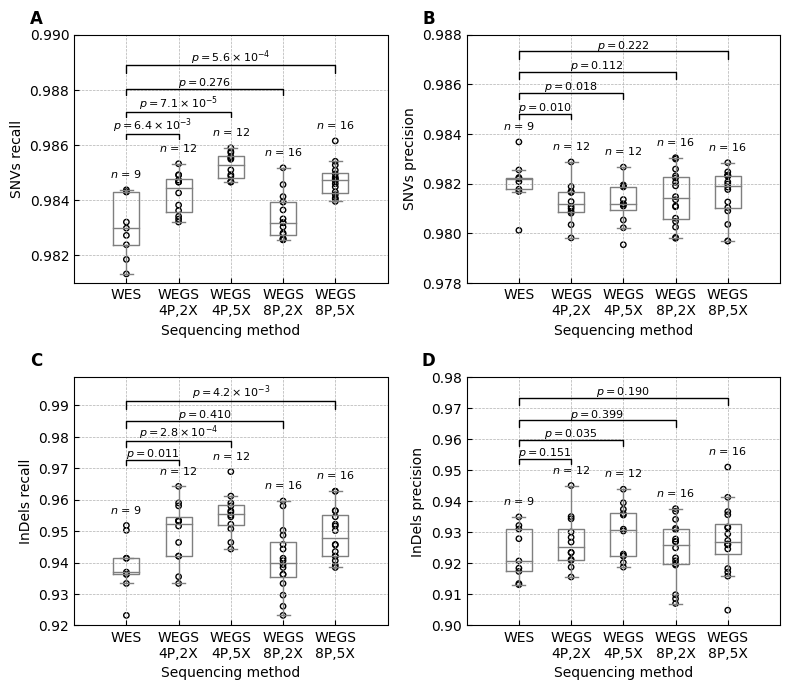

In [22]:
table_data = {
    'Label': [],
    'Number of samples sequenced together (multiplexed)': [],
    'WGS DP': [],
    'SNV Recall (SE)': [],
    'SNV Precision (SE)': [],
    'InDel Recall (SE)': [],
    'InDel Precision (SE)': [],
}

plt.style.use('default')
fig = plt.figure(figsize=(8, 7), dpi = 100)

df_snvs = df_variants[(df_variants.Type == 'SNP') & (df_variants.Filter == 'ALL')]
df_wegs_snvs = df_wegs_variants[(df_wegs_variants.Type == 'SNP') & (df_wegs_variants.Filter == 'ALL')]
df_all_snvs = pd.concat([df_snvs, df_wegs_snvs])

df_indels = df_variants[(df_variants.Type == 'INDEL') & (df_variants.Filter == 'ALL')]
df_wegs_indels = df_wegs_variants[(df_wegs_variants.Type == 'INDEL') & (df_wegs_variants.Filter == 'ALL')]
df_all_indels = pd.concat([df_indels, df_wegs_indels])

groups = [ (1, 1, 0, "WES"), (2, 4, 2, 'WEGS\n4P,2X'), (3, 4, 5, "WEGS\n4P,5X"), (4, 8, 2, "WEGS\n8P,2X"), (5, 8, 5, "WEGS\n8P,5X")]

# FIGURE A
# =============== #
ax = fig.add_subplot(2, 2, 1)
# scatterplots
for x, plexing, wgs_dp, label in groups:
    df_temp = df_all_snvs[(df_all_snvs.Plexing == plexing) & (df_all_snvs.WGS_depth == wgs_dp)]
    ax.scatter([x] * len(df_temp), df_temp['Recall'], facecolors='none', edgecolors='black', s = 15)
# boxplots
bp_data = []
bp_positions = []
for x, plexing, wgs_dp, label in groups:
    bp_positions.append(x)
    bp_data.append(df_all_snvs[(df_all_snvs.Plexing == plexing) & (df_all_snvs.WGS_depth == wgs_dp)]['Recall'])
    table_data['Label'].append(label)
    table_data['Number of samples sequenced together (multiplexed)'].append(plexing)
    table_data['WGS DP'].append(wgs_dp)
    table_data['SNV Recall (SE)'].append(f'{np.mean(bp_data[-1]):.4f} ({stats.sem(bp_data[-1]):.4f})')
ax.boxplot(bp_data, positions = bp_positions, widths = 0.5,
                showfliers = False, showmeans = False, 
                medianprops = {'color': 'tab:grey'},
                boxprops = {'color': 'tab:grey'},
                whiskerprops={'color': 'tab:grey'}, 
                capprops={'color': 'tab:grey'})
# Limits. Must be set before text annotations.
ax.set_xlim([0,  6])
ax.set_ylim([0.981,  0.990])
# Grid & ticks
ax.tick_params(axis = 'both', direction = 'in')
ax.grid(linestyle = '--', linewidth = 0.5)
ax.set_xticks([x for x, _, _, _ in groups])
ax.set_xticklabels([x for _, _, _, x in groups])
# Text annotations
for x, data in zip(bp_positions, bp_data):
    annotate_sample_size(ax, x, data, 10)
# P-values
ys = [0.9861, 0.9869, 0.9877, 0.9885]
fs = [0.15, 0.08, 0.06, 0.05]
for i in range(1, len(groups)):
    pvalue = stats.mannwhitneyu(bp_data[0], bp_data[i], alternative = "less")[1]
    table_data['SNV Recall (SE)'][i] += f'{sign_symbol(pvalue)}'
    annotate_pvalue(ax, groups[0][0], groups[i][0], ys[i - 1], pvalue, fs[i - 1])
ax.set_ylabel('SNVs recall')
ax.set_xlabel('Sequencing method')
ax.text(-0.1, 1.1, 'A', transform = ax.transAxes, fontsize = 12, fontweight = 'bold', va = 'top', ha = 'right')


# FIGURE B
# =============== #
ax = fig.add_subplot(2, 2, 2)
# scatterplots
for x, plexing, wgs_dp, label in groups:
    df_temp = df_all_snvs[(df_all_snvs.Plexing == plexing) & (df_all_snvs.WGS_depth == wgs_dp)]
    ax.scatter([x] * len(df_temp), df_temp['Precision'], facecolors='none', edgecolors='black', s = 15)
# boxplots
bp_data = []
bp_positions = []
for x, plexing, wgs_dp, label in groups:
    bp_positions.append(x)
    bp_data.append(df_all_snvs[(df_all_snvs.Plexing == plexing) & (df_all_snvs.WGS_depth == wgs_dp)]['Precision'])
    table_data['SNV Precision (SE)'].append(f'{np.mean(bp_data[-1]):.4f} ({stats.sem(bp_data[-1]):.4f})')
ax.boxplot(bp_data, positions = bp_positions, widths = 0.5,
                showfliers = False, showmeans = False, 
                medianprops = {'color': 'tab:grey'},
                boxprops = {'color': 'tab:grey'},
                whiskerprops={'color': 'tab:grey'}, 
                capprops={'color': 'tab:grey'})
# Limits. Must be set before text annotations.
ax.set_xlim([0,  6])
ax.set_ylim([0.978,  0.988])
# Grid & ticks
ax.tick_params(axis = 'both', direction = 'in')
ax.grid(linestyle = '--', linewidth = 0.5)
ax.set_xticks([x for x, _, _, _ in groups])
ax.set_xticklabels([x for _, _, _, x in groups])
# Text annotations
for x, data in zip(bp_positions, bp_data):
    annotate_sample_size(ax, x, data, 10)
# P-values
ys = [0.9845, 0.9853, 0.9861, 0.9869]
fs = [0.15, 0.08, 0.06, 0.05]
for i in range(1, len(groups)):
    pvalue = stats.mannwhitneyu(bp_data[0], bp_data[i], alternative = "greater")[1]
    table_data['SNV Precision (SE)'][i] += f'{sign_symbol(pvalue)}'
    annotate_pvalue(ax, groups[0][0], groups[i][0], ys[i - 1], pvalue, fs[i - 1])
ax.set_ylabel('SNVs precision')
ax.set_xlabel('Sequencing method')
ax.text(-0.1, 1.1, 'B', transform = ax.transAxes, fontsize = 12, fontweight = 'bold', va = 'top', ha = 'right')


# FIGURE C
# =============== #
ax = fig.add_subplot(2, 2, 3)
# scatterplots
for x, plexing, wgs_dp, label in groups:
    df_temp = df_all_indels[(df_all_indels.Plexing == plexing) & (df_all_indels.WGS_depth == wgs_dp)]
    ax.scatter([x] * len(df_temp), df_temp['Recall'], facecolors='none', edgecolors='black', s = 15)
# boxplots
bp_data = []
bp_positions = []
for x, plexing, wgs_dp, label in groups:
    bp_positions.append(x)
    bp_data.append(df_all_indels[(df_all_indels.Plexing == plexing) & (df_all_indels.WGS_depth == wgs_dp)]['Recall'])
    table_data['InDel Recall (SE)'].append(f'{np.mean(bp_data[-1]):.4f} ({stats.sem(bp_data[-1]):.4f})')
ax.boxplot(bp_data, positions = bp_positions, widths = 0.5,
                showfliers = False, showmeans = False, 
                medianprops = {'color': 'tab:grey'},
                boxprops = {'color': 'tab:grey'},
                whiskerprops={'color': 'tab:grey'}, 
                capprops={'color': 'tab:grey'})
# Limits. Must be set before text annotations.
ax.set_xlim([0,  6])
ax.set_ylim([0.92,  0.999])
# Grid & ticks
ax.tick_params(axis = 'both', direction = 'in')
ax.grid(linestyle = '--', linewidth = 0.5)
ax.set_xticks([x for x, _, _, _ in groups])
ax.set_xticklabels([x for _, _, _, x in groups])
# Text annotations
for x, data in zip(bp_positions, bp_data):
    annotate_sample_size(ax, x, data, 10)
# P-values
ys = [0.9700, 0.9760, 0.9820, 0.9880]
fs = [0.15, 0.08, 0.06, 0.05]
for i in range(1, len(groups)):
    pvalue = stats.mannwhitneyu(bp_data[0], bp_data[i], alternative = "less")[1]
    table_data['InDel Recall (SE)'][i] += f'{sign_symbol(pvalue)}'
    annotate_pvalue(ax, groups[0][0], groups[i][0], ys[i - 1], pvalue, fs[i - 1])
ax.set_ylabel('InDels recall')
ax.set_xlabel('Sequencing method')
ax.text(-0.1, 1.1, 'C', transform = ax.transAxes, fontsize = 12, fontweight = 'bold', va = 'top', ha = 'right')


# FIGURE D
# =============== #
ax = fig.add_subplot(2, 2, 4)
# scatterplots
for x, plexing, wgs_dp, label in groups:
    df_temp = df_all_indels[(df_all_indels.Plexing == plexing) & (df_all_indels.WGS_depth == wgs_dp)]
    ax.scatter([x] * len(df_temp), df_temp['Precision'], facecolors='none', edgecolors='black', s = 15)
# boxplots
bp_data = []
bp_positions = []
for x, plexing, wgs_dp, label in groups:
    bp_positions.append(x)
    bp_data.append(df_all_indels[(df_all_indels.Plexing == plexing) & (df_all_indels.WGS_depth == wgs_dp)]['Precision'])
    table_data['InDel Precision (SE)'].append(f'{np.mean(bp_data[-1]):.4f} ({stats.sem(bp_data[-1]):.4f})')
ax.boxplot(bp_data, positions = bp_positions, widths = 0.5,
                showfliers = False, showmeans = False, 
                medianprops = {'color': 'tab:grey'},
                boxprops = {'color': 'tab:grey'},
                whiskerprops={'color': 'tab:grey'}, 
                capprops={'color': 'tab:grey'})
# Limits. Must be set before text annotations.
ax.set_xlim([0,  6])
ax.set_ylim([0.90,  0.98])
# Grid & ticks
ax.tick_params(axis = 'both', direction = 'in')
ax.grid(linestyle = '--', linewidth = 0.5)
ax.set_xticks([x for x, _, _, _ in groups])
ax.set_xticklabels([x for _, _, _, x in groups])
# Text annotations
for x, data in zip(bp_positions, bp_data):
    annotate_sample_size(ax, x, data, 10)
# P-values
ys = [0.951, 0.957, 0.963, 0.970]
fs = [0.15, 0.08, 0.06, 0.05]
for i in range(1, len(groups)):
    pvalue = stats.mannwhitneyu(bp_data[0], bp_data[i], alternative = "less")[1]
    table_data['InDel Precision (SE)'][i] += f'{sign_symbol(pvalue)}'
    annotate_pvalue(ax, groups[0][0], groups[i][0], ys[i - 1], pvalue, fs[i - 1])
ax.set_ylabel('InDels precision')
ax.set_xlabel('Sequencing method')
ax.text(-0.1, 1.1, 'D', transform = ax.transAxes, fontsize = 12, fontweight = 'bold', va = 'top', ha = 'right')

plt.tight_layout()
plt.show()


### TABLE: Average variant recall and precision rates in no-plexing WES and WEGS.

In [23]:
pd.DataFrame(table_data)

,Label,Number of samples sequenced together (multiplexed),WGS DP,SNV Recall (SE),SNV Precision (SE),InDel Recall (SE),InDel Precision (SE)
0,WES,1,0,0.9830 (0.0004),0.9821 (0.0003),0.9390 (0.0029),0.9232 (0.0028)
1,"WEGS\n4P,2X",4,2,0.9842 (0.0002)**,0.9812 (0.0002)*,0.9493 (0.0028)*,0.9269 (0.0024)
2,"WEGS\n4P,5X",4,5,0.9852 (0.0001)***,0.9812 (0.0002)*,0.9552 (0.0019)***,0.9300 (0.0024)*
3,"WEGS\n8P,2X",8,2,0.9834 (0.0002),0.9814 (0.0003),0.9407 (0.0026),0.9240 (0.0024)
4,"WEGS\n8P,5X",8,5,0.9847 (0.0001)***,0.9816 (0.0002),0.9490 (0.0020)**,0.9277 (0.0027)


### FIGURE: SNVs calling precision and recall rates in no-plexing WES compared to WEGS stratified by library preparation batch.

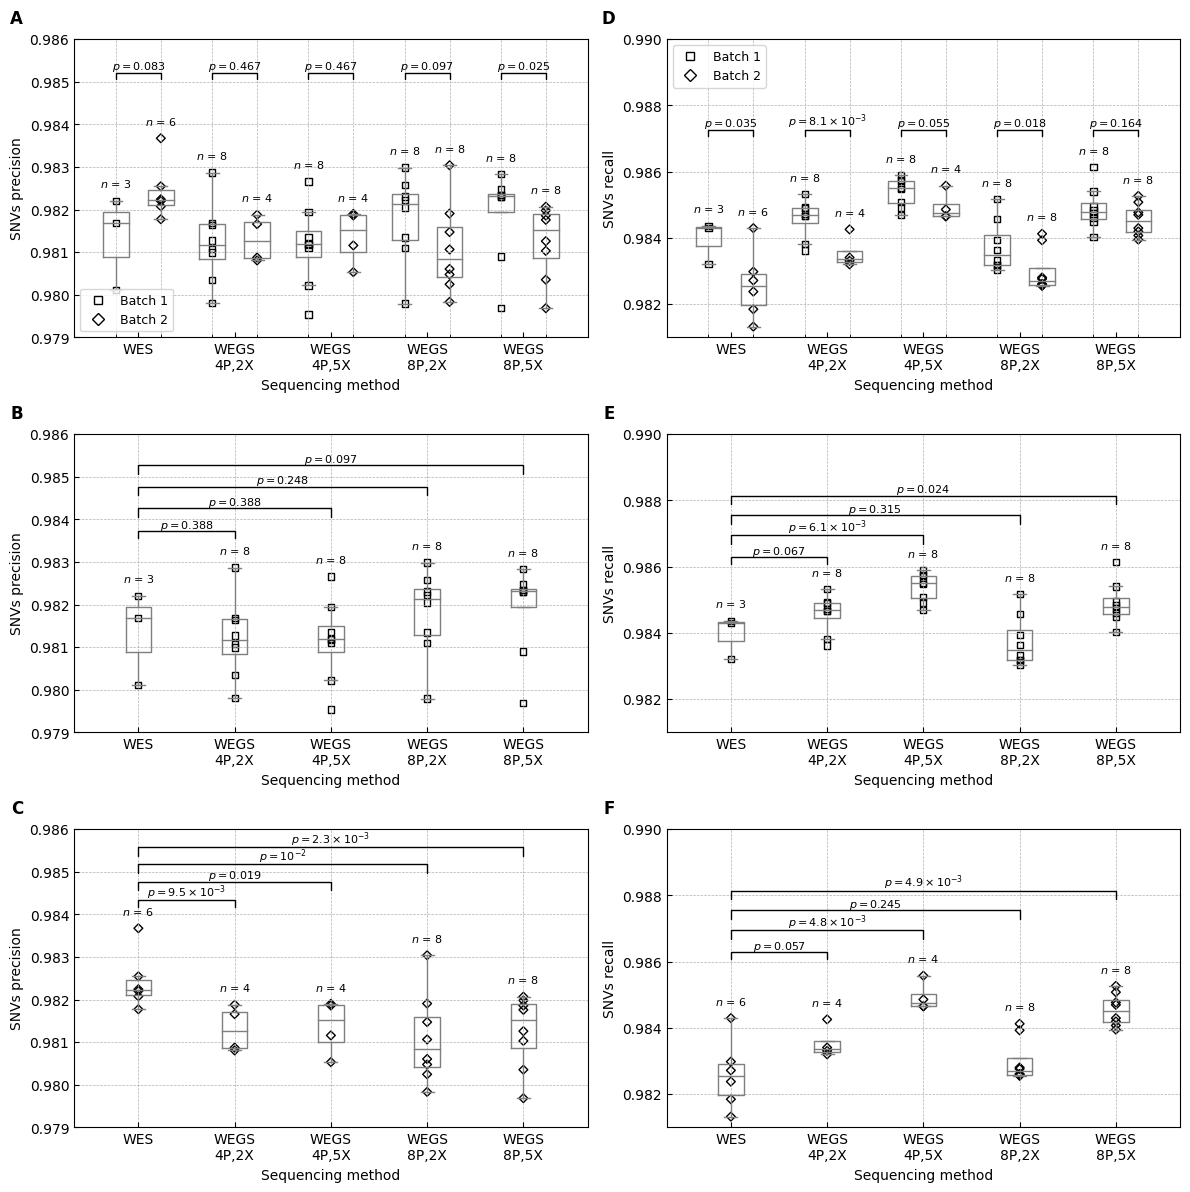

In [24]:
table_data = {
    'Batch': [],
    'Label': [],
    'Number of samples sequenced together (multiplexed)': [],
    'WGS DP': [],
    'SNV Recall (SE)': [],
    'SNV Precision (SE)': [],
}

plt.style.use('default')
fig = plt.figure(figsize=(12, 12), dpi = 100)

batches = [1, 2]

df_wes_snvs = df_variants[(df_variants.Type == 'SNP') & (df_variants.Filter == 'ALL')]
df_wegs_snvs = df_wegs_variants[(df_wegs_variants.Type == 'SNP') & (df_wegs_variants.Filter == 'ALL')]
df_all_snvs = pd.concat([df_wes_snvs, df_wegs_snvs])

groups = [ (1, 1, 0, "WES"), (2.5, 4, 2, 'WEGS\n4P,2X'), (4, 4, 5, "WEGS\n4P,5X"), (5.5, 8, 2, "WEGS\n8P,2X"), (7, 8, 5, "WEGS\n8P,5X")]

batch_markers = { 1: 's', 2: 'D' }
batch_offsets = { 1: -0.35, 2: 0.35 }


# FIGURE A
# ================ #
ax = fig.add_subplot(3, 2, 1)
bp_positions = {1: [], 2: []}
bp_data = {1: [], 2: []}
# scatter plot
for batch in batches:
    for x, plexing, wgs_dp, label in groups:
        df_all_snvs_temp = df_all_snvs[(df_all_snvs.Plexing == plexing) & (df_all_snvs.WGS_depth == wgs_dp) & (df_all_snvs.Batch == batch)]
        ax.scatter([x + batch_offsets[batch]] * len(df_all_snvs_temp), df_all_snvs_temp.Precision, 
                marker = batch_markers[batch], edgecolor = 'black', facecolor = 'none', s = 20)
# boxplots
for batch in batches:
    for x, plexing, wgs_dp, label in groups:
        df_all_snvs_temp = df_all_snvs[(df_all_snvs.Plexing == plexing) & (df_all_snvs.WGS_depth == wgs_dp) & (df_all_snvs.Batch == batch)]
        bp_positions[batch].append(x + batch_offsets[batch])
        bp_data[batch].append(df_all_snvs_temp.Precision)
        
        table_data['Label'].append(label)
        table_data['Number of samples sequenced together (multiplexed)'].append(plexing)
        table_data['Batch'].append(batch)
        table_data['WGS DP'].append(wgs_dp)
        table_data['SNV Precision (SE)'].append(f'{np.mean(bp_data[batch][-1]):.4f} ({stats.sem(bp_data[batch][-1]):.4f})')
        
    bx = ax.boxplot(bp_data[batch], positions = bp_positions[batch], widths = 0.4,
                showfliers = False, showmeans = False, 
                medianprops = {'color': 'tab:grey'},
                boxprops = {'color': 'tab:grey'},
                whiskerprops={'color': 'tab:grey'}, 
                capprops={'color': 'tab:grey'})    
# Limits. Must be set before text annotations.
ax.set_xlim([0,  8])
ax.set_ylim([0.979,  0.986])
# Grid & ticks
ax.tick_params(axis = 'both', direction = 'in', which = 'both')
ax.set_xticks([x + batch_offsets[1] for x, _, _, _ in groups] + [x + batch_offsets[2] for x, _, _, _ in groups], minor = True)
ax.xaxis.grid(True, which = 'minor', linestyle = '--', linewidth = 0.5)
ax.yaxis.grid(True, which = 'major', linestyle = '--', linewidth = 0.5)
ax.set_xticks([x for x, _, _, _ in groups])
ax.set_xticklabels([x for _, _, _, x in groups])
# Text annotations
for batch in batches:
    for x, data in zip(bp_positions[batch], bp_data[batch]):
        annotate_sample_size(ax, x, data, 10)
legend_elements = [
    Line2D([0], [0], marker = batch_markers[1], markeredgecolor = 'black', markerfacecolor = 'none', color = 'none', label='Batch 1'), 
    Line2D([0], [0], marker = batch_markers[2], markeredgecolor = 'black', markerfacecolor = 'none', color = 'none', label='Batch 2')
]
ax.legend(handles = legend_elements, loc = 3, prop = {'size': 9})
for i, group in enumerate(groups, 0):
    if np.mean(bp_data[1][i]) > np.mean(bp_data[2][i]):
        pvalue = stats.mannwhitneyu(bp_data[1][i], bp_data[2][i], alternative = "greater")[1]
    else:
        pvalue = stats.mannwhitneyu(bp_data[2][i], bp_data[1][i], alternative = "greater")[1]
    annotate_pvalue(ax, group[0] - 0.35, group[0] + 0.35, 0.985, pvalue, 0.20)
ax.set_ylabel('SNVs precision')
ax.set_xlabel('Sequencing method')
ax.text(-0.1, 1.1, 'A', transform = ax.transAxes, fontsize = 12, fontweight = 'bold', va = 'top', ha = 'right')


# FIGURE B
# ================ #
ax = fig.add_subplot(3, 2, 3)
for i, group in enumerate(groups, 0):
    ax.scatter([group[0]] * len(bp_data[1][i]), bp_data[1][i], 
                marker = batch_markers[1], edgecolor = 'black', facecolor = 'none', s = 20)
    ax.boxplot(bp_data[1][i], positions = [group[0]], widths = 0.4,
                showfliers = False, showmeans = False, 
                medianprops = {'color': 'tab:grey'},
                boxprops = {'color': 'tab:grey'},
                whiskerprops={'color': 'tab:grey'}, 
                capprops={'color': 'tab:grey'})
# Limits. Must be set before text annotations.
ax.set_xlim([0,  8])
ax.set_ylim([0.979,  0.986])
# Grid & ticks
ax.tick_params(axis = 'both', direction = 'in')
ax.grid(linestyle = '--', linewidth = 0.5)
ax.set_xticks([x for x, _, _, _ in groups])
ax.set_xticklabels([x for _, _, _, x in groups])
# Text annotations
for i, group in enumerate(groups, 0):
    annotate_sample_size(ax, group[0], bp_data[1][i], 10)
# P-values
ys = [0.9835, 0.9840, 0.9845, 0.9850]
fs = [0.10, 0.06, 0.04, 0.03]
for i in range(1, len(groups)):
    if np.mean(bp_data[1][0]) > np.mean(bp_data[1][i]):
        pvalue = stats.mannwhitneyu(bp_data[1][0], bp_data[1][i], alternative = "greater")[1]
    else:
        pvalue = stats.mannwhitneyu(bp_data[1][i], bp_data[1][0], alternative = "greater")[1]
    table_data['SNV Precision (SE)'][i] += f'{sign_symbol(pvalue)}'
    annotate_pvalue(ax, groups[0][0], groups[i][0], ys[i - 1], pvalue, fs[i - 1])
ax.set_ylabel('SNVs precision')
ax.set_xlabel('Sequencing method')
ax.text(-0.1, 1.1, 'B', transform = ax.transAxes, fontsize = 12, fontweight = 'bold', va = 'top', ha = 'right')


# FIGURE C
# ================ #
ax = fig.add_subplot(3, 2, 5)
for i, group in enumerate(groups, 0):
    ax.scatter([group[0]] * len(bp_data[2][i]), bp_data[2][i], 
                marker = batch_markers[2], edgecolor = 'black', facecolor = 'none', s = 20)
    ax.boxplot(bp_data[2][i], positions = [group[0]], widths = 0.4,
                showfliers = False, showmeans = False, 
                medianprops = {'color': 'tab:grey'},
                boxprops = {'color': 'tab:grey'},
                whiskerprops={'color': 'tab:grey'}, 
                capprops={'color': 'tab:grey'})
# Limits. Must be set before text annotations.
ax.set_xlim([0,  8])
ax.set_ylim([0.979,  0.986])
# Grid & ticks
ax.tick_params(axis = 'both', direction = 'in')
ax.grid(linestyle = '--', linewidth = 0.5)
ax.set_xticks([x for x, _, _, _ in groups])
ax.set_xticklabels([x for _, _, _, x in groups])
# Text annotations
for i, group in enumerate(groups, 0):
    annotate_sample_size(ax, group[0], bp_data[2][i], 10)
# P-values
ys = [0.9841, 0.9845, 0.9849, 0.9853]
fs = [0.10, 0.06, 0.04, 0.03]
for i in range(1, len(groups)):
    if np.mean(bp_data[2][0]) > np.mean(bp_data[2][i]):
        pvalue = stats.mannwhitneyu(bp_data[2][0], bp_data[2][i], alternative = "greater")[1]
    else:
        pvalue = stats.mannwhitneyu(bp_data[2][i], bp_data[2][0], alternative = "greater")[1]
    table_data['SNV Precision (SE)'][len(bp_data[1]) + i] += f'{sign_symbol(pvalue)}'
    annotate_pvalue(ax, groups[0][0], groups[i][0], ys[i - 1], pvalue, fs[i - 1])
ax.set_ylabel('SNVs precision')
ax.set_xlabel('Sequencing method')
ax.text(-0.1, 1.1, 'C', transform = ax.transAxes, fontsize = 12, fontweight = 'bold', va = 'top', ha = 'right')


# FIGURE D
# ================ #
ax = fig.add_subplot(3, 2, 2)
bp_positions = {1: [], 2: []}
bp_data = {1: [], 2: []}
# scatter plot
for batch in batches:
    for x, plexing, wgs_dp, label in groups:
        df_all_snvs_temp = df_all_snvs[(df_all_snvs.Plexing == plexing) & (df_all_snvs.WGS_depth == wgs_dp) & (df_all_snvs.Batch == batch)]
        ax.scatter([x + batch_offsets[batch]] * len(df_all_snvs_temp), df_all_snvs_temp.Recall, 
                marker = batch_markers[batch], edgecolor = 'black', facecolor = 'none', s = 20)
# boxplots
for batch in batches:
    for x, plexing, wgs_dp, label in groups:
        df_all_snvs_temp = df_all_snvs[(df_all_snvs.Plexing == plexing) & (df_all_snvs.WGS_depth == wgs_dp) & (df_all_snvs.Batch == batch)]
        bp_positions[batch].append(x + batch_offsets[batch])
        bp_data[batch].append(df_all_snvs_temp.Recall)
        table_data['SNV Recall (SE)'].append(f'{np.mean(bp_data[batch][-1]):.4f} ({stats.sem(bp_data[batch][-1]):.4f})')
    bx = ax.boxplot(bp_data[batch], positions = bp_positions[batch], widths = 0.4,
                showfliers = False, showmeans = False, 
                medianprops = {'color': 'tab:grey'},
                boxprops = {'color': 'tab:grey'},
                whiskerprops={'color': 'tab:grey'}, 
                capprops={'color': 'tab:grey'})    
# Limits. Must be set before text annotations.
ax.set_xlim([0,  8])
ax.set_ylim([0.981,  0.990])
# Grid & ticks
ax.tick_params(axis = 'both', direction = 'in', which = 'both')
ax.set_xticks([x + batch_offsets[1] for x, _, _, _ in groups] + [x + batch_offsets[2] for x, _, _, _ in groups], minor = True)
ax.xaxis.grid(True, which = 'minor', linestyle = '--', linewidth = 0.5)
ax.yaxis.grid(True, which = 'major', linestyle = '--', linewidth = 0.5)
ax.set_xticks([x for x, _, _, _ in groups])
ax.set_xticklabels([x for _, _, _, x in groups])
# Text annotations
for batch in batches:
    for x, data in zip(bp_positions[batch], bp_data[batch]):
        annotate_sample_size(ax, x, data, 10)
legend_elements = [
    Line2D([0], [0], marker = batch_markers[1], markeredgecolor = 'black', markerfacecolor = 'none', color = 'none', label='Batch 1'), 
    Line2D([0], [0], marker = batch_markers[2], markeredgecolor = 'black', markerfacecolor = 'none', color = 'none', label='Batch 2')
]
ax.legend(handles = legend_elements, loc = 2, prop = {'size': 9})
for i, group in enumerate(groups, 0):
    if np.mean(bp_data[1][i]) > np.mean(bp_data[2][i]):
        pvalue = stats.mannwhitneyu(bp_data[1][i], bp_data[2][i], alternative = "greater")[1]
    else:
        pvalue = stats.mannwhitneyu(bp_data[2][i], bp_data[1][i], alternative = "greater")[1]
    annotate_pvalue(ax, group[0] - 0.35, group[0] + 0.35, 0.987, pvalue, 0.20)
ax.set_ylabel('SNVs recall')
ax.set_xlabel('Sequencing method')
ax.text(-0.1, 1.1, 'D', transform = ax.transAxes, fontsize = 12, fontweight = 'bold', va = 'top', ha = 'right')


# FIGURE E
# ================ #
ax = fig.add_subplot(3, 2, 4)
for i, group in enumerate(groups, 0):
    ax.scatter([group[0]] * len(bp_data[1][i]), bp_data[1][i], 
                marker = batch_markers[1], edgecolor = 'black', facecolor = 'none', s = 20)
    ax.boxplot(bp_data[1][i], positions = [group[0]], widths = 0.4,
                showfliers = False, showmeans = False, 
                medianprops = {'color': 'tab:grey'},
                boxprops = {'color': 'tab:grey'},
                whiskerprops={'color': 'tab:grey'}, 
                capprops={'color': 'tab:grey'})
# Limits. Must be set before text annotations.
ax.set_xlim([0,  8])
ax.set_ylim([0.981,  0.990])
# Grid & ticks
ax.tick_params(axis = 'both', direction = 'in')
ax.grid(linestyle = '--', linewidth = 0.5)
ax.set_xticks([x for x, _, _, _ in groups])
ax.set_xticklabels([x for _, _, _, x in groups])
# Text annotations
for i, group in enumerate(groups, 0):
    annotate_sample_size(ax, group[0], bp_data[1][i], 10)
# P-values
ys = [0.9860, 0.9866, 0.9872, 0.9878]
fs = [0.10, 0.06, 0.04, 0.03]
for i in range(1, len(groups)):
    if np.mean(bp_data[1][0]) > np.mean(bp_data[1][i]):
        pvalue = stats.mannwhitneyu(bp_data[1][0], bp_data[1][i], alternative = "greater")[1]
    else:
        pvalue = stats.mannwhitneyu(bp_data[1][i], bp_data[1][0], alternative = "greater")[1]
    table_data['SNV Recall (SE)'][i] += f'{sign_symbol(pvalue)}'
    annotate_pvalue(ax, groups[0][0], groups[i][0], ys[i - 1], pvalue, fs[i - 1])
ax.set_ylabel('SNVs recall')
ax.set_xlabel('Sequencing method')
ax.text(-0.1, 1.1, 'E', transform = ax.transAxes, fontsize = 12, fontweight = 'bold', va = 'top', ha = 'right')


# FIGURE F
# ================ #
ax = fig.add_subplot(3, 2, 6)
for i, group in enumerate(groups, 0):
    ax.scatter([group[0]] * len(bp_data[2][i]), bp_data[2][i], 
                marker = batch_markers[2], edgecolor = 'black', facecolor = 'none', s = 20)
    ax.boxplot(bp_data[2][i], positions = [group[0]], widths = 0.4,
                showfliers = False, showmeans = False, 
                medianprops = {'color': 'tab:grey'},
                boxprops = {'color': 'tab:grey'},
                whiskerprops={'color': 'tab:grey'}, 
                capprops={'color': 'tab:grey'})
# Limits. Must be set before text annotations.
ax.set_xlim([0,  8])
ax.set_ylim([0.981,  0.990])
# Grid & ticks
ax.tick_params(axis = 'both', direction = 'in')
ax.grid(linestyle = '--', linewidth = 0.5)
ax.set_xticks([x for x, _, _, _ in groups])
ax.set_xticklabels([x for _, _, _, x in groups])
# Text annotations
for i, group in enumerate(groups, 0):
    annotate_sample_size(ax, group[0], bp_data[2][i], 10)
# P-values
ys = [0.986, 0.9866, 0.9872, 0.9878]
fs = [0.10, 0.06, 0.04, 0.03]
vas = ['bottom', 'bottom', 'bottom', 'bottom']
for i in range(1, len(groups)):
    if np.mean(bp_data[2][0]) > np.mean(bp_data[2][i]):
        pvalue = stats.mannwhitneyu(bp_data[2][0], bp_data[2][i], alternative = "greater")[1]
    else:
        pvalue = stats.mannwhitneyu(bp_data[2][i], bp_data[2][0], alternative = "greater")[1]
    table_data['SNV Recall (SE)'][len(bp_data[1]) + i] += f'{sign_symbol(pvalue)}'
    annotate_pvalue(ax, groups[0][0], groups[i][0], ys[i - 1], pvalue, fs[i - 1], va = vas[i - 1])
ax.set_ylabel('SNVs recall')
ax.set_xlabel('Sequencing method')
ax.text(-0.1, 1.1, 'F', transform = ax.transAxes, fontsize = 12, fontweight = 'bold', va = 'top', ha = 'right')



plt.tight_layout()
plt.show()

### TABLE: Average variant recall and precision rates in no-plexing WES and WEGS stratified by library preparation batch (PART 1).

In [25]:
pd.DataFrame(table_data)

,Batch,Label,Number of samples sequenced together (multiplexed),WGS DP,SNV Recall (SE),SNV Precision (SE)
0,1,WES,1,0,0.9840 (0.0004),0.9813 (0.0006)
1,1,"WEGS\n4P,2X",4,2,0.9846 (0.0002),0.9812 (0.0003)
2,1,"WEGS\n4P,5X",4,5,0.9854 (0.0002)**,0.9811 (0.0003)
3,1,"WEGS\n8P,2X",8,2,0.9838 (0.0003),0.9818 (0.0004)
4,1,"WEGS\n8P,5X",8,5,0.9849 (0.0002)*,0.9819 (0.0004)
5,2,WES,1,0,0.9826 (0.0004),0.9824 (0.0003)
6,2,"WEGS\n4P,2X",4,2,0.9835 (0.0002),0.9813 (0.0003)**
7,2,"WEGS\n4P,5X",4,5,0.9849 (0.0002)**,0.9814 (0.0003)*
8,2,"WEGS\n8P,2X",8,2,0.9830 (0.0002),0.9811 (0.0004)**
9,2,"WEGS\n8P,5X",8,5,0.9845 (0.0002)**,0.9812 (0.0003)**


### FIGURE: InDel calling precision and recall rates in no-plexing WES compared to WEGS stratified by library preparation batch.

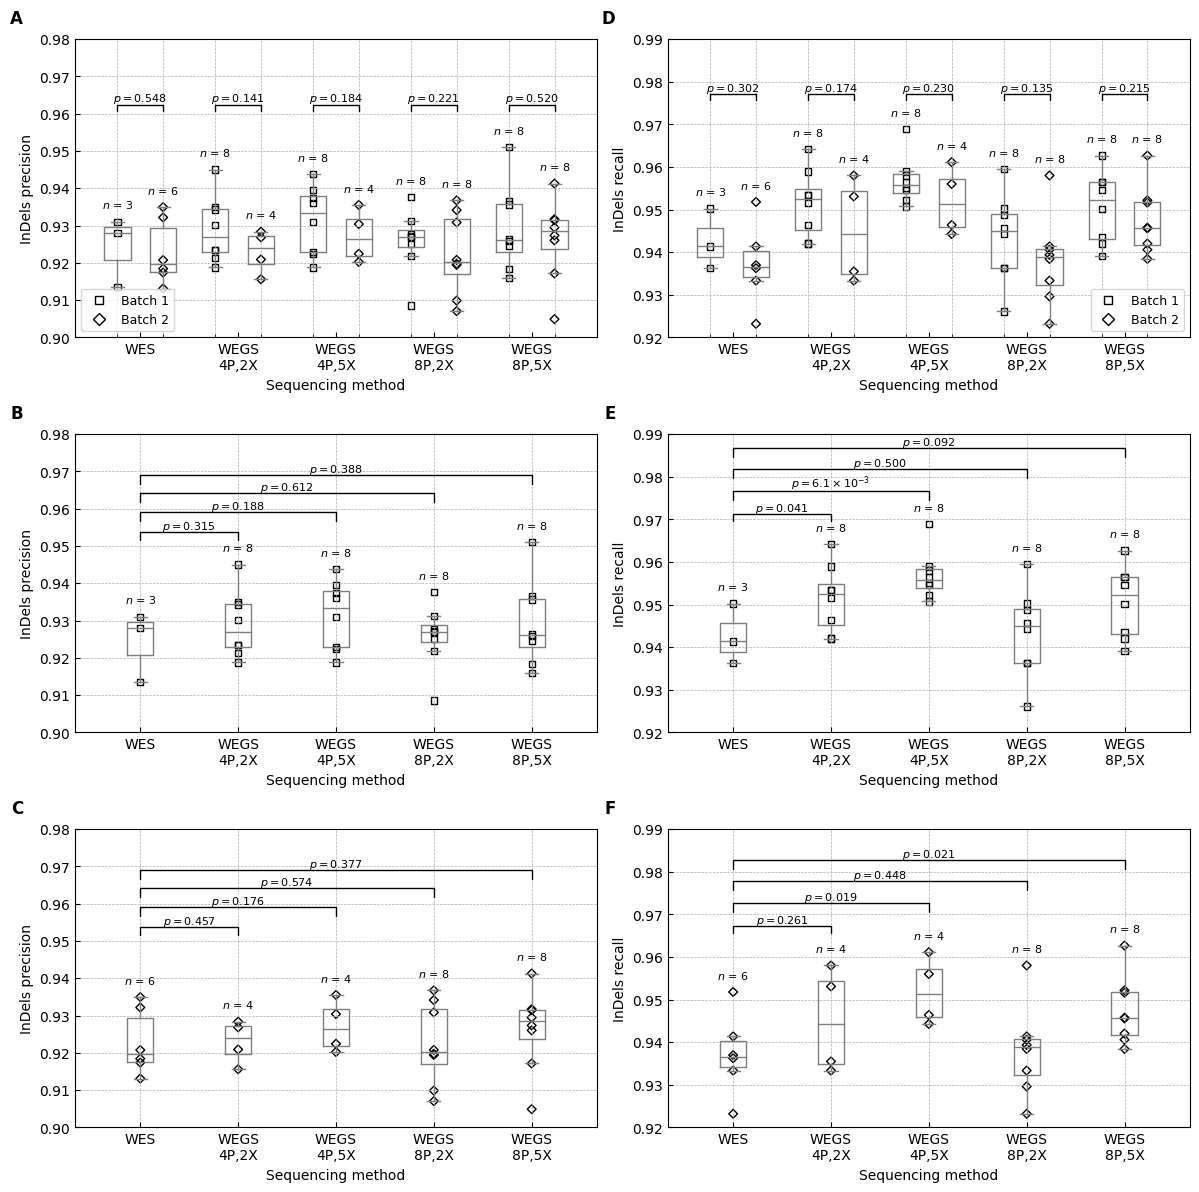

In [26]:
table_data = {
    'Batch': [],
    'Label': [],
    'Number of samples sequenced together (multiplexed)': [],
    'WGS DP': [],
    'InDel Recall (SE)': [],
    'InDel Precision (SE)': [],
}

plt.style.use('default')
fig = plt.figure(figsize=(12, 12), dpi = 100)

batches = [1, 2]

df_wes_indels = df_variants[(df_variants.Type == 'INDEL') & (df_variants.Filter == 'ALL')]
df_wegs_indels = df_wegs_variants[(df_wegs_variants.Type == 'INDEL') & (df_wegs_variants.Filter == 'ALL')]
df_all_indels = pd.concat([df_wes_indels, df_wegs_indels])

groups = [ (1, 1, 0, "WES"), (2.5, 4, 2, 'WEGS\n4P,2X'), (4, 4, 5, "WEGS\n4P,5X"), (5.5, 8, 2, "WEGS\n8P,2X"), (7, 8, 5, "WEGS\n8P,5X")]

batch_markers = { 1: 's', 2: 'D' }
batch_offsets = { 1: -0.35, 2: 0.35 }


# FIGURE A
# ============== #
ax = fig.add_subplot(3, 2, 1)
bp_positions = {1: [], 2: []}
bp_data = {1: [], 2: []}
# scatter plot
for batch in batches:
    for x, plexing, wgs_dp, label in groups:
        df_all_indels_temp = df_all_indels[(df_all_indels.Plexing == plexing) & (df_all_indels.WGS_depth == wgs_dp) & (df_all_indels.Batch == batch)]
        ax.scatter([x + batch_offsets[batch]] * len(df_all_indels_temp), df_all_indels_temp.Precision, 
                marker = batch_markers[batch], edgecolor = 'black', facecolor = 'none', s = 20)
# boxplots
for batch in batches:
    for x, plexing, wgs_dp, label in groups:
        df_all_indels_temp = df_all_indels[(df_all_indels.Plexing == plexing) & (df_all_indels.WGS_depth == wgs_dp) & (df_all_indels.Batch == batch)]
        bp_positions[batch].append(x + batch_offsets[batch])
        bp_data[batch].append(df_all_indels_temp.Precision)
        
        table_data['Label'].append(label)
        table_data['Number of samples sequenced together (multiplexed)'].append(plexing)
        table_data['Batch'].append(batch)
        table_data['WGS DP'].append(wgs_dp)
        table_data['InDel Precision (SE)'].append(f'{np.mean(bp_data[batch][-1]):.4f} ({stats.sem(bp_data[batch][-1]):.4f})')
        
    bx = ax.boxplot(bp_data[batch], positions = bp_positions[batch], widths = 0.4,
                showfliers = False, showmeans = False, 
                medianprops = {'color': 'tab:grey'},
                boxprops = {'color': 'tab:grey'},
                whiskerprops={'color': 'tab:grey'}, 
                capprops={'color': 'tab:grey'})    
# Limits. Must be set before text annotations.
ax.set_xlim([0,  8])
ax.set_ylim([0.90,  0.98])
# Grid & ticks
ax.tick_params(axis = 'both', direction = 'in', which = 'both')
ax.set_xticks([x + batch_offsets[1] for x, _, _, _ in groups] + [x + batch_offsets[2] for x, _, _, _ in groups], minor = True)
ax.xaxis.grid(True, which = 'minor', linestyle = '--', linewidth = 0.5)
ax.yaxis.grid(True, which = 'major', linestyle = '--', linewidth = 0.5)
ax.set_xticks([x for x, _, _, _ in groups])
ax.set_xticklabels([x for _, _, _, x in groups])
# Text annotations
for batch in batches:
    for x, data in zip(bp_positions[batch], bp_data[batch]):
        annotate_sample_size(ax, x, data, 10)
legend_elements = [
    Line2D([0], [0], marker = batch_markers[1], markeredgecolor = 'black', markerfacecolor = 'none', color = 'none', label='Batch 1'), 
    Line2D([0], [0], marker = batch_markers[2], markeredgecolor = 'black', markerfacecolor = 'none', color = 'none', label='Batch 2')
]
ax.legend(handles = legend_elements, loc = 3, prop = {'size': 9})
for i, group in enumerate(groups, 0):
    if np.mean(bp_data[1][i]) > np.mean(bp_data[2][i]):
        pvalue = stats.mannwhitneyu(bp_data[1][i], bp_data[2][i], alternative = "greater")[1]
    else:
        pvalue = stats.mannwhitneyu(bp_data[2][i], bp_data[1][i], alternative = "greater")[1]
    annotate_pvalue(ax, group[0] - 0.35, group[0] + 0.35, 0.96, pvalue, 0.20)
ax.set_ylabel('InDels precision')
ax.set_xlabel('Sequencing method')
ax.text(-0.1, 1.1, 'A', transform = ax.transAxes, fontsize = 12, fontweight = 'bold', va = 'top', ha = 'right')


# FIGURE B
# ============== #
ax = fig.add_subplot(3, 2, 3)
for i, group in enumerate(groups, 0):
    ax.scatter([group[0]] * len(bp_data[1][i]), bp_data[1][i], 
                marker = batch_markers[1], edgecolor = 'black', facecolor = 'none', s = 20)
    ax.boxplot(bp_data[1][i], positions = [group[0]], widths = 0.4,
                showfliers = False, showmeans = False, 
                medianprops = {'color': 'tab:grey'},
                boxprops = {'color': 'tab:grey'},
                whiskerprops={'color': 'tab:grey'}, 
                capprops={'color': 'tab:grey'})
# Limits. Must be set before text annotations.
ax.set_xlim([0,  8])
ax.set_ylim([0.90,  0.98])
# Grid & ticks
ax.tick_params(axis = 'both', direction = 'in')
ax.grid(linestyle = '--', linewidth = 0.5)
ax.set_xticks([x for x, _, _, _ in groups])
ax.set_xticklabels([x for _, _, _, x in groups])
# Text annotations
for i, group in enumerate(groups, 0):
    annotate_sample_size(ax, group[0], bp_data[1][i], 10)
# P-values
ys = [0.951, 0.956, 0.961, 0.966]
fs = [0.10, 0.06, 0.04, 0.03]
for i in range(1, len(groups)):
    if np.mean(bp_data[1][0]) > np.mean(bp_data[1][i]):
        pvalue = stats.mannwhitneyu(bp_data[1][0], bp_data[1][i], alternative = "greater")[1]
    else:
        pvalue = stats.mannwhitneyu(bp_data[1][i], bp_data[1][0], alternative = "greater")[1]
    table_data['InDel Precision (SE)'][i] += f'{sign_symbol(pvalue)}'
    annotate_pvalue(ax, groups[0][0], groups[i][0], ys[i - 1], pvalue, fs[i - 1])
ax.set_ylabel('InDels precision')
ax.set_xlabel('Sequencing method')
ax.text(-0.1, 1.1, 'B', transform = ax.transAxes, fontsize = 12, fontweight = 'bold', va = 'top', ha = 'right')


# FIGURE C
# ============== #
ax = fig.add_subplot(3, 2, 5)
for i, group in enumerate(groups, 0):
    ax.scatter([group[0]] * len(bp_data[2][i]), bp_data[2][i], 
                marker = batch_markers[2], edgecolor = 'black', facecolor = 'none', s = 20)
    ax.boxplot(bp_data[2][i], positions = [group[0]], widths = 0.4,
                showfliers = False, showmeans = False, 
                medianprops = {'color': 'tab:grey'},
                boxprops = {'color': 'tab:grey'},
                whiskerprops={'color': 'tab:grey'}, 
                capprops={'color': 'tab:grey'})
# Limits. Must be set before text annotations.
ax.set_xlim([0,  8])
ax.set_ylim([0.90,  0.98])
# Grid & ticks
ax.tick_params(axis = 'both', direction = 'in')
ax.grid(linestyle = '--', linewidth = 0.5)
ax.set_xticks([x for x, _, _, _ in groups])
ax.set_xticklabels([x for _, _, _, x in groups])
# Text annotations
for i, group in enumerate(groups, 0):
    annotate_sample_size(ax, group[0], bp_data[2][i], 10)
# P-values
ys = [0.951, 0.956, 0.961, 0.966]
fs = [0.10, 0.06, 0.04, 0.03]
for i in range(1, len(groups)):
    if np.mean(bp_data[2][0]) > np.mean(bp_data[2][i]):
        pvalue = stats.mannwhitneyu(bp_data[2][0], bp_data[2][i], alternative = "greater")[1]
    else:
        pvalue = stats.mannwhitneyu(bp_data[2][i], bp_data[2][0], alternative = "greater")[1]
    table_data['InDel Precision (SE)'][len(bp_data[1]) + i] += f'{sign_symbol(pvalue)}'
    annotate_pvalue(ax, groups[0][0], groups[i][0], ys[i - 1], pvalue, fs[i - 1])
ax.set_ylabel('InDels precision')
ax.set_xlabel('Sequencing method')
ax.text(-0.1, 1.1, 'C', transform = ax.transAxes, fontsize = 12, fontweight = 'bold', va = 'top', ha = 'right')


# FIGURE D
# ============== #
ax = fig.add_subplot(3, 2, 2)
bp_positions = {1: [], 2: []}
bp_data = {1: [], 2: []}
# scatter plot
for batch in batches:
    for x, plexing, wgs_dp, label in groups:
        df_all_indels_temp = df_all_indels[(df_all_indels.Plexing == plexing) & (df_all_indels.WGS_depth == wgs_dp) & (df_all_indels.Batch == batch)]
        ax.scatter([x + batch_offsets[batch]] * len(df_all_indels_temp), df_all_indels_temp.Recall, 
                marker = batch_markers[batch], edgecolor = 'black', facecolor = 'none', s = 20)
# boxplots
for batch in batches:
    for x, plexing, wgs_dp, label in groups:
        df_all_indels_temp = df_all_indels[(df_all_indels.Plexing == plexing) & (df_all_indels.WGS_depth == wgs_dp) & (df_all_indels.Batch == batch)]
        bp_positions[batch].append(x + batch_offsets[batch])
        bp_data[batch].append(df_all_indels_temp.Recall)
        table_data['InDel Recall (SE)'].append(f'{np.mean(bp_data[batch][-1]):.4f} ({stats.sem(bp_data[batch][-1]):.4f})')
        
    bx = ax.boxplot(bp_data[batch], positions = bp_positions[batch], widths = 0.4,
                showfliers = False, showmeans = False, 
                medianprops = {'color': 'tab:grey'},
                boxprops = {'color': 'tab:grey'},
                whiskerprops={'color': 'tab:grey'}, 
                capprops={'color': 'tab:grey'})    
# Limits. Must be set before text annotations.
ax.set_xlim([0,  8])
ax.set_ylim([0.92,  0.990])
# Grid & ticks
ax.tick_params(axis = 'both', direction = 'in', which = 'both')
ax.set_xticks([x + batch_offsets[1] for x, _, _, _ in groups] + [x + batch_offsets[2] for x, _, _, _ in groups], minor = True)
ax.xaxis.grid(True, which = 'minor', linestyle = '--', linewidth = 0.5)
ax.yaxis.grid(True, which = 'major', linestyle = '--', linewidth = 0.5)
ax.set_xticks([x for x, _, _, _ in groups])
ax.set_xticklabels([x for _, _, _, x in groups])
# Text annotations
for batch in batches:
    for x, data in zip(bp_positions[batch], bp_data[batch]):
        annotate_sample_size(ax, x, data, 10)
legend_elements = [
    Line2D([0], [0], marker = batch_markers[1], markeredgecolor = 'black', markerfacecolor = 'none', color = 'none', label='Batch 1'), 
    Line2D([0], [0], marker = batch_markers[2], markeredgecolor = 'black', markerfacecolor = 'none', color = 'none', label='Batch 2')
]
ax.legend(handles = legend_elements, loc = 4, prop = {'size': 9})
for i, group in enumerate(groups, 0):
    if np.mean(bp_data[1][i]) > np.mean(bp_data[2][i]):
        pvalue = stats.mannwhitneyu(bp_data[1][i], bp_data[2][i], alternative = "greater")[1]
    else:
        pvalue = stats.mannwhitneyu(bp_data[2][i], bp_data[1][i], alternative = "greater")[1]
    annotate_pvalue(ax, group[0] - 0.35, group[0] + 0.35, 0.975, pvalue, 0.20)
ax.set_ylabel('InDels recall')
ax.set_xlabel('Sequencing method')
ax.text(-0.1, 1.1, 'D', transform = ax.transAxes, fontsize = 12, fontweight = 'bold', va = 'top', ha = 'right')


# FIGURE E
# ============== #
ax = fig.add_subplot(3, 2, 4)
for i, group in enumerate(groups, 0):
    ax.scatter([group[0]] * len(bp_data[1][i]), bp_data[1][i], 
                marker = batch_markers[1], edgecolor = 'black', facecolor = 'none', s = 20)
    ax.boxplot(bp_data[1][i], positions = [group[0]], widths = 0.4,
                showfliers = False, showmeans = False, 
                medianprops = {'color': 'tab:grey'},
                boxprops = {'color': 'tab:grey'},
                whiskerprops={'color': 'tab:grey'}, 
                capprops={'color': 'tab:grey'})
# Limits. Must be set before text annotations.
ax.set_xlim([0,  8])
ax.set_ylim([0.92,  0.990])
# Grid & ticks
ax.tick_params(axis = 'both', direction = 'in')
ax.grid(linestyle = '--', linewidth = 0.5)
ax.set_xticks([x for x, _, _, _ in groups])
ax.set_xticklabels([x for _, _, _, x in groups])
# Text annotations
for i, group in enumerate(groups, 0):
    annotate_sample_size(ax, group[0], bp_data[1][i], 10)
# P-values
ys = [0.969, 0.974, 0.979, 0.984]
fs = [0.10, 0.06, 0.04, 0.03]
for i in range(1, len(groups)):
    if np.mean(bp_data[1][0]) > np.mean(bp_data[1][i]):
        pvalue = stats.mannwhitneyu(bp_data[1][0], bp_data[1][i], alternative = "greater")[1]
    else:
        pvalue = stats.mannwhitneyu(bp_data[1][i], bp_data[1][0], alternative = "greater")[1]
    table_data['InDel Recall (SE)'][i] += f'{sign_symbol(pvalue)}'
    annotate_pvalue(ax, groups[0][0], groups[i][0], ys[i - 1], pvalue, fs[i - 1])
ax.set_ylabel('InDels recall')
ax.set_xlabel('Sequencing method')
ax.text(-0.1, 1.1, 'E', transform = ax.transAxes, fontsize = 12, fontweight = 'bold', va = 'top', ha = 'right')
    
    
# FIGURE F
# ============== #
ax = fig.add_subplot(3, 2, 6)
for i, group in enumerate(groups, 0):
    ax.scatter([group[0]] * len(bp_data[2][i]), bp_data[2][i], 
                marker = batch_markers[2], edgecolor = 'black', facecolor = 'none', s = 20)
    ax.boxplot(bp_data[2][i], positions = [group[0]], widths = 0.4,
                showfliers = False, showmeans = False, 
                medianprops = {'color': 'tab:grey'},
                boxprops = {'color': 'tab:grey'},
                whiskerprops={'color': 'tab:grey'}, 
                capprops={'color': 'tab:grey'})
# Limits. Must be set before text annotations.
ax.set_xlim([0,  8])
ax.set_ylim([0.92,  0.990])
# Grid & ticks
ax.tick_params(axis = 'both', direction = 'in')
ax.grid(linestyle = '--', linewidth = 0.5)
ax.set_xticks([x for x, _, _, _ in groups])
ax.set_xticklabels([x for _, _, _, x in groups])
# Text annotations
for i, group in enumerate(groups, 0):
    annotate_sample_size(ax, group[0], bp_data[2][i], 10)
# P-values
ys = [0.965, 0.97, 0.975, 0.98]
fs = [0.10, 0.06, 0.04, 0.03]
vas = ['bottom', 'bottom', 'bottom', 'bottom']
for i in range(1, len(groups)):
    if np.mean(bp_data[2][0]) > np.mean(bp_data[2][i]):
        pvalue = stats.mannwhitneyu(bp_data[2][0], bp_data[2][i], alternative = "greater")[1]
    else:
        pvalue = stats.mannwhitneyu(bp_data[2][i], bp_data[2][0], alternative = "greater")[1]
    table_data['InDel Recall (SE)'][len(bp_data[1]) + i] += f'{sign_symbol(pvalue)}'
    annotate_pvalue(ax, groups[0][0], groups[i][0], ys[i - 1], pvalue, fs[i - 1], va = vas[i - 1])
ax.set_ylabel('InDels recall')
ax.set_xlabel('Sequencing method')
ax.text(-0.1, 1.1, 'F', transform = ax.transAxes, fontsize = 12, fontweight = 'bold', va = 'top', ha = 'right')

plt.tight_layout()
plt.show()

### TABLE: Average variant recall and precision rates in no-plexing WES and WEGS stratified by library preparation batch (PART 2).

In [27]:
pd.DataFrame(table_data)

,Batch,Label,Number of samples sequenced together (multiplexed),WGS DP,InDel Recall (SE),InDel Precision (SE)
0,1,WES,1,0,0.9426 (0.0041),0.9241 (0.0054)
1,1,"WEGS\n4P,2X",4,2,0.9515 (0.0028)*,0.9289 (0.0031)
2,1,"WEGS\n4P,5X",4,5,0.9569 (0.0020)**,0.9315 (0.0032)
3,1,"WEGS\n8P,2X",8,2,0.9434 (0.0036),0.9257 (0.0030)
4,1,"WEGS\n8P,5X",8,5,0.9506 (0.0029),0.9293 (0.0040)
5,2,WES,1,0,0.9371 (0.0038),0.9228 (0.0036)
6,2,"WEGS\n4P,2X",4,2,0.9450 (0.0062),0.9229 (0.0029)
7,2,"WEGS\n4P,5X",4,5,0.9519 (0.0040)*,0.9271 (0.0035)
8,2,"WEGS\n8P,2X",8,2,0.9380 (0.0036),0.9223 (0.0038)
9,2,"WEGS\n8P,5X",8,5,0.9474 (0.0028)*,0.9262 (0.0039)


### TABLE: The average number of SNVs missed in multiplexing experiments but correctly identified across all no-plexing experiments.

In [28]:
data = {
    'Plexing FN': [],
    'No-plexing TP, All': [],
    'No-plexing TP, Higher DP': []
}

for plexing in [4, 8]:
    df_temp = df_fn_recoved_all[(df_fn_recoved_all.Plexing == plexing)]
    data['Plexing FN'].append(plexing)
    data['No-plexing TP, All'].append(f'{np.mean(df_temp.FN_RECOVERED):.0f} ({stats.sem(df_temp.FN_RECOVERED):.0f})')
    data['No-plexing TP, Higher DP'].append(f'{np.mean(df_temp.FN_RECOVERED_HIGHER_DP):.0f} ({stats.sem(df_temp.FN_RECOVERED):.0f})')
    
pd.DataFrame(data)

,Plexing FN,"No-plexing TP, All","No-plexing TP, Higher DP"
0,4,45 (6),40 (6)
1,8,65 (6),61 (6)
